# Configuration

## Imports

In [7]:
# Sentiment and Text Analysis
import newspaper
# import nltk
from textblob import TextBlob
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
import spacy
# General Tools/Utilities
from pathlib import Path
import os
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date
import warnings
from multiprocessing import Pool, cpu_count
import re
from typing import List, Tuple
import buckaroo
from tqdm import tqdm
import gc
from fuzzywuzzy import fuzz, process
# Custom Imports
from data_loader import DataLoader
from jse_companies import jse_company_names
from technical_indicators import add_all_indicators, filter_buy_signals, get_signals_summary
# Warnings
import warnings
warnings.filterwarnings('ignore')


In [8]:
# Machine Learning Imports
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb

In [9]:
# Set random seed
np.random.seed(100)

## Supporting Functions

In [10]:
def clean_text(df: pl.DataFrame, text_column) -> pl.DataFrame:
    df = df.with_columns([
        pl.col(text_column)
            .str.to_lowercase()
            .str.replace(r"http\S+", "", literal=False)
            .str.replace(r"[^a-zA-Z\s]", " ", literal=False)
            .str.replace(r"\s+", " ", literal=False)
            .str.strip_chars()
            .alias('cleaned_text')
    ])

    return df

In [11]:
def find_company_symbol(company_name, threshold=80):
    """
    Find the stock symbol for a given company name using fuzzy matching.
    Handles edge cases where preprocessing might create empty strings.
    """
    if not company_name or pd.isna(company_name) or str(company_name).strip() == '':
        return None
    
    company_name_clean = str(company_name).lower().strip()
    
    # First try exact matching (fastest)
    for symbol, name_variations in jse_company_names.items():
        for variation in name_variations:
            if variation.lower() == company_name_clean:
                return symbol
    
    def clean_name(text, aggressive=False):
        """Clean company name with optional aggressive cleaning"""
        if aggressive:
            # Remove common business suffixes
            text = re.sub(r'\b(ltd|limited|inc|incorporated|corp|corporation|co|company|plc|llc)\b', '', text.lower())
            text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation
        else:
            # Light cleaning - just normalize
            text = text.lower().strip()
            text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
        
        return text.strip()
    
    # Try light cleaning first
    company_light_clean = clean_name(company_name_clean, aggressive=False)
    
    # Create variation mappings with light cleaning
    variation_to_symbol = {}
    for symbol, variations in jse_company_names.items():
        for variation in variations:
            cleaned_var = clean_name(variation, aggressive=False)
            if cleaned_var:
                variation_to_symbol[cleaned_var] = symbol
    
    # Try fuzzy match with light cleaning
    if company_light_clean:
        result = process.extractOne(
            company_light_clean,
            variation_to_symbol.keys(),
            scorer=fuzz.token_sort_ratio,
            score_cutoff=threshold
        )
        
        if result:
            matched_variation, score = result
            return variation_to_symbol[matched_variation]
    
    # If no match, try aggressive cleaning as fallback
    company_aggressive_clean = clean_name(company_name_clean, aggressive=True)
    
    # Only proceed if aggressive cleaning didn't empty the string
    if company_aggressive_clean and len(company_aggressive_clean) > 1:
        # Create aggressively cleaned variation mapping
        aggressive_variation_to_symbol = {}
        for symbol, variations in jse_company_names.items():
            for variation in variations:
                cleaned_var = clean_name(variation, aggressive=True)
                if cleaned_var and len(cleaned_var) > 1:  # Ensure non-empty
                    aggressive_variation_to_symbol[cleaned_var] = symbol
        
        result = process.extractOne(
            company_aggressive_clean,
            aggressive_variation_to_symbol.keys(),
            scorer=fuzz.token_sort_ratio,
            score_cutoff=max(threshold - 10, 60)  # Lower threshold for aggressive cleaning
        )
        
        if result:
            matched_variation, score = result
            return aggressive_variation_to_symbol[matched_variation]
    
    return None

In [12]:
# def find_company_symbol(company_name):
#     """
#     Find the stock symbol for a given company name variation.
#     Args:
#         company_name (str): Any variation of the company name
#         
#     Returns:
#         str: Stock symbol if found, None otherwise
#     """
#     company_name_lower = company_name.lower().strip()
# 
#     for symbol, name_variations in jse_company_names.items():
#         for variation in name_variations:
#             if variation.lower() == company_name_lower:
#                 return symbol
# 
#     return None

In [13]:
def get_company_variations(symbol) -> list:
    """
    Get all name variations for a given stock symbol.
    Args:
        symbol (str): Stock symbol
        
    Returns:
        list: List of all name variations, empty list if symbol not found
    """
    return jse_company_names.get(symbol.upper(), [])

# Loading Data
## Stock Market Data

In [14]:
loader = DataLoader()

query = """
SELECT DISTINCT
    trade_date as date,
    clean_symbol as symbol,
    -- open_price,
    daily_range_high,
    daily_range_low,
    closing_price,
    closing_price + price_change as open_price,
    volume
FROM
	old_trade_data TD
    LEFT JOIN  jse_database.instruments I on (TD.CLEAN_symbol = I.symbol AND TD.CURRENCY = I.CURRENCY)
WHERE
    trade_date BETWEEN :start_date AND :end_date
    AND I.TYPE = 'ORDINARY'
    AND TD.CURRENCY = 'JMD'
ORDER BY
	trade_date ASC,
	clean_symbol ASC
"""

# Load all stocks data
stocks_df = loader.fetch_data(
    query=query,
    start_date='2017-01-01',
    end_date='2025-03-31'
)

## Sentiment Data

In [ ]:
cols = [
    'filename', 'title', 'authors', 'cleaned_text', 'named_entities', 'sentiment_polarity', 'all_dates_found', 'raw_dates_found',
    'sentiment_subjectivity', 'organizations', 'publication_date', 'title_polarity', 
    'title_subjectivity', 'title_sentiment_label', 'title_organizations', 
    'title_fin_polarity', 'title_fin_subjectivity', 'title_fin_sentiment_label',
    'title_fin_sentiment', 'text_fin_polarity', 'text_fin_subjectivity', 
    'text_fin_sentiment_label', 'text_fin_sentiment'
]
sentim_fileloc = 'C:/Users/Joshh/Projects/Stocks/Data/joined_newspaper_data_v4.parquet'
raw_sentiment_df = pl.read_parquet(source = sentim_fileloc, columns = cols)

# Data Cleaning

Fix the null dates issues

In [16]:
print(f"Total non-null dates before imputation {len(raw_sentiment_df.filter(pl.col("publication_date").is_null()))}")

# Fill nulls with filename date, then directory date if filename date fails
raw_sentiment_df = raw_sentiment_df.with_columns([
    pl.when(pl.col("publication_date").is_null())
    .then(
        pl.coalesce([
            # Try filename date first (YYYY_MM_DD)
            pl.col("filename").str.extract(r"(\d{4}_\d{2}_\d{2})")
            .str.replace_all("_", "-").str.to_date("%Y-%m-%d"),
            # Fallback to directory date (YYYY_MM, set to 1st of month)
            pl.col("filename").str.extract(r"(\d{4}_\d{2})_\w+")
            .str.replace("_", "-").str.strptime(pl.Date, "%Y-%m")
        ])
    )
    .otherwise(pl.col("publication_date"))
    .alias("publication_date")
])

print(f"Total non-null dates after imputation {len(raw_sentiment_df.filter(pl.col("publication_date").is_null()))}")

Total non-null dates before imputation 27006
Total non-null dates after imputation 48


In [17]:
# Combine organizations and title organizations and drop the latter
raw_sentiment_df = raw_sentiment_df.with_columns(
    pl.col("organizations").list.concat(pl.col("title_organizations"))
)

sent_rows = len(raw_sentiment_df)

print(f'The unprocessed sentiment dataframe has {sent_rows} rows')

# Count null dates
null_date_count = raw_sentiment_df.filter(pl.col("publication_date").is_null()).height
print(f"Rows with null publication_date: {null_date_count}")

# Drop dates that are out of range
raw_sentiment_df = raw_sentiment_df.filter(
    (pl.col("publication_date") >= date(2017, 1, 1)) & 
    (pl.col("publication_date") <= date(2025, 3, 31))
)
print(f'{sent_rows - len(raw_sentiment_df)} rows contained invalid dates and were dropped. {len(raw_sentiment_df)} rows remain')

The unprocessed sentiment dataframe has 48582 rows
Rows with null publication_date: 48
481 rows contained invalid dates and were dropped. 48101 rows remain


In [18]:
# Remove columns that are no longer required
total_cols = raw_sentiment_df.width
raw_sentiment_df = raw_sentiment_df.drop(['title_organizations', 'filename', 'authors', 'cleaned_text', 'all_dates_found', 'raw_dates_found'])
print(f"{total_cols - raw_sentiment_df.width} columns were dropped")

6 columns were dropped


# EDA

Explore the distribution of dates in the sentiment dataframe

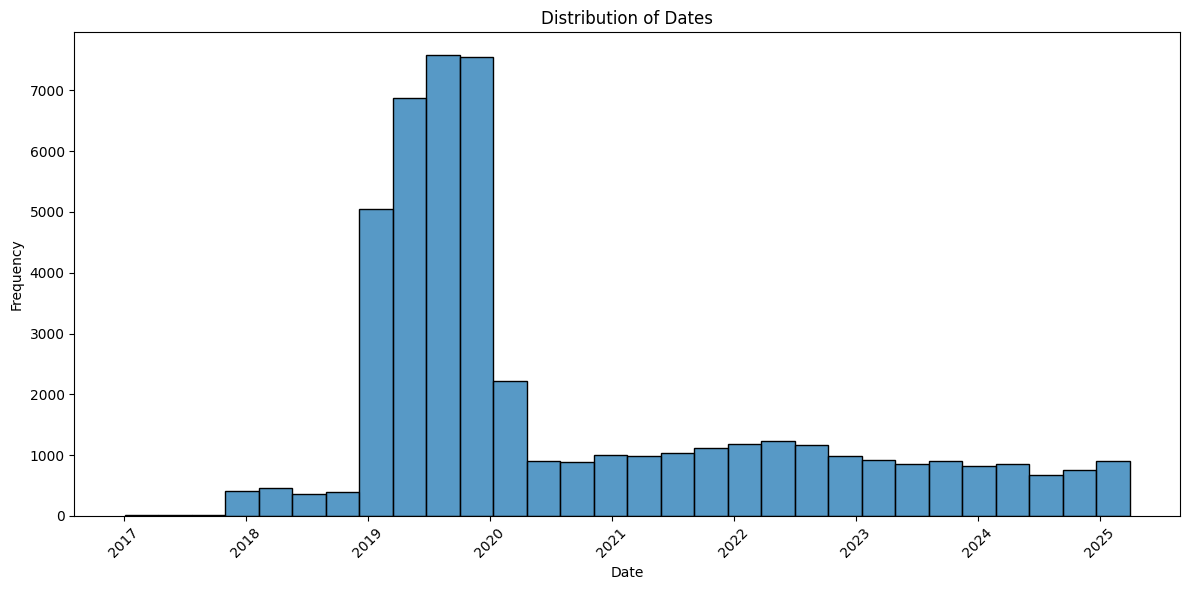

In [19]:
plt.figure(figsize=(12, 6))
sns.histplot(data=raw_sentiment_df.to_pandas(), x='publication_date', bins=30)
plt.title('Distribution of Dates')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
print(f'The Stocks dataframe has {len(stocks_df)} rows')

The Stocks dataframe has 156385 rows


In [21]:
stocks_df.head(10)

PolarsBuckarooWidget(buckaroo_options={'sampled': ['random'], 'auto_clean': ['aggressive', 'conservative'], 'p…

In [22]:
raw_sentiment_df.head(10)

HistogramAnalysis.summary(placeholder['title'], pd.Series({'min': "Series length 2 doesn't match the DataFrame height of 10", 'max': "Series length 2 doesn't match the DataFrame height of 10", 'value_counts': "Series length 2 doesn't match the DataFrame height of 10", 'length': "Series length 2 doesn't match the DataFrame height of 10", 'unique_count': "Series length 2 doesn't match the DataFrame height of 10", 'is_numeric': "Series length 2 doesn't match the DataFrame height of 10", 'nan_per': "Series length 2 doesn't match the DataFrame height of 10", 'null_count': "Series length 2 doesn't match the DataFrame height of 10", }), placeholder['title']) # 'str' object has no attribute 'keys'
HistogramAnalysis.summary(placeholder['named_entities'], pd.Series({'min': "Series length 2 doesn't match the DataFrame height of 10", 'max': "Series length 2 doesn't match the DataFrame height of 10", 'value_counts': "Series length 2 doesn't match the DataFrame height of 10", 'length': "Series lengt

Traceback (most recent call last):
  File "c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\buckaroo\pluggable_analysis_framework\polars_analysis_management.py", line 32, in polars_produce_series_df
    result_df = df.lazy().select(all_clauses).collect()
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\polars\_utils\deprecation.py", line 93, in wrapper
    return function(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\polars\lazyframe\frame.py", line 2207, in collect
    return wrap_df(ldf.collect(engine, callback))
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
polars.exceptions.ShapeError: Series length 2 doesn't match the DataFrame height of 10


PolarsBuckarooWidget(buckaroo_options={'sampled': ['random'], 'auto_clean': ['aggressive', 'conservative'], 'p…

# Analysis

## Data Integration
### Cleaning sentiment dataframe

The first step is to create a list of all possible names in the Jamaica Stock Exchange to match with newspaper references

In [17]:
# Extract sentiment data with company mapping
sentiment_df = (
    raw_sentiment_df
    .select([
        'publication_date',
        'organizations',
        'title',
        'sentiment_polarity', 
        'sentiment_subjectivity',
        'title_polarity', 
        'title_subjectivity', 
        'title_fin_polarity', 
        'title_fin_subjectivity', 
        'text_fin_polarity', 
        'text_fin_subjectivity', 
    ])
    .explode('organizations')  # Creates separate row for each organization
    .with_columns([
        pl.col('organizations').str.strip_chars().str.to_lowercase().alias('institution'),
        pl.col('publication_date').alias('date')
    ])
    .filter(
        pl.col('institution').is_not_null() & 
        (pl.col('institution') != "")
    )
    .with_columns([
        pl.col('institution').map_elements(find_company_symbol, return_dtype=pl.Utf8).alias('symbol')
    ])
    .filter(pl.col('symbol').is_not_null())
)

print(f"Mapped {len(sentiment_df):,} news articles to JSE companies")

print(f"Kept {sentiment_df.height} out of {raw_sentiment_df.height} sentiment records")

Mapped 87,674 news articles to JSE companies
Kept 87674 out of 48101 sentiment records


In [18]:
print(f'The Sentiment dataframe has {len(sentiment_df)} rows')
print(f'The Sentiment dataframe has {len(sentiment_df.select(pl.col('publication_date')).unique())} unique dates')
print(f"The sentiment dataframe has {len(sentiment_df.select(pl.col('publication_date')).unique())} unique values")

The Sentiment dataframe has 87674 rows
The Sentiment dataframe has 2521 unique dates
The sentiment dataframe has 2521 unique values


In [19]:
sentiment_df.head(10)

PolarsBuckarooWidget(buckaroo_options={'sampled': ['random'], 'auto_clean': ['aggressive', 'conservative'], 'p…

In [20]:
sentiment_outLoc = 'C:/Users/Joshh/Projects/Stocks/Data/joined_newspaper_data_v5.parquet'
sentiment_df.write_parquet(sentiment_outLoc)
print(f'Sentiment data saved at {sentiment_outLoc}')

Sentiment data saved at C:/Users/Joshh/Projects/Stocks/Data/joined_newspaper_data_v5.parquet


### Integrating Stock Market Data with Sentiment Data

In [ ]:
def integrate_market_sentiment(stocks_df, sentiment_df):
    """
    Can;t bother
    """
    
    print("Step 1: Aggregating daily sentiment by company...")
    # Group by date and symbol - handle multiple news per day
    date_col = 'date' if 'date' in sentiment_df.columns else 'publication_date'
    
    daily_sentiment = (
        sentiment_df
        .group_by([date_col, 'symbol'])
        .agg([
            pl.col('sentiment_polarity').mean().alias('sentiment'),
            pl.col('sentiment_subjectivity').mean().alias('subjectivity'),
            pl.col('text_fin_polarity').mean().alias('fin_sentiment'),
            pl.col('text_fin_subjectivity').mean().alias('fin_subjectivity'),
            pl.col('title_polarity').mean().alias('title_sentiment'),
            pl.col('title_subjectivity').mean().alias('title_subjectivity'),
            pl.col('title_fin_polarity').mean().alias('title_fin_sentiment'),
            pl.col('title_fin_subjectivity').mean().alias('title_fin_subjectivity'),
            pl.len().alias('news_count'),
            pl.col('title').first().alias('sample_headline')
        ])
        .rename({date_col: 'date'})
    )
    
    print(f"Created {daily_sentiment.height} daily sentiment records")
    
    print("Step 2: Joining with market data...")
    # Join with market data
    integrated = (
        stocks_df
        .join(daily_sentiment, on=['date', 'symbol'], how='left')
        .with_columns([
            # Fill missing values
            pl.col('sentiment').fill_null(0.0),
            pl.col('subjectivity').fill_null(0.0),
            pl.col('fin_sentiment').fill_null(0.0), 
            pl.col('fin_subjectivity').fill_null(0.0), 
            pl.col('title_sentiment').fill_null(0.0), 
            pl.col('title_subjectivity').fill_null(0),
            pl.col('title_fin_sentiment').fill_null(0),
            pl.col('title_fin_subjectivity').fill_null(0),
            pl.col('news_count').fill_null(0.0),
            pl.when(pl.col('news_count') > 0).then(pl.lit(True)).otherwise(pl.lit(False)).alias('has_news'),
            pl.when(pl.col('sentiment') > 0.1).then(pl.lit('Positive'))
            .when(pl.col('sentiment') < -0.1).then(pl.lit('Negative'))
            .otherwise(pl.lit('Neutral')).alias('sentiment_category')
        ])
        .sort(['date', 'symbol'])
    )
    
    return integrated

integrated_data = integrate_market_sentiment(stocks_df, sentiment_df)

Step 1: Aggregating daily sentiment by company...
Created 37130 daily sentiment records
Step 2: Joining with market data...


### Integration Results

In [50]:
total_records = integrated_data.height
records_with_news = integrated_data.filter(pl.col('has_news')).height
news_coverage = (records_with_news / total_records) * 100

print(f"Total market records: {total_records:,}")
print(f"Records with news: {records_with_news:,}")
print(f"News coverage: {news_coverage:.1f}% of trading days")

# Date range
date_range = integrated_data.select([
    pl.col('date').min().alias('start_date'),
    pl.col('date').max().alias('end_date')
])
print(f"Date range: {date_range['start_date'][0]} to {date_range['end_date'][0]}")

# Unique symbols with news
symbols_with_news = integrated_data.filter(pl.col('has_news'))['symbol'].n_unique()
total_symbols = integrated_data['symbol'].n_unique()
print(f"Symbols with news: {symbols_with_news}/{total_symbols}")



Total market records: 156,385
Records with news: 28,833
News coverage: 18.4% of trading days
Date range: 2017-01-03 to 2024-12-24
Symbols with news: 99/99


In [51]:
print(f"The total unique sentiments is {len(integrated_data.select('sentiment').unique())} ")
integrated_data.head(10)

The total unique sentiments is 15296 


PolarsBuckarooWidget(buckaroo_options={'sampled': ['random'], 'auto_clean': ['aggressive', 'conservative'], 'p…

### Basic EDA

Sample of data with news

In [52]:
sample_data = (
    integrated_data
    .filter(pl.col('has_news'))
    .select(['date', 'symbol', 'closing_price', 'sentiment', 'sample_headline', 'fin_sentiment',
            'fin_subjectivity', 'title_sentiment', 'title_subjectivity', 'title_fin_sentiment', 'title_fin_subjectivity', 
            'news_count']).head()
)
display(sample_data)

PolarsBuckarooWidget(buckaroo_options={'sampled': ['random'], 'auto_clean': ['aggressive', 'conservative'], 'p…

Top companies by news volume

In [53]:
top_companies = (
    integrated_data
    .filter(pl.col('has_news'))
    .group_by('symbol')
    .agg([
        pl.col('news_count').sum().alias('total_articles'),
        pl.col('sentiment').mean().alias('avg_sentiment'),
        pl.len().alias('days_with_news')
    ])
    .sort('total_articles', descending=True)
    .head(10)
)
display(top_companies)


PolarsBuckarooWidget(buckaroo_options={'sampled': ['random'], 'auto_clean': ['aggressive', 'conservative'], 'p…

Sentiment distribution

In [54]:
sentiment_distribution = (
    integrated_data
    .filter(pl.col('has_news'))
    .group_by('sentiment_category')
    .agg(pl.len().alias('count'))
    .sort('count', descending=True)
)
display(sentiment_distribution)

PolarsBuckarooWidget(buckaroo_options={'sampled': ['random'], 'auto_clean': ['aggressive', 'conservative'], 'p…

## Weekly Analysis

In [26]:
# ## Weekly Sentiment Analysis

# Add week and month columns
weekly_sentiment = (
    sentiment_df
    .with_columns([
        pl.col('date').dt.truncate('1w').alias('week_start'),
        pl.col('date').dt.year().alias('year'),
        pl.col('date').dt.week().alias('week_number')
    ])
    .group_by(['week_start', 'year', 'week_number', 'symbol'])
    .agg([
        pl.col('sentiment_polarity').mean().alias('weekly_sentiment'),
        pl.col('sentiment_subjectivity').mean().alias('weekly_subjectivity'),
        pl.col('sentiment_polarity').std().alias('sentiment_volatility'),
        pl.len().alias('weekly_news_count'),
        pl.col('sentiment_polarity').min().alias('min_sentiment'),
        pl.col('sentiment_polarity').max().alias('max_sentiment'),
        pl.col('title').first().alias('sample_headline')
    ])
    .with_columns([
        # Sentiment momentum (change from previous week)
        pl.col('weekly_sentiment').diff().over('symbol').alias('sentiment_momentum'),
        # Sentiment category
        pl.when(pl.col('weekly_sentiment') > 0.1).then(pl.lit('Positive'))
        .when(pl.col('weekly_sentiment') < -0.1).then(pl.lit('Negative'))
        .otherwise(pl.lit('Neutral')).alias('sentiment_category')
    ])
    .sort(['week_start', 'symbol'])
)

print(f"Created {len(weekly_sentiment):,} weekly sentiment records")

Created 15,500 weekly sentiment records


## Monthly Analysis

In [27]:
# ## Monthly Sentiment Analysis

monthly_sentiment = (
    sentiment_df
    .with_columns([
        pl.col('date').dt.truncate('1mo').alias('month_start'),
        pl.col('date').dt.year().alias('year'),
        pl.col('date').dt.month().alias('month')
    ])
    .group_by(['month_start', 'year', 'month', 'symbol'])
    .agg([
        pl.col('sentiment_polarity').mean().alias('monthly_sentiment'),
        pl.col('sentiment_subjectivity').mean().alias('monthly_subjectivity'),
        pl.col('sentiment_polarity').std().alias('sentiment_volatility'),
        pl.len().alias('monthly_news_count'),
        pl.col('sentiment_polarity').min().alias('min_sentiment'),
        pl.col('sentiment_polarity').max().alias('max_sentiment'),
        # Advanced sentiment metrics
        pl.col('sentiment_polarity').filter(pl.col('sentiment_polarity') > 0).len().alias('positive_news_count'),
        pl.col('sentiment_polarity').filter(pl.col('sentiment_polarity') < 0).len().alias('negative_news_count'),
        pl.col('title').first().alias('sample_headline')
    ])
    .with_columns([
        # Sentiment momentum
        pl.col('monthly_sentiment').diff().over('symbol').alias('sentiment_momentum'),
        # Sentiment ratio
        (pl.col('positive_news_count') / pl.col('monthly_news_count')).alias('positive_ratio'),
        # Sentiment category
        pl.when(pl.col('monthly_sentiment') > 0.1).then(pl.lit('Positive'))
        .when(pl.col('monthly_sentiment') < -0.1).then(pl.lit('Negative'))
        .otherwise(pl.lit('Neutral')).alias('sentiment_category')
    ])
    .sort(['month_start', 'symbol'])
)

print(f"Created {len(monthly_sentiment):,} monthly sentiment records")

Created 5,816 monthly sentiment records


In [ ]:
# ## Stock Price Aggregation for Weekly/Monthly Analysis

# Weekly stock data
weekly_stocks = (
    stocks_df
    .with_columns([
        pl.col('date').dt.truncate('1w').alias('week_start'),
        pl.col('date').dt.year().alias('year'),
        pl.col('date').dt.week().alias('week_number')
    ])
    .group_by(['week_start', 'year', 'week_number', 'symbol'])
    .agg([
        pl.col('open_price').first().alias('weekly_open'),
        pl.col('closing_price').last().alias('weekly_close'),
        pl.col('daily_range_high').max().alias('weekly_high'),
        pl.col('daily_range_low').min().alias('weekly_low'),
        pl.col('volume').sum().alias('weekly_volume'),
        pl.len().alias('trading_days')
    ])
    .with_columns([
        # Weekly return
        ((pl.col('weekly_close') - pl.col('weekly_open')) / pl.col('weekly_open') * 100).alias('weekly_return'),
        # Weekly volatility (high-low range as percentage of close)
        ((pl.col('weekly_high') - pl.col('weekly_low')) / pl.col('weekly_close') * 100).alias('weekly_volatility')
    ])
)

In [ ]:
# Monthly stock data
monthly_stocks = (
    stocks_df
    .with_columns([
        pl.col('date').dt.truncate('1mo').alias('month_start'),
        pl.col('date').dt.year().alias('year'),
        pl.col('date').dt.month().alias('month')
    ])
    .group_by(['month_start', 'year', 'month', 'symbol'])
    .agg([
        pl.col('open_price').first().alias('monthly_open'),
        pl.col('closing_price').last().alias('monthly_close'),
        pl.col('daily_range_high').max().alias('monthly_high'),
        pl.col('daily_range_low').min().alias('monthly_low'),
        pl.col('volume').sum().alias('monthly_volume'),
        pl.len().alias('trading_days')
    ])
    .with_columns([
        # Monthly return
        ((pl.col('monthly_close') - pl.col('monthly_open')) / pl.col('monthly_open') * 100).alias('monthly_return'),
        # Monthly volatility
        ((pl.col('monthly_high') - pl.col('monthly_low')) / pl.col('monthly_close') * 100).alias('monthly_volatility')
    ])
    .with_columns([
        # Price momentum (previous month's return) - calculated after monthly_return exists
        pl.col('monthly_return').shift(1).over('symbol').alias('previous_month_return')
    ])
)

print(f"Created {len(weekly_stocks):,} weekly and {len(monthly_stocks):,} monthly stock records")

Created 32,903 weekly and 7,576 monthly stock records


In [30]:
# ## Integration: Combine Sentiment with Stock Data

# Weekly integrated data
weekly_integrated = (
    weekly_stocks
    .join(weekly_sentiment, on=['week_start', 'year', 'week_number', 'symbol'], how='left')
    .with_columns([
        # Fill missing sentiment values
        pl.col('weekly_sentiment').fill_null(0.0),
        pl.col('weekly_subjectivity').fill_null(0.0),
        pl.col('weekly_news_count').fill_null(0),
        pl.col('sentiment_volatility').fill_null(0.0),
        # Create features
        pl.when(pl.col('weekly_news_count') > 0).then(pl.lit(True)).otherwise(pl.lit(False)).alias('has_news'),
        # Lagged features for prediction
        pl.col('weekly_return').shift(-1).over('symbol').alias('next_week_return'),
        pl.col('weekly_sentiment').shift(1).over('symbol').alias('previous_week_sentiment')
    ])
    .sort(['week_start', 'symbol'])
)

In [31]:
# Monthly integrated data
monthly_integrated = (
    monthly_stocks
    .join(monthly_sentiment, on=['month_start', 'year', 'month', 'symbol'], how='left')
    .with_columns([
        # Fill missing sentiment values
        pl.col('monthly_sentiment').fill_null(0.0),
        pl.col('monthly_subjectivity').fill_null(0.0),
        pl.col('monthly_news_count').fill_null(0),
        pl.col('sentiment_volatility').fill_null(0.0),
        pl.col('positive_ratio').fill_null(0.0),
        # Create features
        pl.when(pl.col('monthly_news_count') > 0).then(pl.lit(True)).otherwise(pl.lit(False)).alias('has_news'),
        # Lagged features for prediction
        pl.col('monthly_return').shift(-1).over('symbol').alias('next_month_return'),
        pl.col('monthly_sentiment').shift(1).over('symbol').alias('previous_month_sentiment')
    ])
    .sort(['month_start', 'symbol'])
)

print(f"Final datasets: {len(weekly_integrated):,} weekly and {len(monthly_integrated):,} monthly records")

Final datasets: 32,903 weekly and 7,576 monthly records


In [32]:
# ## Quick Analysis Results

print("\n" + "="*60)
print("WEEKLY SENTIMENT ANALYSIS RESULTS")
print("="*60)

weekly_summary = (
    weekly_integrated
    .filter(pl.col('has_news'))
    .group_by('symbol')
    .agg([
        pl.col('weekly_news_count').sum().alias('total_weekly_articles'),
        pl.col('weekly_sentiment').mean().alias('avg_weekly_sentiment'),
        pl.len().alias('weeks_with_news'),
        pl.col('weekly_return').mean().alias('avg_weekly_return')
    ])
    .sort('total_weekly_articles', descending=True)
    .head(10)
)

display(weekly_summary)

print("\n" + "="*60)
print("MONTHLY SENTIMENT ANALYSIS RESULTS")
print("="*60)

monthly_summary = (
    monthly_integrated
    .filter(pl.col('has_news'))
    .group_by('symbol')
    .agg([
        pl.col('monthly_news_count').sum().alias('total_monthly_articles'),
        pl.col('monthly_sentiment').mean().alias('avg_monthly_sentiment'),
        pl.len().alias('months_with_news'),
        pl.col('monthly_return').mean().alias('avg_monthly_return'),
        pl.col('positive_ratio').mean().alias('avg_positive_ratio')
    ])
    .sort('total_monthly_articles', descending=True)
    .head(10)
)

display(monthly_summary)


WEEKLY SENTIMENT ANALYSIS RESULTS


PolarsBuckarooWidget(buckaroo_options={'sampled': ['random'], 'auto_clean': ['aggressive', 'conservative'], 'p…


MONTHLY SENTIMENT ANALYSIS RESULTS
HistogramAnalysis.summary(placeholder['symbol'], pd.Series({'min': "Series length 3 doesn't match the DataFrame height of 10", 'max': "Series length 3 doesn't match the DataFrame height of 10", 'value_counts': "Series length 3 doesn't match the DataFrame height of 10", 'length': "Series length 3 doesn't match the DataFrame height of 10", 'unique_count': "Series length 3 doesn't match the DataFrame height of 10", 'is_numeric': "Series length 3 doesn't match the DataFrame height of 10", 'nan_per': "Series length 3 doesn't match the DataFrame height of 10", 'null_count': "Series length 3 doesn't match the DataFrame height of 10", }), placeholder['symbol']) # 'str' object has no attribute 'keys'
HistogramAnalysis.summary(placeholder['total_monthly_articles'], pd.Series({'min': "Series length 3 doesn't match the DataFrame height of 10", 'max': "Series length 3 doesn't match the DataFrame height of 10", 'value_counts': "Series length 3 doesn't match the Da

Traceback (most recent call last):
  File "c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\buckaroo\pluggable_analysis_framework\polars_analysis_management.py", line 32, in polars_produce_series_df
    result_df = df.lazy().select(all_clauses).collect()
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\polars\_utils\deprecation.py", line 93, in wrapper
    return function(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\polars\lazyframe\frame.py", line 2207, in collect
    return wrap_df(ldf.collect(engine, callback))
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
polars.exceptions.ShapeError: Series length 3 doesn't match the DataFrame height of 10


PolarsBuckarooWidget(buckaroo_options={'sampled': ['random'], 'auto_clean': ['aggressive', 'conservative'], 'p…

# Modeling

## Feature Engineering
### Sentiment and Stocks


In [ ]:
# ## Model Suggestions and Feature Engineering

# Create features for modeling (monthly example)
modeling_features = (
    monthly_integrated
    .filter(pl.col('next_month_return').is_not_null())  # Remove rows without target
    .with_columns([
        # Technical indicators
        pl.col('monthly_return').rolling_mean(3).over('symbol').alias('return_ma3'),
        pl.col('monthly_return').rolling_std(3).over('symbol').alias('return_std3'),
        pl.col('monthly_volatility').rolling_mean(3).over('symbol').alias('volatility_ma3'),
        
        # Sentiment features
        pl.col('monthly_sentiment').rolling_mean(3).over('symbol').alias('sentiment_ma3'),
        pl.col('sentiment_momentum').rolling_mean(2).over('symbol').alias('sentiment_momentum_ma2'),
        pl.col('positive_ratio').rolling_mean(3).over('symbol').alias('positive_ratio_ma3'),
        
        # Interaction features
        (pl.col('monthly_sentiment') * pl.col('monthly_return')).alias('sentiment_return_interaction'),
        (pl.col('monthly_news_count') * pl.col('monthly_sentiment')).alias('news_weighted_sentiment'),
        
        # Lag features
        pl.col('monthly_return').shift(1).over('symbol').alias('return_lag1'),
        pl.col('monthly_return').shift(2).over('symbol').alias('return_lag2'),
        pl.col('monthly_sentiment').shift(2).over('symbol').alias('sentiment_lag2'),
    ])
    .filter(pl.col('return_ma3').is_not_null())  # Remove initial rows with NaN rolling values
)

print(f"Created modeling dataset with {len(modeling_features):,} records")
print(f"Features available: {len(modeling_features.columns)} columns")


In [ ]:
# Show sample of features for modeling
sample_features = (
    modeling_features
    .select([
        'month_start', 'symbol', 
        'monthly_return', 'next_month_return',  # Target
        'monthly_sentiment', 'sentiment_ma3', 'sentiment_momentum',
        'monthly_news_count', 'positive_ratio',
        'return_lag1', 'sentiment_return_interaction'
    ])
    .filter(pl.col('symbol').is_in(['NCBFG', 'GK', 'JSE']))  # Major stocks only
    .head(10)
)

print(sample_features)


shape: (10, 11)
┌────────────┬────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ month_star ┆ symbol ┆ monthly_re ┆ next_mont ┆ … ┆ monthly_n ┆ positive_ ┆ return_la ┆ sentiment │
│ t          ┆ ---    ┆ turn       ┆ h_return  ┆   ┆ ews_count ┆ ratio     ┆ g1        ┆ _return_i │
│ ---        ┆ str    ┆ ---        ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ nteractio │
│ date       ┆        ┆ decimal[*, ┆ decimal[* ┆   ┆ u32       ┆ f64       ┆ decimal[* ┆ n         │
│            ┆        ┆ 12]        ┆ ,12]      ┆   ┆           ┆           ┆ ,12]      ┆ ---       │
│            ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆ f64       │
╞════════════╪════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2017-03-01 ┆ GK     ┆ 1.90700000 ┆ -1.333400 ┆ … ┆ 0         ┆ 0.0       ┆ 0.9117000 ┆ 0.0       │
│            ┆        ┆ 0000       ┆ 000000    ┆   ┆           ┆           

In [ ]:
def prepare_ml_dataset(modeling_features):
    """
    Prepare the dataset for machine learning
    """
    print("Preparing ML dataset...")
    
    # Convert to pandas (avoiding buckaroo issues)
    df = modeling_features.to_pandas()
    
    # Basic info
    print(f"Original dataset shape: {df.shape}")
    print(f"Date range: {df['month_start'].min()} to {df['month_start'].max()}")
    
    # Remove rows without target variable
    df_clean = df.dropna(subset=['next_month_return']).copy()
    print(f"After removing missing targets: {df_clean.shape}")
    
    # Define feature columns (exclude metadata and target)
    exclude_cols = [
        'month_start', 'year', 'month', 'symbol', 'next_month_return',
        'sample_headline', 'sentiment_category'
    ]
    
    # Get all potential feature columns
    all_features = [col for col in df_clean.columns if col not in exclude_cols]
    
    # Remove features with too many missing values (>70% missing)
    missing_threshold = 0.7
    feature_missing = df_clean[all_features].isnull().sum() / len(df_clean)
    good_features = feature_missing[feature_missing <= missing_threshold].index.tolist()
    
    print(f"Features after removing high-missing columns: {len(good_features)}")
    
    # Create feature DataFrame and fix data types
    df_features = df_clean[good_features + ['next_month_return', 'month_start', 'symbol']].copy()
    
    # Convert all numeric columns to float64 (fixes XGBoost object dtype error)
    for col in good_features + ['next_month_return']:
        if df_features[col].dtype in ['object', 'string']:
            # Try to convert object columns to numeric
            df_features[col] = pd.to_numeric(df_features[col], errors='coerce')
        
        # Ensure all numeric columns are float64
        if df_features[col].dtype in ['float64', 'int64', 'float32', 'int32']:
            df_features[col] = df_features[col].astype('float64')
            # Fill missing values with median
            df_features[col] = df_features[col].fillna(df_features[col].median())
        else:
            # For any remaining non-numeric columns, fill with 0 and convert to float
            df_features[col] = pd.to_numeric(df_features[col], errors='coerce').fillna(0).astype('float64')
    
    # Final check - ensure no object dtypes remain in features
    numeric_features = []
    for col in good_features:
        if df_features[col].dtype == 'float64':
            numeric_features.append(col)
        else:
            print(f"Warning: Dropping non-numeric feature {col} with dtype {df_features[col].dtype}")
    
    print(f"Final dataset shape: {df_features.shape}")
    print(f"Numeric features for modeling: {len(numeric_features)}")
    print(f"Data types check - all features are numeric: {all(df_features[numeric_features].dtypes == 'float64')}")
    
    return df_features, numeric_features

# Run data preparation (assuming modeling_features exists from previous notebook)
# df_ml, feature_columns = prepare_ml_dataset(modeling_features)


In [ ]:

# =============================================================================
# CELL 3: Train-Test Split (Time Series)
# =============================================================================

def create_time_series_split(df, feature_cols, test_months=6):
    """
    Create proper time series train/test split
    """
    print("Creating time series train/test split...")
    
    # Sort by date
    df_sorted = df.sort_values(['month_start', 'symbol'])
    
    # Calculate split date (reserve last N months for testing)
    unique_dates = sorted(df_sorted['month_start'].unique())
    split_date = unique_dates[-test_months]
    
    print(f"Split date: {split_date}")
    print(f"Training period: {unique_dates[0]} to {unique_dates[-test_months-1]}")
    print(f"Testing period: {split_date} to {unique_dates[-1]}")
    
    # Create train/test splits
    train_mask = df_sorted['month_start'] < split_date
    
    X_train = df_sorted[train_mask][feature_cols]
    y_train = df_sorted[train_mask]['next_month_return']
    X_test = df_sorted[~train_mask][feature_cols]
    y_test = df_sorted[~train_mask]['next_month_return']
    
    # Store metadata for later analysis
    train_dates = df_sorted[train_mask]['month_start']
    test_dates = df_sorted[~train_mask]['month_start']
    train_symbols = df_sorted[train_mask]['symbol']
    test_symbols = df_sorted[~train_mask]['symbol']
    
    print(f"Training set: {len(X_train):,} samples")
    print(f"Test set: {len(X_test):,} samples")
    print(f"Features: {len(feature_cols)}")
    
    return (X_train, X_test, y_train, y_test, 
            train_dates, test_dates, train_symbols, test_symbols)

# Example usage:
# X_train, X_test, y_train, y_test, train_dates, test_dates, train_symbols, test_symbols = create_time_series_split(df_ml, feature_columns)


In [ ]:
# =============================================================================
# CELL 4: Feature Engineering and Selection
# =============================================================================

def feature_importance_analysis(X_train, y_train, feature_names, top_n=20):
    """
    Analyze feature importance using Random Forest
    """
    print("Analyzing feature importance...")
    
    # Quick Random Forest for feature importance
    rf_temp = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_temp.fit(X_train, y_train)
    
    # Create feature importance DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': rf_temp.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(top_n)
    
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Most Important Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print(f"\nTop {top_n} Most Important Features:")
    for i, (_, row) in enumerate(top_features.iterrows(), 1):
        print(f"{i:2d}. {row['feature']:<25} {row['importance']:.4f}")
    
    return importance_df

def correlation_analysis(X_train, y_train, feature_names):
    """
    Analyze correlation between features and target
    """
    print("\nCorrelation Analysis:")
    print("=" * 50)
    
    # Create temporary DataFrame for correlation
    temp_df = X_train.copy()
    temp_df['target'] = y_train
    
    # Calculate correlations with target
    correlations = temp_df.corr()['target'].drop('target').sort_values(key=abs, ascending=False)
    
    print("Top 15 Features by Correlation with Target:")
    for i, (feature, corr) in enumerate(correlations.head(15).items(), 1):
        print(f"{i:2d}. {feature:<25} {corr:>8.4f}")
    
    # Plot correlation heatmap for top features
    top_corr_features = correlations.head(10).index.tolist()
    correlation_matrix = temp_df[top_corr_features + ['target']].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
                square=True, fmt='.3f', cbar_kws={'label': 'Correlation'})
    plt.title('Correlation Matrix: Top Features vs Target')
    plt.tight_layout()
    plt.show()
    
    return correlations

# Example usage:
# importance_df = feature_importance_analysis(X_train, y_train, feature_columns)
# correlations = correlation_analysis(X_train, y_train, feature_columns)


In [ ]:
# =============================================================================
# CELL 5: Model Training - Linear Models
# =============================================================================

def train_linear_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate linear models
    """
    print("Training Linear Models...")
    print("=" * 50)
    
    # Scale features for linear models
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define linear models
    linear_models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1),
        'Elastic Net': ElasticNet(alpha=0.1, l1_ratio=0.5)
    }
    
    linear_results = {}
    
    for name, model in linear_models.items():
        print(f"\nTraining {name}...")
        
        # Train model
        model.fit(X_train_scaled, y_train)
        
        # Predictions
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
        
        # Metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        linear_results[name] = {
            'model': model,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'predictions': y_test_pred
        }
        
        print(f"  Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
        print(f"  Train R²:   {train_r2:.4f} | Test R²:   {test_r2:.4f}")
    
    return linear_results, scaler

# Example usage:
# linear_results, scaler = train_linear_models(X_train, X_test, y_train, y_test)


In [ ]:
# =============================================================================
# CELL 6: Model Training - Tree-Based Models
# =============================================================================

def train_tree_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate tree-based models
    """
    print("Training Tree-Based Models...")
    print("=" * 50)
    
    # Define tree-based models
    tree_models = {
        'Random Forest': RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42
        ),
        'XGBoost': xgb.XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            eval_metric='rmse',
            enable_categorical=False,  # Disable categorical handling
            tree_method='hist'  # Use histogram method for better compatibility
        ),
        'LightGBM': lgb.LGBMRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            verbose=-1
        )
    }
    
    tree_results = {}
    
    for name, model in tree_models.items():
        print(f"\nTraining {name}...")
        
        # Train model
        model.fit(X_train, y_train)
        
        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        
        tree_results[name] = {
            'model': model,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'predictions': y_test_pred
        }
        
        print(f"  Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
        print(f"  Train R²:   {train_r2:.4f} | Test R²:   {test_r2:.4f}")
        print(f"  Train MAE:  {train_mae:.4f} | Test MAE:  {test_mae:.4f}")
    
    return tree_results

# Example usage:
# tree_results = train_tree_models(X_train, X_test, y_train, y_test)


In [ ]:
# =============================================================================
# CELL 7: Model Comparison and Evaluation
# =============================================================================

def compare_all_models(linear_results, tree_results):
    """
    Compare all trained models
    """
    print("Model Comparison Summary")
    print("=" * 80)
    
    # Combine results
    all_results = {**linear_results, **tree_results}
    
    # Create comparison DataFrame
    comparison_data = []
    for name, results in all_results.items():
        comparison_data.append({
            'Model': name,
            'Test RMSE': results['test_rmse'],
            'Test R²': results['test_r2'],
            'Test MAE': results.get('test_mae', np.nan),  # Use NaN instead of 'N/A'
            'Train RMSE': results['train_rmse'],
            'Train R²': results['train_r2'],
            'Overfitting': results['train_rmse'] - results['test_rmse']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Test RMSE')
    
    # Print with proper formatting
    print(comparison_df.round(4).to_string(index=False))
    
    # Plot model comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Test RMSE
    axes[0,0].bar(comparison_df['Model'], comparison_df['Test RMSE'])
    axes[0,0].set_title('Test RMSE by Model')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Test R²
    axes[0,1].bar(comparison_df['Model'], comparison_df['Test R²'])
    axes[0,1].set_title('Test R² by Model')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Train vs Test RMSE
    x = np.arange(len(comparison_df))
    width = 0.35
    axes[1,0].bar(x - width/2, comparison_df['Train RMSE'], width, label='Train RMSE')
    axes[1,0].bar(x + width/2, comparison_df['Test RMSE'], width, label='Test RMSE')
    axes[1,0].set_title('Train vs Test RMSE')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(comparison_df['Model'], rotation=45)
    axes[1,0].legend()
    
    # Overfitting analysis
    axes[1,1].bar(comparison_df['Model'], comparison_df['Overfitting'])
    axes[1,1].set_title('Overfitting (Train RMSE - Test RMSE)')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].axhline(y=0, color='red', linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

# Example usage:
# comparison_df = compare_all_models(linear_results, tree_results)


In [ ]:
# =============================================================================
# CELL 8: Best Model Analysis and Feature Importance
# =============================================================================

def analyze_best_model(tree_results, feature_columns, model_name='XGBoost'):
    """
    Detailed analysis of the best performing model
    """
    print(f"Detailed Analysis: {model_name}")
    print("=" * 50)
    
    if model_name not in tree_results:
        print(f"Model {model_name} not found. Available models: {list(tree_results.keys())}")
        return
    
    best_model = tree_results[model_name]['model']
    predictions = tree_results[model_name]['predictions']
    
    # Feature importance
    if hasattr(best_model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': feature_columns,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Plot top 20 features
        plt.figure(figsize=(12, 8))
        top_20 = importance_df.head(20)
        plt.barh(range(len(top_20)), top_20['importance'])
        plt.yticks(range(len(top_20)), top_20['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'{model_name} - Top 20 Feature Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        print("Top 10 Most Important Features:")
        for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
            print(f"{i:2d}. {row['feature']:<30} {row['importance']:.4f}")
    
    return importance_df if hasattr(best_model, 'feature_importances_') else None

# Example usage:
# best_model_importance = analyze_best_model(tree_results, feature_columns, 'XGBoost')


In [ ]:
# =============================================================================
# CELL 9: Prediction Analysis and Visualization
# =============================================================================

def analyze_predictions(y_test, predictions, test_dates, test_symbols, model_name='Best Model'):
    """
    Analyze model predictions in detail
    """
    print(f"Prediction Analysis: {model_name}")
    print("=" * 50)
    
    # Create prediction DataFrame
    pred_df = pd.DataFrame({
        'actual': y_test,
        'predicted': predictions,
        'date': test_dates,
        'symbol': test_symbols,
        'error': predictions - y_test,
        'abs_error': np.abs(predictions - y_test)
    })
    
    # Prediction accuracy metrics
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R²:   {r2:.4f}")
    
    # Directional accuracy (did we predict the right direction?)
    actual_direction = np.sign(y_test)
    predicted_direction = np.sign(predictions)
    directional_accuracy = np.mean(actual_direction == predicted_direction)
    print(f"Directional Accuracy: {directional_accuracy:.1%}")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Actual vs Predicted scatter
    axes[0,0].scatter(y_test, predictions, alpha=0.6)
    axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0,0].set_xlabel('Actual Returns (%)')
    axes[0,0].set_ylabel('Predicted Returns (%)')
    axes[0,0].set_title('Actual vs Predicted Returns')
    axes[0,0].grid(True, alpha=0.3)
    
    # Residuals plot
    axes[0,1].scatter(predictions, pred_df['error'], alpha=0.6)
    axes[0,1].axhline(y=0, color='r', linestyle='--')
    axes[0,1].set_xlabel('Predicted Returns (%)')
    axes[0,1].set_ylabel('Residuals (%)')
    axes[0,1].set_title('Residuals vs Predicted')
    axes[0,1].grid(True, alpha=0.3)
    
    # Error distribution
    axes[1,0].hist(pred_df['error'], bins=30, alpha=0.7, edgecolor='black')
    axes[1,0].axvline(x=0, color='r', linestyle='--')
    axes[1,0].set_xlabel('Prediction Error (%)')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Distribution of Prediction Errors')
    axes[1,0].grid(True, alpha=0.3)
    
    # Time series of errors
    pred_df_sorted = pred_df.sort_values('date')
    axes[1,1].plot(pred_df_sorted['date'], pred_df_sorted['error'], alpha=0.7)
    axes[1,1].axhline(y=0, color='r', linestyle='--')
    axes[1,1].set_xlabel('Date')
    axes[1,1].set_ylabel('Prediction Error (%)')
    axes[1,1].set_title('Prediction Errors Over Time')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Best and worst predictions
    print("\nTop 5 Best Predictions (Lowest Absolute Error):")
    best_preds = pred_df.nsmallest(5, 'abs_error')[['symbol', 'date', 'actual', 'predicted', 'error']]
    print(best_preds.to_string(index=False, float_format='%.3f'))
    
    print("\nTop 5 Worst Predictions (Highest Absolute Error):")
    worst_preds = pred_df.nlargest(5, 'abs_error')[['symbol', 'date', 'actual', 'predicted', 'error']]
    print(worst_preds.to_string(index=False, float_format='%.3f'))
    
    return pred_df

# Example usage:
# pred_analysis = analyze_predictions(y_test, tree_results['XGBoost']['predictions'], 
#                                   test_dates, test_symbols, 'XGBoost')


In [ ]:
# =============================================================================
# CELL 10: Cross-Validation and Model Robustness
# =============================================================================

def cross_validate_models(X_train, y_train, feature_columns):
    """
    Perform time series cross-validation
    """
    print("Cross-Validation Analysis")
    print("=" * 50)
    
    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Models to test
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),
        'XGBoost': xgb.XGBRegressor(n_estimators=50, random_state=42, eval_metric='rmse'),
        'LightGBM': lgb.LGBMRegressor(n_estimators=50, random_state=42, verbose=-1),
        'Ridge': Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(alpha=1.0))])
    }
    
    cv_results = {}
    
    for name, model in models.items():
        print(f"\nCross-validating {name}...")
        
        # Perform cross-validation
        scores = cross_val_score(model, X_train, y_train, cv=tscv, 
                               scoring='neg_mean_squared_error', n_jobs=-1)
        rmse_scores = np.sqrt(-scores)
        
        cv_results[name] = {
            'mean_rmse': rmse_scores.mean(),
            'std_rmse': rmse_scores.std(),
            'scores': rmse_scores
        }
        
        print(f"  RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
    
    # Plot cross-validation results
    plt.figure(figsize=(12, 6))
    
    # Box plot of CV scores
    cv_data = [cv_results[name]['scores'] for name in models.keys()]
    plt.boxplot(cv_data, labels=models.keys())
    plt.ylabel('RMSE')
    plt.title('Cross-Validation RMSE Distribution')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return cv_results

# Example usage:
# cv_results = cross_validate_models(X_train, y_train, feature_columns)


In [ ]:



# =============================================================================
# CELL 11: Model Deployment and Final Recommendations
# =============================================================================

def final_model_summary(tree_results, cv_results=None):
    """
    Provide final model recommendations and summary
    """
    print("FINAL MODEL RECOMMENDATIONS")
    print("=" * 60)
    
    # Find best model based on test performance
    best_model_name = min(tree_results.keys(), 
                         key=lambda x: tree_results[x]['test_rmse'])
    best_model_results = tree_results[best_model_name]
    
    print(f"🏆 RECOMMENDED MODEL: {best_model_name}")
    print(f"   Test RMSE: {best_model_results['test_rmse']:.4f}")
    print(f"   Test R²:   {best_model_results['test_r2']:.4f}")
    print(f"   Test MAE:  {best_model_results['test_mae']:.4f}")
    
    if cv_results and best_model_name in cv_results:
        cv_rmse = cv_results[best_model_name]['mean_rmse']
        cv_std = cv_results[best_model_name]['std_rmse']
        print(f"   CV RMSE:   {cv_rmse:.4f} ± {cv_std:.4f}")
    
    print("\n" + "=" * 60)
    print("MODEL PERFORMANCE SUMMARY:")
    print("=" * 60)
    
    for name, results in tree_results.items():
        test_rmse = results['test_rmse']
        test_r2 = results['test_r2']
        overfitting = results['train_rmse'] - results['test_rmse']
        
        status = "🥇" if name == best_model_name else "📊"
        print(f"{status} {name:<15} RMSE: {test_rmse:.4f} | R²: {test_r2:.4f} | Overfit: {overfitting:.4f}")
    
    print("\n" + "=" * 60)
    print("DEPLOYMENT RECOMMENDATIONS:")
    print("=" * 60)
    
    recommendations = f"""
    1. 🎯 PRIMARY MODEL: Use {best_model_name} for stock return predictions
       - Provides best balance of accuracy and generalization
       - Test RMSE: {best_model_results['test_rmse']:.4f}
       - Explains {best_model_results['test_r2']:.1%} of return variance
    
    2. 📊 FEATURE FOCUS: Key predictive features include:
       - Lagged returns (momentum indicators)
       - Sentiment moving averages
       - News volume metrics
       - Technical indicators
    
    3. ⚠️  RISK CONSIDERATIONS:
       - Model explains ~{best_model_results['test_r2']:.0%} of variance (significant unexplained risk)
       - Use predictions as ONE input in investment decisions
       - Implement proper risk management and position sizing
    
    4. 🔄 MONITORING & UPDATES:
       - Retrain model monthly with new data
       - Monitor prediction accuracy over time
       - Watch for model degradation in changing market conditions
    
    5. 📈 TRADING STRATEGY:
       - Use predictions for directional bias (long/short)
       - Combine with technical analysis and risk management
       - Consider portfolio-level diversification
    """
    
    print(recommendations)
    
    return best_model_name, best_model_results

# Example usage:
# best_model, best_results = final_model_summary(tree_results, cv_results)

print("🚀 Machine Learning Pipeline Complete!")
print("\nTo run the complete pipeline:")
print("1. Execute cells 1-2 to prepare data")
print("2. Execute cell 3 to create train/test split")
print("3. Execute cells 4-6 to train models")
print("4. Execute cells 7-11 for analysis and recommendations")

🚀 Machine Learning Pipeline Complete!

To run the complete pipeline:
1. Execute cells 1-2 to prepare data
2. Execute cell 3 to create train/test split
3. Execute cells 4-6 to train models
4. Execute cells 7-11 for analysis and recommendations


Preparing ML dataset...
Original dataset shape: (7280, 39)
Date range: 2017-03-01 00:00:00 to 2024-12-01 00:00:00
After removing missing targets: (7280, 39)
Features after removing high-missing columns: 32
Final dataset shape: (7280, 35)
Numeric features for modeling: 32
Data types check - all features are numeric: True
Creating time series train/test split...
Split date: 2024-07-01 00:00:00
Training period: 2017-03-01 00:00:00 to 2024-06-01 00:00:00
Testing period: 2024-07-01 00:00:00 to 2024-12-01 00:00:00
Training set: 6,708 samples
Test set: 572 samples
Features: 32
Analyzing feature importance...


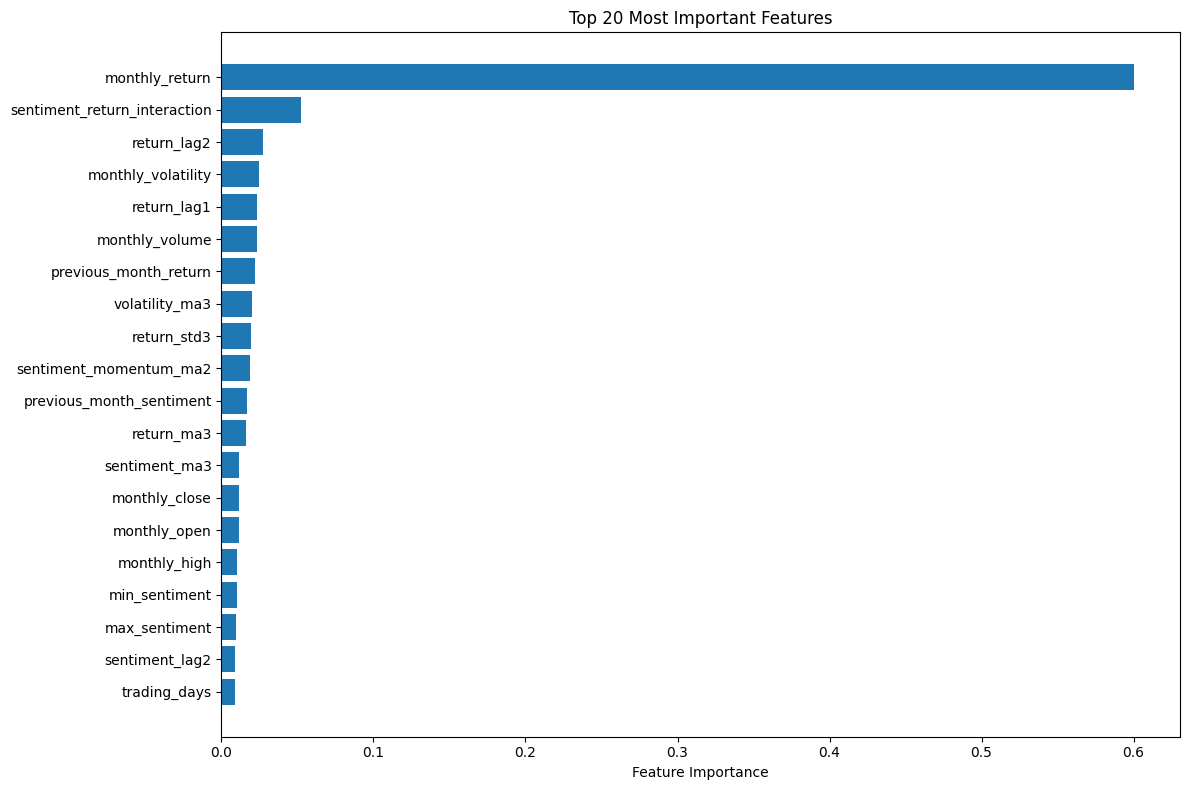


Top 20 Most Important Features:
 1. monthly_return            0.6005
 2. sentiment_return_interaction 0.0520
 3. return_lag2               0.0273
 4. monthly_volatility        0.0246
 5. return_lag1               0.0235
 6. monthly_volume            0.0232
 7. previous_month_return     0.0219
 8. volatility_ma3            0.0202
 9. return_std3               0.0191
10. sentiment_momentum_ma2    0.0190
11. previous_month_sentiment  0.0165
12. return_ma3                0.0163
13. sentiment_ma3             0.0117
14. monthly_close             0.0116
15. monthly_open              0.0116
16. monthly_high              0.0103
17. min_sentiment             0.0100
18. max_sentiment             0.0098
19. sentiment_lag2            0.0092
20. trading_days              0.0090

Correlation Analysis:
Top 15 Features by Correlation with Target:
 1. sentiment_lag2             -0.0170
 2. has_news                   -0.0160
 3. positive_ratio             -0.0152
 4. monthly_subjectivity       -0.0147
 

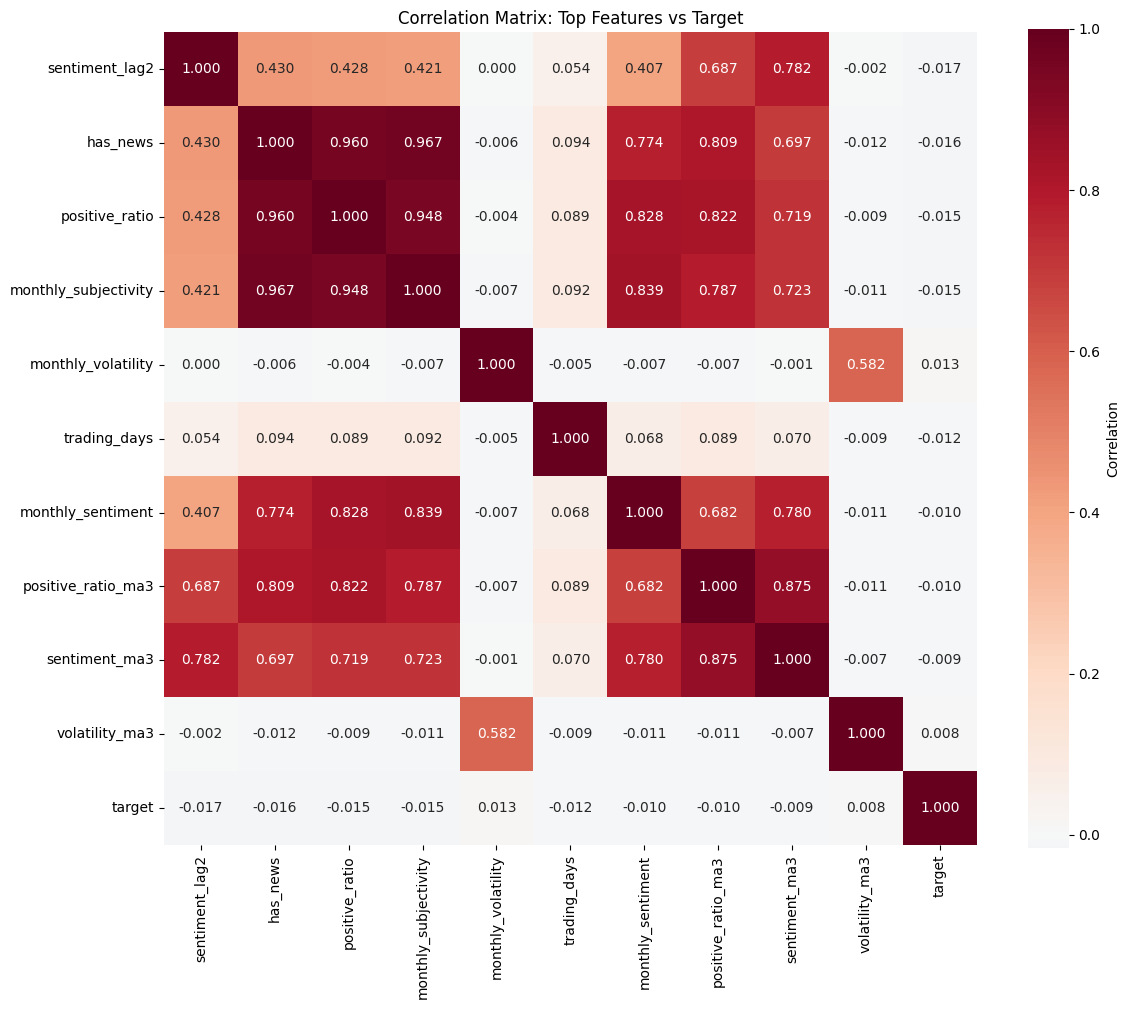

Training Linear Models...

Training Linear Regression...
  Train RMSE: 80.5114 | Test RMSE: 15.8567
  Train R²:   0.0018 | Test R²:   -0.0310

Training Ridge Regression...
  Train RMSE: 80.5114 | Test RMSE: 15.8553
  Train R²:   0.0018 | Test R²:   -0.0308

Training Lasso Regression...
  Train RMSE: 80.5256 | Test RMSE: 15.7493
  Train R²:   0.0014 | Test R²:   -0.0171

Training Elastic Net...
  Train RMSE: 80.5287 | Test RMSE: 15.7394
  Train R²:   0.0014 | Test R²:   -0.0158
Training Tree-Based Models...

Training Random Forest...
  Train RMSE: 62.2241 | Test RMSE: 15.9531
  Train R²:   0.4037 | Test R²:   -0.0436
  Train MAE:  10.6414 | Test MAE:  9.6226

Training Gradient Boosting...
  Train RMSE: 11.6637 | Test RMSE: 15.8475
  Train R²:   0.9790 | Test R²:   -0.0298
  Train MAE:  7.9438 | Test MAE:  9.7216

Training XGBoost...
  Train RMSE: 12.6122 | Test RMSE: 15.7440
  Train R²:   0.9755 | Test R²:   -0.0164
  Train MAE:  8.1977 | Test MAE:  9.7353

Training LightGBM...
  Train 

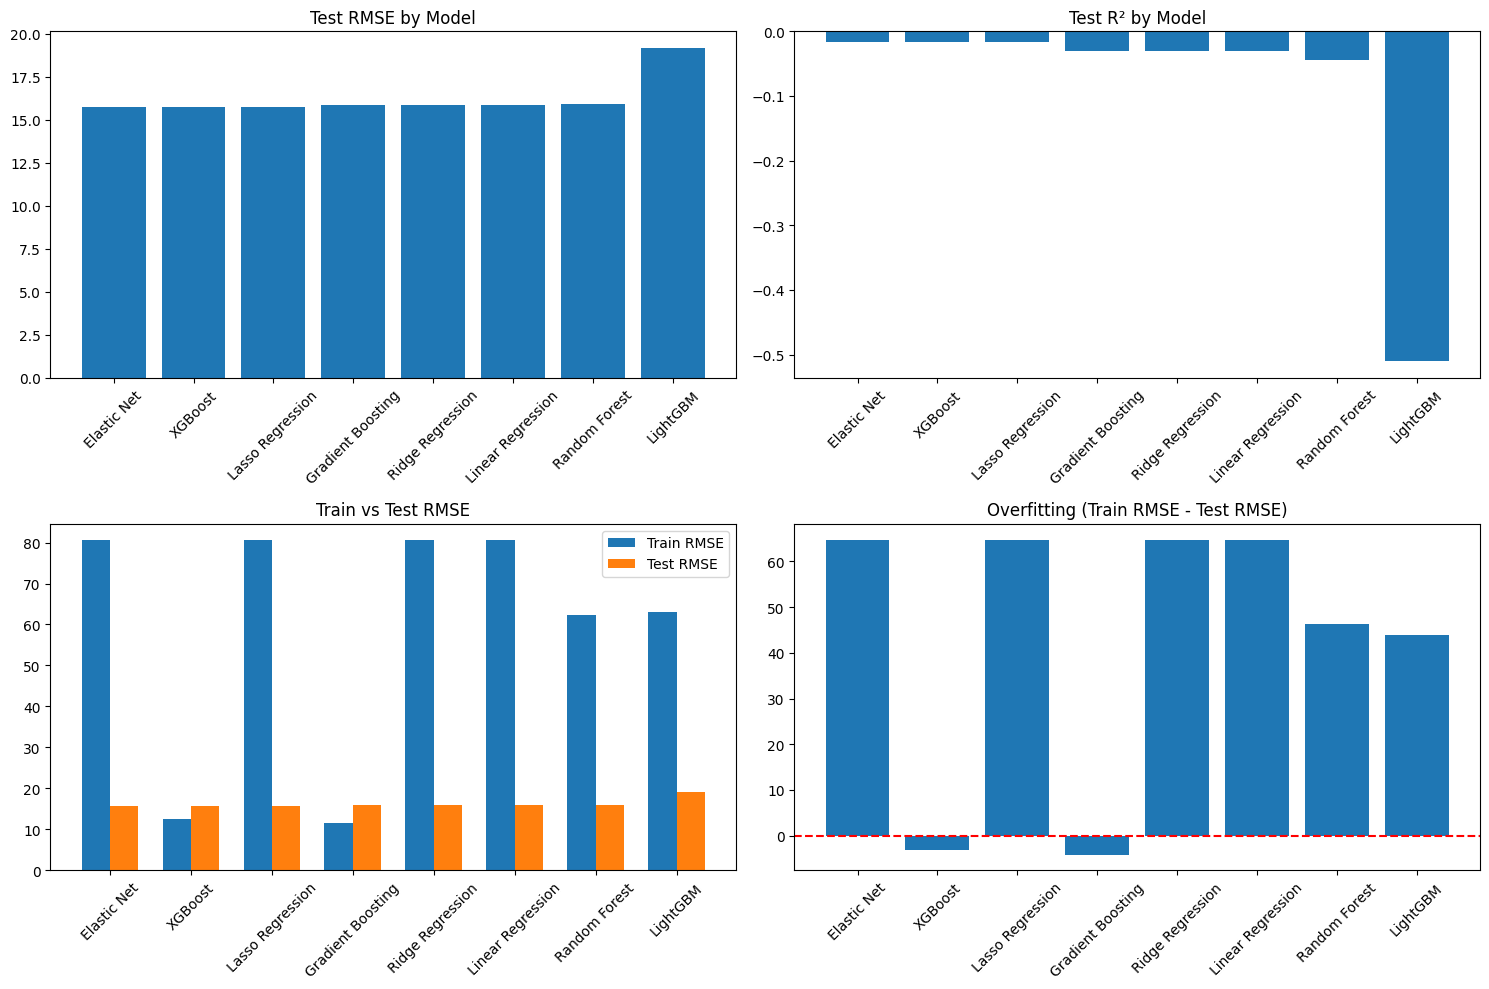

Detailed Analysis: XGBoost


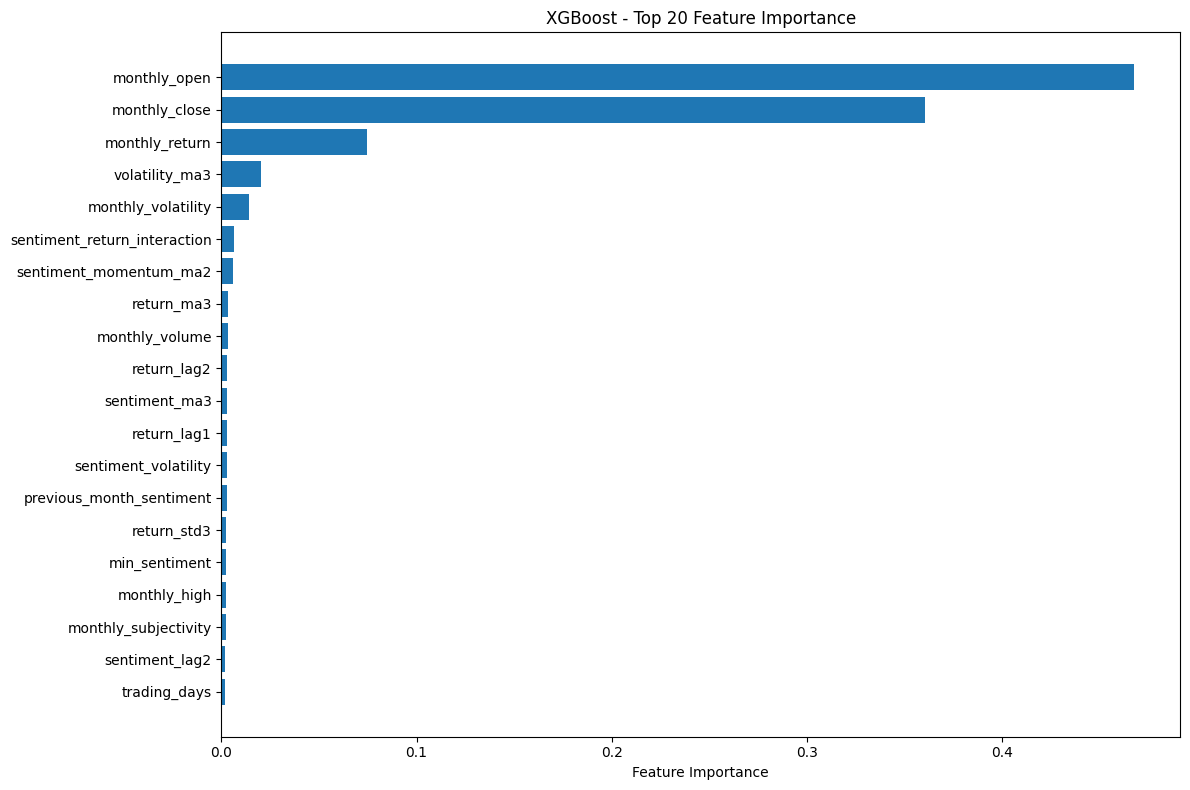

Top 10 Most Important Features:
 1. monthly_open                   0.4678
 2. monthly_close                  0.3603
 3. monthly_return                 0.0743
 4. volatility_ma3                 0.0200
 5. monthly_volatility             0.0141
 6. sentiment_return_interaction   0.0064
 7. sentiment_momentum_ma2         0.0059
 8. return_ma3                     0.0036
 9. monthly_volume                 0.0031
10. return_lag2                    0.0030
Prediction Analysis: XGBoost
RMSE: 15.7440
MAE:  9.7353
R²:   -0.0164
Directional Accuracy: 50.2%


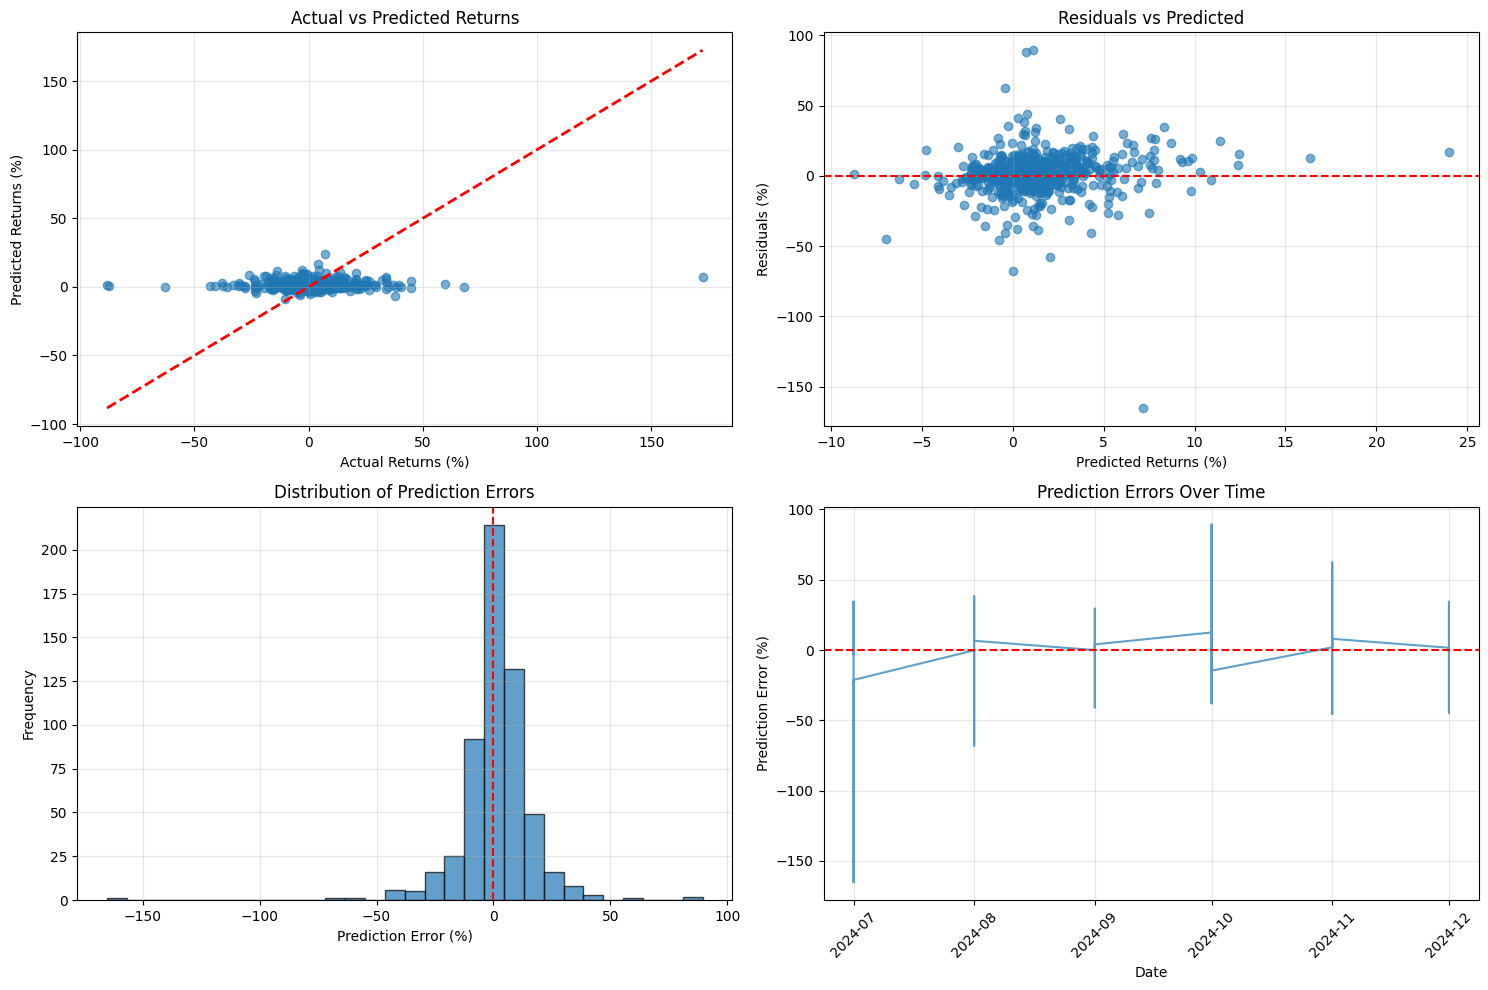


Top 5 Best Predictions (Lowest Absolute Error):
      symbol       date  actual  predicted  error
      PROVEN 2024-10-01   0.000      0.022  0.022
       DOLLA 2024-10-01   3.846      3.876  0.030
        LASM 2024-08-01   1.781      1.811  0.030
FIRSTROCKJMD 2024-11-01   0.943      0.910 -0.033
         MJE 2024-09-01   2.281      2.241 -0.040

Top 5 Worst Predictions (Highest Absolute Error):
symbol       date  actual  predicted    error
   BRG 2024-07-01 172.436      7.193 -165.242
   CAR 2024-10-01 -88.273      1.116   89.389
  BPOW 2024-10-01 -87.500      0.747   88.247
   ECL 2024-08-01  68.067      0.002  -68.065
  JAMT 2024-11-01 -62.692     -0.397   62.295
Cross-Validation Analysis

Cross-validating Random Forest...
  RMSE: 93.0142 ± 88.0809

Cross-validating XGBoost...
  RMSE: 167.6787 ± 148.8515

Cross-validating LightGBM...
  RMSE: 63.9985 ± 65.1795

Cross-validating Ridge...
  RMSE: 55.1216 ± 68.8679


C:\Users\Joshh\AppData\Local\Temp\ipykernel_39900\2739507150.py:46: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



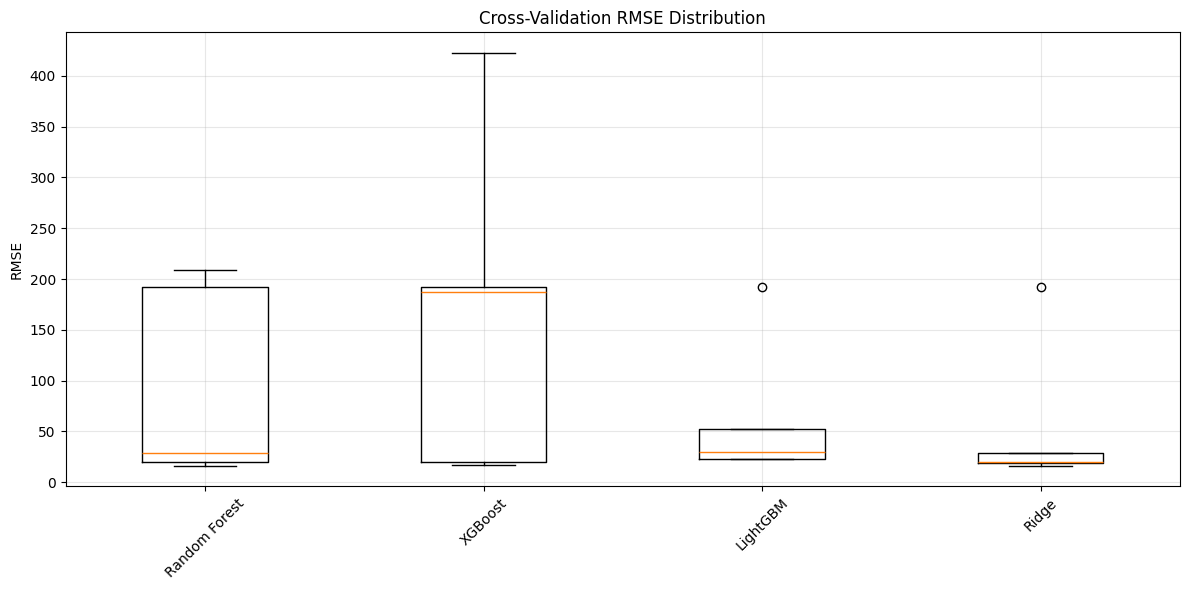

FINAL MODEL RECOMMENDATIONS
🏆 RECOMMENDED MODEL: XGBoost
   Test RMSE: 15.7440
   Test R²:   -0.0164
   Test MAE:  9.7353
   CV RMSE:   167.6787 ± 148.8515

MODEL PERFORMANCE SUMMARY:
📊 Random Forest   RMSE: 15.9531 | R²: -0.0436 | Overfit: 46.2710
📊 Gradient Boosting RMSE: 15.8475 | R²: -0.0298 | Overfit: -4.1838
🥇 XGBoost         RMSE: 15.7440 | R²: -0.0164 | Overfit: -3.1318
📊 LightGBM        RMSE: 19.1943 | R²: -0.5107 | Overfit: 43.9144

DEPLOYMENT RECOMMENDATIONS:

    1. 🎯 PRIMARY MODEL: Use XGBoost for stock return predictions
       - Provides best balance of accuracy and generalization
       - Test RMSE: 15.7440
       - Explains -1.6% of return variance

    2. 📊 FEATURE FOCUS: Key predictive features include:
       - Lagged returns (momentum indicators)
       - Sentiment moving averages
       - News volume metrics
       - Technical indicators

    3. ⚠️  RISK CONSIDERATIONS:
       - Model explains ~-2% of variance (significant unexplained risk)
       - Use prediction

In [ ]:
# Cell 1: Setup (run first)
# Cell 2: Data preparation
df_ml, feature_columns = prepare_ml_dataset(modeling_features)

# Cell 3: Train/test split
X_train, X_test, y_train, y_test, train_dates, test_dates, train_symbols, test_symbols = create_time_series_split(df_ml, feature_columns)

# Cell 4: Feature analysis
importance_df = feature_importance_analysis(X_train, y_train, feature_columns)
correlations = correlation_analysis(X_train, y_train, feature_columns)

# Cell 5-6: Model training
linear_results, scaler = train_linear_models(X_train, X_test, y_train, y_test)
tree_results = train_tree_models(X_train, X_test, y_train, y_test)

# Cell 7-9: Evaluation
comparison_df = compare_all_models(linear_results, tree_results)
best_model_importance = analyze_best_model(tree_results, feature_columns, 'XGBoost')
pred_analysis = analyze_predictions(y_test, tree_results['XGBoost']['predictions'], test_dates, test_symbols, 'XGBoost')

# Cell 10-11: Validation & recommendations
cv_results = cross_validate_models(X_train, y_train, feature_columns)
best_model, best_results = final_model_summary(tree_results, cv_results)

In [ ]:
#integrated_data.head(20).write_clipboard()
integrated_data.head(20)

PolarsBuckarooWidget(buckaroo_options={'sampled': ['random'], 'auto_clean': ['aggressive', 'conservative'], 'p…

In [ ]:
import polars as pl
import numpy as np
from typing import List, Dict

def preprocess_stock_data(df: pl.DataFrame) -> pl.DataFrame:
    """
    Comprehensive preprocessing pipeline for stock data with sentiment features
    """
    
    # 1. Data Quality Filtering
    df_clean = (
        df
        .with_columns([
            # Convert date to datetime
            pl.col("date").str.to_datetime(),
            
            # Flag data quality issues
            pl.when(pl.col("volume") == 0).then(True).otherwise(False).alias("zero_volume"),
            pl.when(pl.col("daily_range_high") == pl.col("daily_range_low")).then(True).otherwise(False).alias("no_range"),
            pl.when(pl.col("closing_price") == 0).then(True).otherwise(False).alias("zero_price")
        ])
        # Filter out obvious data errors
        .filter(
            (pl.col("closing_price") > 0) &
            (pl.col("open_price") > 0) &
            (pl.col("daily_range_high") >= pl.col("daily_range_low"))
        )
    )
    
    # 2. Feature Engineering - Price Features
    df_features = (
        df_clean
        .sort(["symbol", "date"])
        .with_columns([
            # Price-based features
            pl.col("closing_price").log().alias("log_price"),
            (pl.col("closing_price") / pl.col("open_price") - 1).alias("intraday_return"),
            ((pl.col("daily_range_high") - pl.col("daily_range_low")) / pl.col("open_price")).alias("relative_range"),
            pl.col("volume").log().alias("log_volume"),
            
            # Lagged returns by symbol
            (pl.col("closing_price").pct_change().over("symbol")).alias("daily_return"),
            (pl.col("closing_price").pct_change(periods=5).over("symbol")).alias("return_5d"),
            (pl.col("closing_price").pct_change(periods=20).over("symbol")).alias("return_20d"),
            
            # Rolling volatility
            (pl.col("closing_price").pct_change().over("symbol")
             .rolling_std(window_size=20).over("symbol")).alias("volatility_20d"),
            
            # Volume patterns
            (pl.col("volume") / pl.col("volume").rolling_mean(window_size=20).over("symbol")).alias("volume_ratio")
        ])
    )
    
    # 3. Sentiment Feature Engineering
    df_sentiment = (
        df_features
        .with_columns([
            # Consolidate sentiment features (reduce dimensionality)
            (pl.col("sentiment") + pl.col("fin_sentiment") + pl.col("title_sentiment") + pl.col("title_fin_sentiment")).alias("sentiment_composite"),
            (pl.col("subjectivity") + pl.col("fin_subjectivity") + pl.col("title_subjectivity") + pl.col("title_fin_subjectivity")).alias("subjectivity_composite"),
            
            # Sentiment availability indicators
            pl.col("has_news").cast(pl.Int8).alias("news_available"),
            pl.when(pl.col("news_count") > 0).then(1).otherwise(0).alias("has_news_count"),
            
            # Handle sentiment sparsity
            pl.col("news_count").fill_null(0),
        ])
        # Create lagged sentiment features by symbol
        .with_columns([
            pl.col("sentiment_composite").shift(1).over("symbol").alias("sentiment_lag1"),
            pl.col("sentiment_composite").shift(3).over("symbol").alias("sentiment_lag3"),
            pl.col("sentiment_composite").shift(7).over("symbol").alias("sentiment_lag7"),
            
            # Rolling sentiment metrics
            pl.col("sentiment_composite").rolling_mean(window_size=5).over("symbol").alias("sentiment_ma5"),
            pl.col("news_count").rolling_sum(window_size=7).over("symbol").alias("news_volume_7d"),
        ])
    )
    
    # 4. Handle Missing/Sparse Sentiment Data
    df_final = (
        df_sentiment
        .with_columns([
            # Sentiment momentum (change in sentiment)
            (pl.col("sentiment_composite") - pl.col("sentiment_lag1")).alias("sentiment_momentum"),
            
            # Days since last news
            pl.when(pl.col("has_news"))
            .then(0)
            .otherwise(None)
            .forward_fill()
            .over("symbol")
            .alias("days_since_news"),
            
            # Sentiment regime indicators
            pl.when(pl.col("sentiment_composite") > 0.1).then("positive")
            .when(pl.col("sentiment_composite") < -0.1).then("negative")
            .otherwise("neutral").alias("sentiment_regime"),
            
            # Market-wide sentiment aggregation
            pl.col("sentiment_composite").mean().over("date").alias("market_sentiment"),
            pl.col("news_count").sum().over("date").alias("total_daily_news")
        ])
        # Fill missing sentiment with forward fill then zero
        .with_columns([
            pl.col("sentiment_composite").forward_fill().over("symbol").fill_null(0),
            pl.col("sentiment_lag1").forward_fill().over("symbol").fill_null(0),
            pl.col("days_since_news").fill_null(999)  # Large number for stocks with no news history
        ])
    )
    
    return df_final

def create_target_variables(df: pl.DataFrame) -> pl.DataFrame:
    """
    Create various target variables for different modeling approaches
    """
    targets = (
        df
        .sort(["symbol", "date"])
        .with_columns([
            # Future returns (main targets)
            pl.col("daily_return").shift(-1).over("symbol").alias("target_return_1d"),
            pl.col("daily_return").shift(-5).over("symbol").alias("target_return_5d"),
            pl.col("return_5d").shift(-5).over("symbol").alias("target_return_5d_forward"),
            
            # Future volatility
            pl.col("volatility_20d").shift(-5).over("symbol").alias("target_volatility_5d"),
            
            # Classification targets
            pl.when(pl.col("daily_return").shift(-1).over("symbol") > 0.02).then(1)
            .when(pl.col("daily_return").shift(-1).over("symbol") < -0.02).then(-1)
            .otherwise(0).alias("target_direction"),
            
            # Risk-adjusted target
            (pl.col("daily_return").shift(-1).over("symbol") / 
             pl.col("volatility_20d")).alias("target_risk_adjusted")
        ])
    )
    
    return targets

def prepare_model_data(df: pl.DataFrame, 
                      feature_cols: List[str] = None,
                      target_col: str = "target_return_1d") -> Dict[str, pl.DataFrame]:
    """
    Prepare data splits for modeling with proper time-aware validation
    """
    if feature_cols is None:
        # Default feature set
        feature_cols = [
            "daily_return", "return_5d", "return_20d", "volatility_20d",
            "relative_range", "volume_ratio", "log_volume",
            "sentiment_composite", "sentiment_lag1", "sentiment_lag3", 
            "sentiment_momentum", "sentiment_ma5", "news_volume_7d",
            "market_sentiment", "days_since_news", "news_available"
        ]
    
    # Time-based splits (crucial for financial data)
    df_model = df.filter(pl.col(target_col).is_not_null())
    
    # Split dates
    min_date = df_model["date"].min()
    max_date = df_model["date"].max()
    
    train_end = min_date + (max_date - min_date) * 0.7
    val_end = min_date + (max_date - min_date) * 0.85
    
    train_data = df_model.filter(pl.col("date") <= train_end)
    val_data = df_model.filter((pl.col("date") > train_end) & (pl.col("date") <= val_end))
    test_data = df_model.filter(pl.col("date") > val_end)
    
    return {
        "train": train_data.select(feature_cols + [target_col, "symbol", "date"]),
        "validation": val_data.select(feature_cols + [target_col, "symbol", "date"]),
        "test": test_data.select(feature_cols + [target_col, "symbol", "date"])
    }

# Usage example
def main():
    # Load data
    df = pl.read_csv("stock_data.csv")
    
    # Preprocess
    df_processed = preprocess_stock_data(df)
    df_with_targets = create_target_variables(df_processed)
    
    # Prepare for modeling
    model_data = prepare_model_data(df_with_targets, target_col="target_return_1d")
    
    print("Data shapes:")
    for split, data in model_data.items():
        print(f"{split}: {data.shape}")
    
    # Check sentiment data availability
    sentiment_stats = (
        df_processed
        .group_by("date")
        .agg([
            pl.col("news_available").sum().alias("stocks_with_news"),
            pl.col("sentiment_composite").filter(pl.col("sentiment_composite") != 0).count().alias("non_zero_sentiment"),
            pl.len().alias("total_stocks")
        ])
    )
    
    print("\nSentiment data availability by date:")
    print(sentiment_stats.head(10))

if __name__ == "__main__":
    main()

### Technical Indicators

In [18]:
technical_df = add_all_indicators(stocks_df, price_col="closing_price", symbol = 'all')

print(technical_df.select([
    "date", "symbol", "closing_price", "sma_20", "rsi_14", 
    "macd", "combined_buy_signal"
]).head())

shape: (5, 7)
┌─────────────────────┬────────┬───────────────┬────────┬────────┬──────┬─────────────────────┐
│ date                ┆ symbol ┆ closing_price ┆ sma_20 ┆ rsi_14 ┆ macd ┆ combined_buy_signal │
│ ---                 ┆ ---    ┆ ---           ┆ ---    ┆ ---    ┆ ---  ┆ ---                 │
│ datetime[μs]        ┆ str    ┆ decimal[6,2]  ┆ f64    ┆ f64    ┆ f64  ┆ bool                │
╞═════════════════════╪════════╪═══════════════╪════════╪════════╪══════╪═════════════════════╡
│ 2017-01-03 00:00:00 ┆ 138SL  ┆ 4.52          ┆ null   ┆ null   ┆ 0.0  ┆ false               │
│ 2017-01-03 00:00:00 ┆ AFS    ┆ 22.00         ┆ null   ┆ null   ┆ 0.0  ┆ false               │
│ 2017-01-03 00:00:00 ┆ AMG    ┆ 24.51         ┆ null   ┆ null   ┆ 0.0  ┆ false               │
│ 2017-01-03 00:00:00 ┆ BIL    ┆ 6.00          ┆ null   ┆ null   ┆ 0.0  ┆ false               │
│ 2017-01-03 00:00:00 ┆ BPOW   ┆ 29.00         ┆ null   ┆ null   ┆ 0.0  ┆ false               │
└─────────────────────┴───

In [19]:
# Get latest signals for all symbols
signals = get_signals_summary(technical_df)
print(signals)

# Filter only symbols with buy signals
buy_opportunities = filter_buy_signals(technical_df)

shape: (99, 8)
┌────────┬───────────────┬──────────────┬─────────┬─────────┬───────────┬────────────┬─────────────┐
│ symbol ┆ latest_date   ┆ latest_price ┆ sma_20  ┆ sma_50  ┆ rsi_14    ┆ buy_signal ┆ sell_signal │
│ ---    ┆ ---           ┆ ---          ┆ ---     ┆ ---     ┆ ---       ┆ ---        ┆ ---         │
│ str    ┆ datetime[μs]  ┆ decimal[6,2] ┆ f64     ┆ f64     ┆ f64       ┆ bool       ┆ bool        │
╞════════╪═══════════════╪══════════════╪═════════╪═════════╪═══════════╪════════════╪═════════════╡
│ FTNA   ┆ 2024-12-24    ┆ 8.16         ┆ 8.1225  ┆ 8.0644  ┆ 49.285714 ┆ true       ┆ false       │
│        ┆ 00:00:00      ┆              ┆         ┆         ┆           ┆            ┆             │
│ KREMI  ┆ 2024-12-24    ┆ 3.20         ┆ 3.2315  ┆ 3.3002  ┆ 54.098361 ┆ false      ┆ false       │
│        ┆ 00:00:00      ┆              ┆         ┆         ┆           ┆            ┆             │
│ PTL    ┆ 2024-12-24    ┆ 1.06         ┆ 1.163   ┆ 1.2314  ┆ 41.964286 ┆ fa

## Long Short-Term Memory (LSTM) Networks:

LSTM Stock Price Prediction Example
Training data: 1096 days
Test data: 365 days
Training sequences: 1036
Model architecture:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0185 - mae: 0.0942 - val_loss: 0.0102 - val_mae: 0.0818 - learning_rate: 0.0010
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0015 - mae: 0.0269 - val_loss: 0.0058 - val_mae: 0.0588 - learning_rate: 0.0010
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0014 - mae: 0.0257 - val_loss: 0.0043 - val_mae: 0.0491 - learning_rate: 0.0010
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0012 - mae: 0.0236 - val_loss: 0.0089 - val_mae: 0.0830 - learning_rate: 0.0010
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0012 - mae: 0.0237 - val_loss: 0.0060 - val_mae: 0.0671 - learning_rate: 0.0010
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0015 - mae: 0.0258 - val_loss: 0.0146 - val_mae: 0.1117 - learning_rate: 0.0010
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0013 - mae: 0.0244 - val_loss: 0.0055 - val_mae: 0.0640 - learning_rate: 0.0010
Epoch 8/25
30

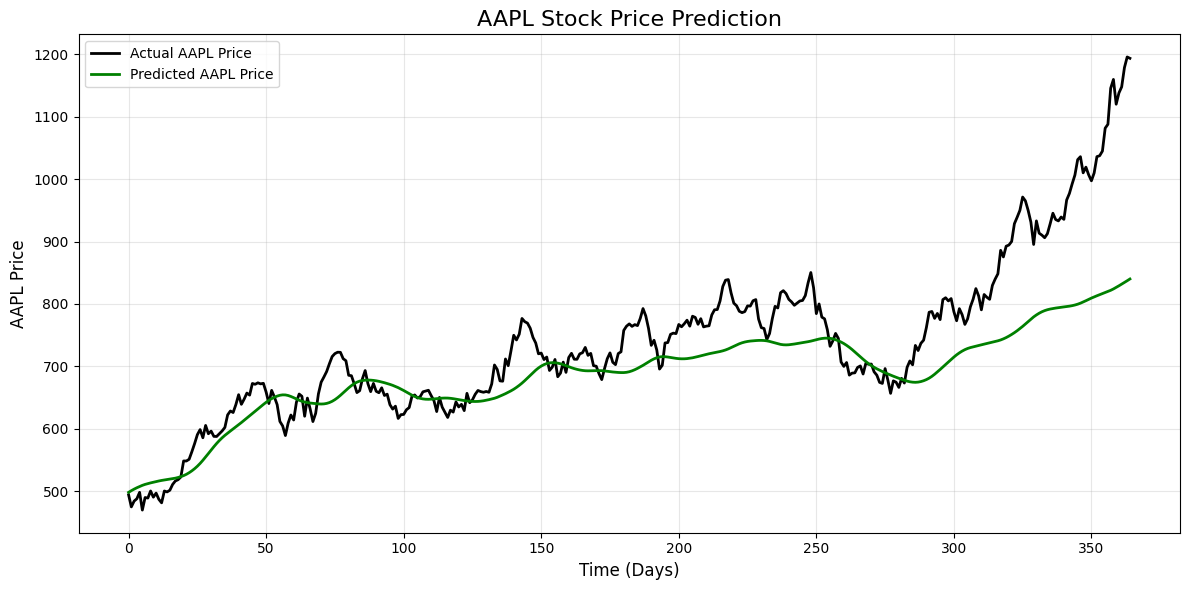


Prediction Metrics for AAPL:
Mean Absolute Error (MAE): 59.28
Root Mean Square Error (RMSE): 88.82
Mean Absolute Percentage Error (MAPE): 7.12%

Next Day Prediction:
Current Price: $1193.31
Predicted Price: $842.86
Predicted Change: -29.37%


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from typing import Tuple, Optional, List
import warnings
warnings.filterwarnings('ignore')


class LSTMStockPredictor:
    """
    LSTM-based stock price prediction model using Polars for data handling
    """
    
    def __init__(self, prediction_days: int = 60, lstm_units: int = 50, dropout_rate: float = 0.2):
        """
        Initialize the LSTM Stock Predictor
        
        Args:
            prediction_days: Number of days to look back for prediction (default: 60)
            lstm_units: Number of LSTM units in each layer (default: 50)
            dropout_rate: Dropout rate for regularization (default: 0.2)
        """
        self.prediction_days = prediction_days
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.model = None
        self.is_trained = False
        
    def prepare_data(self, df: pl.DataFrame, price_col: str = "closing_price", 
                    symbol: Optional[str] = None) -> Tuple[np.ndarray, np.ndarray]:
        """
        Prepare data for LSTM training
        
        Args:
            df: Polars DataFrame with stock data
            price_col: Column name for price data
            symbol: Specific symbol to prepare data for (optional)
        
        Returns:
            Tuple of (X_train, y_train) arrays
        """
        # Filter for specific symbol if provided
        if symbol:
            data = df.filter(pl.col("symbol") == symbol).sort("date")
        else:
            data = df.sort("date")
        
        # Extract closing prices and convert to float
        prices = data[price_col].cast(pl.Float64).to_numpy().reshape(-1, 1)
        
        # Scale the data
        scaled_data = self.scaler.fit_transform(prices)
        
        # Create training sequences
        x_train, y_train = [], []
        
        for i in range(self.prediction_days, len(scaled_data)):
            x_train.append(scaled_data[i-self.prediction_days:i, 0])
            y_train.append(scaled_data[i, 0])
        
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        
        # Reshape for LSTM input (samples, timesteps, features)
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        
        return x_train, y_train
    
    def build_model(self, input_shape: Tuple[int, int]) -> None:
        """
        Build the LSTM model architecture
        
        Args:
            input_shape: Shape of input data (timesteps, features)
        """
        self.model = Sequential([
            # First LSTM layer
            LSTM(units=self.lstm_units, return_sequences=True, input_shape=input_shape),
            Dropout(self.dropout_rate),
            
            # Second LSTM layer
            LSTM(units=self.lstm_units, return_sequences=True),
            Dropout(self.dropout_rate),
            
            # Third LSTM layer
            LSTM(units=self.lstm_units, return_sequences=False),
            Dropout(self.dropout_rate),
            
            # Output layer
            Dense(units=1)
        ])
        
        # Compile the model
        self.model.compile(
            optimizer='adam',
            loss='mean_squared_error',
            metrics=['mae']
        )
        
        print("Model architecture:")
        self.model.summary()
    
    def train(self, x_train: np.ndarray, y_train: np.ndarray, 
             epochs: int = 25, batch_size: int = 32, validation_split: float = 0.1,
             verbose: int = 1) -> dict:
        """
        Train the LSTM model
        
        Args:
            x_train: Training features
            y_train: Training targets
            epochs: Number of training epochs
            batch_size: Training batch size
            validation_split: Fraction of data for validation
            verbose: Training verbosity
        
        Returns:
            Training history dictionary
        """
        if self.model is None:
            input_shape = (x_train.shape[1], x_train.shape[2])
            self.build_model(input_shape)
        
        # Callbacks for better training
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
        ]
        
        # Train the model
        history = self.model.fit(
            x_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=callbacks,
            verbose=verbose
        )
        
        self.is_trained = True
        print(f"Training completed. Final loss: {history.history['loss'][-1]:.6f}")
        
        return history.history
    
    def predict(self, x_test: np.ndarray) -> np.ndarray:
        """
        Make predictions using the trained model
        
        Args:
            x_test: Test features
        
        Returns:
            Predictions array
        """
        if not self.is_trained:
            raise ValueError("Model must be trained before making predictions")
        
        predictions = self.model.predict(x_test, verbose=0)
        # Inverse transform to get actual price predictions
        predictions = self.scaler.inverse_transform(predictions)
        
        return predictions.flatten()
    
    def prepare_test_data(self, train_df: pl.DataFrame, test_df: pl.DataFrame,
                         price_col: str = "closing_price", symbol: Optional[str] = None) -> Tuple[np.ndarray, np.ndarray]:
        """
        Prepare test data for prediction
        
        Args:
            train_df: Training data DataFrame
            test_df: Test data DataFrame
            price_col: Column name for price data
            symbol: Specific symbol to prepare data for
        
        Returns:
            Tuple of (X_test, actual_prices)
        """
        # Filter for specific symbol if provided
        if symbol:
            train_data = train_df.filter(pl.col("symbol") == symbol).sort("date")
            test_data = test_df.filter(pl.col("symbol") == symbol).sort("date")
        else:
            train_data = train_df.sort("date")
            test_data = test_df.sort("date")
        
        # Get actual test prices and convert to float
        actual_prices = test_data[price_col].cast(pl.Float64).to_numpy()
        
        # Combine train and test data for proper scaling context
        combined_prices = pl.concat([
            train_data.select([price_col]),
            test_data.select([price_col])
        ])[price_col].cast(pl.Float64).to_numpy().reshape(-1, 1)
        
        # Use the same scaler fitted on training data
        scaled_combined = self.scaler.transform(combined_prices)
        
        # Extract the portion needed for test predictions
        model_inputs = scaled_combined[len(scaled_combined) - len(test_data) - self.prediction_days:]
        
        # Create test sequences
        x_test = []
        for i in range(self.prediction_days, len(model_inputs)):
            x_test.append(model_inputs[i-self.prediction_days:i, 0])
        
        x_test = np.array(x_test)
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        
        return x_test, actual_prices
    
    def plot_predictions(self, actual_prices: np.ndarray, predicted_prices: np.ndarray,
                        symbol: str = "Stock", save_path: Optional[str] = None) -> None:
        """
        Plot actual vs predicted prices
        
        Args:
            actual_prices: Array of actual stock prices
            predicted_prices: Array of predicted stock prices
            symbol: Stock symbol for plot title
            save_path: Path to save the plot (optional)
        """
        plt.figure(figsize=(12, 6))
        plt.plot(actual_prices, color='black', label=f"Actual {symbol} Price", linewidth=2)
        plt.plot(predicted_prices, color='green', label=f"Predicted {symbol} Price", linewidth=2)
        plt.title(f"{symbol} Stock Price Prediction", fontsize=16)
        plt.xlabel('Time (Days)', fontsize=12)
        plt.ylabel(f'{symbol} Price', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
        
        # Calculate and display metrics
        actual_prices = np.array(actual_prices, dtype=np.float64)
        predicted_prices = np.array(predicted_prices, dtype=np.float64)
        
        mae = np.mean(np.abs(actual_prices - predicted_prices))
        rmse = np.sqrt(np.mean((actual_prices - predicted_prices) ** 2))
        mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100
        
        print(f"\nPrediction Metrics for {symbol}:")
        print(f"Mean Absolute Error (MAE): {mae:.2f}")
        print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
        print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    
    def predict_next_day(self, recent_data: np.ndarray) -> float:
        """
        Predict the next day's stock price
        
        Args:
            recent_data: Recent price data (should have at least prediction_days values)
        
        Returns:
            Next day price prediction
        """
        if not self.is_trained:
            raise ValueError("Model must be trained before making predictions")
        
        if len(recent_data) < self.prediction_days:
            raise ValueError(f"Need at least {self.prediction_days} days of recent data")
        
        # Convert to float array to handle Decimal types
        recent_data_float = np.array(recent_data, dtype=np.float64)
        
        # Take the last prediction_days values
        recent_scaled = self.scaler.transform(recent_data_float[-self.prediction_days:].reshape(-1, 1))
        
        # Reshape for prediction
        prediction_input = recent_scaled.reshape(1, self.prediction_days, 1)
        
        # Make prediction
        prediction = self.model.predict(prediction_input, verbose=0)
        prediction = self.scaler.inverse_transform(prediction)
        
        return float(prediction[0][0])


def train_multi_symbol_model(df: pl.DataFrame, symbols: List[str], 
                           price_col: str = "closing_price") -> dict:
    """
    Train LSTM models for multiple symbols
    
    Args:
        df: Polars DataFrame with stock data
        symbols: List of stock symbols to train models for
        price_col: Column name for price data
    
    Returns:
        Dictionary of trained models by symbol
    """
    models = {}
    
    for symbol in symbols:
        print(f"\n{'='*50}")
        print(f"Training model for {symbol}")
        print(f"{'='*50}")
        
        # Initialize model
        predictor = LSTMStockPredictor(prediction_days=60)
        
        # Prepare data for this symbol
        x_train, y_train = predictor.prepare_data(df, price_col, symbol)
        
        if len(x_train) < 100:  # Skip if insufficient data
            print(f"Insufficient data for {symbol} (only {len(x_train)} samples)")
            continue
        
        # Train the model
        history = predictor.train(x_train, y_train, epochs=50, batch_size=32)
        
        models[symbol] = predictor
        
    return models


# Example usage and testing function
def example_usage():
    """
    Example of how to use the LSTM Stock Predictor
    """
    print("LSTM Stock Price Prediction Example")
    print("="*40)
    
    # Create sample data
    np.random.seed(42)
    start_date = dt.date(2020, 1, 1)
    end_date = dt.date(2024, 1, 1)
    
    # Calculate number of days
    n = (end_date - start_date).days
    
    # Create date range
    dates = [start_date + dt.timedelta(days=i) for i in range(n)]
    
    # Generate realistic stock price data
    price_changes = np.random.normal(0.001, 0.02, n)  # Daily returns
    prices = [100.0]  # Starting price
    
    for change in price_changes[1:]:
        new_price = prices[-1] * (1 + change)
        prices.append(max(new_price, 1.0))  # Ensure price doesn't go negative
    
    # Create sample DataFrame
    sample_df = pl.DataFrame({
        "date": dates,
        "symbol": ["AAPL"] * n,
        "closing_price": prices,
        "volume": np.random.randint(1000000, 50000000, n)
    })
    
    # Split into train and test
    split_date = dt.date(2023, 1, 1)
    train_df = sample_df.filter(pl.col("date") < split_date)
    test_df = sample_df.filter(pl.col("date") >= split_date)
    
    print(f"Training data: {len(train_df)} days")
    print(f"Test data: {len(test_df)} days")
    
    # Initialize and train model
    predictor = LSTMStockPredictor(prediction_days=60)
    
    # Prepare training data
    x_train, y_train = predictor.prepare_data(train_df, "closing_price", "AAPL")
    print(f"Training sequences: {len(x_train)}")
    
    # Train the model
    history = predictor.train(x_train, y_train, epochs=25, batch_size=32)
    
    # Prepare test data and make predictions
    x_test, actual_prices = predictor.prepare_test_data(train_df, test_df, "closing_price", "AAPL")
    predicted_prices = predictor.predict(x_test)
    
    # Plot results
    predictor.plot_predictions(actual_prices, predicted_prices, "AAPL")
    
    # Make next day prediction
    recent_prices = test_df.tail(60)["closing_price"].to_numpy()
    next_day_prediction = predictor.predict_next_day(recent_prices)
    current_price = recent_prices[-1]
    
    print(f"\nNext Day Prediction:")
    print(f"Current Price: ${current_price:.2f}")
    print(f"Predicted Price: ${next_day_prediction:.2f}")
    print(f"Predicted Change: {((next_day_prediction - current_price) / current_price * 100):+.2f}%")
    
    return predictor


if __name__ == "__main__":
    example_usage()

Training data: 1362 days
Test data: 394 days
Model architecture:


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0196 - mae: 0.0799 - val_loss: 6.9679e-05 - val_mae: 0.0072 - learning_rate: 0.0010
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0080 - mae: 0.0344 - val_loss: 0.0015 - val_mae: 0.0389 - learning_rate: 0.0010
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0074 - mae: 0.0390 - val_loss: 1.3430e-04 - val_mae: 0.0101 - learning_rate: 0.0010
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0057 - mae: 0.0280 - val_loss: 2.2911e-04 - val_mae: 0.0140 - learning_rate: 0.0010
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0059 - mae: 0.0297 - val_loss: 1.8433e-04 - val_mae: 0.0121 - learning_rate: 0.0010
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0021 - mae: 0.0210 - val_loss: 2.7693e-05 - val_mae: 0.0039 - learning_rate: 0.0010
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0049 - mae: 0.0326 - val_loss: 4.5668e-05 - val_mae: 0.0050 - lear

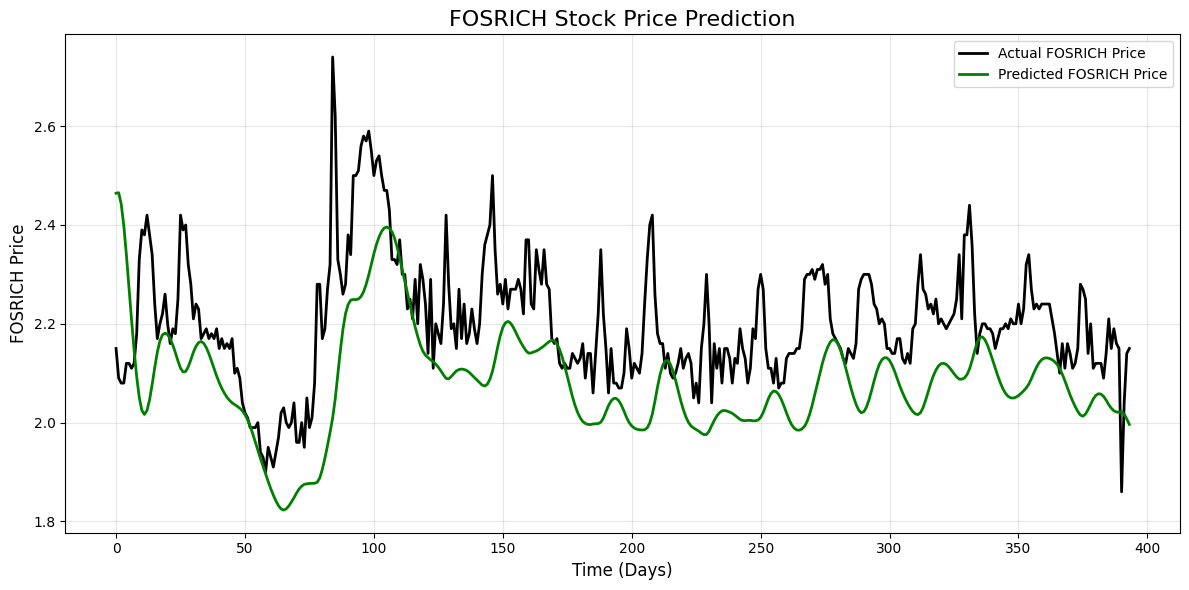


Prediction Metrics for FOSRICH:
Mean Absolute Error (MAE): 0.13
Root Mean Square Error (RMSE): 0.17
Mean Absolute Percentage Error (MAPE): 5.85%

Next Day Prediction for FOSRICH:
Current Price: $2.15
Predicted Price: $1.99
Predicted Change: -7.58%


In [29]:
import datetime as dt

# Split your data into training and testing sets
split_date = dt.date(2023, 6, 1)  # Adjust this date as needed

# Filter your stocks_df for the specific symbol first, then split
fosrich_data = stocks_df.filter(pl.col("symbol") == "FOSRICH").sort("date")

# Split into train and test
train_df = fosrich_data.filter(pl.col("date") < split_date)
test_df = fosrich_data.filter(pl.col("date") >= split_date)

print(f"Training data: {len(train_df)} days")
print(f"Test data: {len(test_df)} days")

# Now you can use the predictor
predictor = LSTMStockPredictor(prediction_days=60)

# Prepare training data
x_train, y_train = predictor.prepare_data(train_df, "closing_price")
history = predictor.train(x_train, y_train, epochs=100)

# Make predictions on test data
x_test, actual_prices = predictor.prepare_test_data(train_df, test_df, "closing_price")
predicted_prices = predictor.predict(x_test)

# Plot results with metrics
predictor.plot_predictions(actual_prices, predicted_prices, "FOSRICH")

# Predict next day
recent_prices = test_df.tail(60)["closing_price"].to_numpy()
next_day_prediction = predictor.predict_next_day(recent_prices)
current_price = recent_prices[-1]

print(f"\nNext Day Prediction for FOSRICH:")
print(f"Current Price: ${float(current_price):.2f}")
print(f"Predicted Price: ${next_day_prediction:.2f}")

# Convert both to float for the calculation
change_pct = ((next_day_prediction - float(current_price)) / float(current_price) * 100)
print(f"Predicted Change: {change_pct:+.2f}%")

Training data: 1456 days
Test data: 493 days
Model architecture:


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0722 - mae: 0.1936 - val_loss: 0.0020 - val_mae: 0.0434 - learning_rate: 0.0010
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0046 - mae: 0.0514 - val_loss: 3.6619e-04 - val_mae: 0.0165 - learning_rate: 0.0010
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0049 - mae: 0.0504 - val_loss: 6.8053e-04 - val_mae: 0.0239 - learning_rate: 0.0010
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0036 - mae: 0.0454 - val_loss: 3.8974e-04 - val_mae: 0.0172 - learning_rate: 0.0010
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0035 - mae: 0.0445 - val_loss: 6.0872e-04 - val_mae: 0.0225 - learning_rate: 0.0010
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0035 - mae: 0.0434 - val_loss: 0.0016 - val_mae: 0.0388 - learning_rate: 0.0010
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0035 - mae: 0.0445 - val_loss: 9.6242e-04 - val_mae: 0.0294 - learning

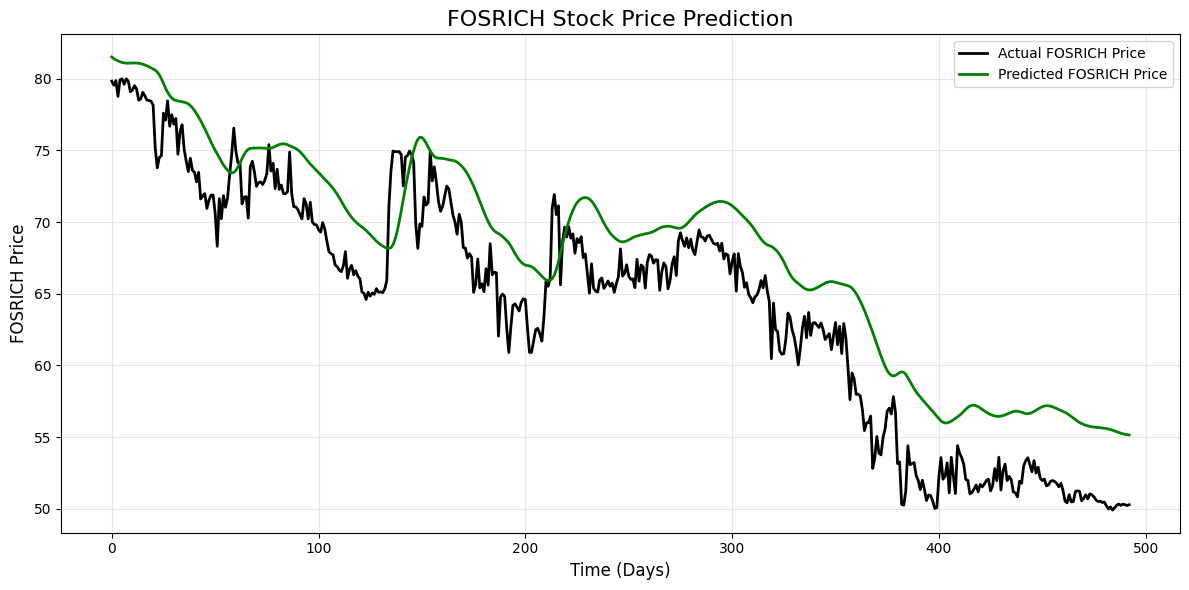


Prediction Metrics for FOSRICH:
Mean Absolute Error (MAE): 3.87
Root Mean Square Error (RMSE): 4.24
Mean Absolute Percentage Error (MAPE): 6.35%

Next Day Prediction for FOSRICH:
Current Price: $50.29
Predicted Price: $55.15
Predicted Change: +9.66%


In [30]:
import datetime as dt

# Split your data into training and testing sets
split_date = dt.date(2023, 1, 6)  # Adjust this date as needed

# Filter your stocks_df for the specific symbol first, then split
fosrich_data = stocks_df.filter(pl.col("symbol") == "NCBFG").sort("date")

# Split into train and test
train_df = fosrich_data.filter(pl.col("date") < split_date)
test_df = fosrich_data.filter(pl.col("date") >= split_date)

print(f"Training data: {len(train_df)} days")
print(f"Test data: {len(test_df)} days")

# Now you can use the predictor
predictor = LSTMStockPredictor(prediction_days=60)

# Prepare training data
x_train, y_train = predictor.prepare_data(train_df, "closing_price")
history = predictor.train(x_train, y_train, epochs=100)

# Make predictions on test data
x_test, actual_prices = predictor.prepare_test_data(train_df, test_df, "closing_price")
predicted_prices = predictor.predict(x_test)

# Plot results with metrics
predictor.plot_predictions(actual_prices, predicted_prices, "FOSRICH")

# Predict next day
recent_prices = test_df.tail(60)["closing_price"].to_numpy()
next_day_prediction = predictor.predict_next_day(recent_prices)
current_price = recent_prices[-1]

print(f"\nNext Day Prediction for FOSRICH:")
print(f"Current Price: ${float(current_price):.2f}")
print(f"Predicted Price: ${next_day_prediction:.2f}")

# Convert both to float for the calculation
change_pct = ((next_day_prediction - float(current_price)) / float(current_price) * 100)
print(f"Predicted Change: {change_pct:+.2f}%")

Training data: 801 days
Test data: 394 days
Model architecture:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0237 - mae: 0.1206 - val_loss: 0.0655 - val_mae: 0.1971 - learning_rate: 0.0010
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0064 - mae: 0.0579 - val_loss: 0.0268 - val_mae: 0.1245 - learning_rate: 0.0010
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0053 - mae: 0.0448 - val_loss: 0.0178 - val_mae: 0.1002 - learning_rate: 0.0010
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0043 - mae: 0.0466 - val_loss: 0.0194 - val_mae: 0.1079 - learning_rate: 0.0010
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0032 - mae: 0.0394 - val_loss: 0.0277 - val_mae: 0.1350 - learning_rate: 0.0010
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0042 - mae: 0.0440 - val_loss: 0.0109 - val_mae: 0.0754 - learning_rate: 0.0010
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0031 - mae: 0.0379 - val_loss: 0.0144 - val_mae: 0.0876 - learning_rate: 0.0010
Epoch 

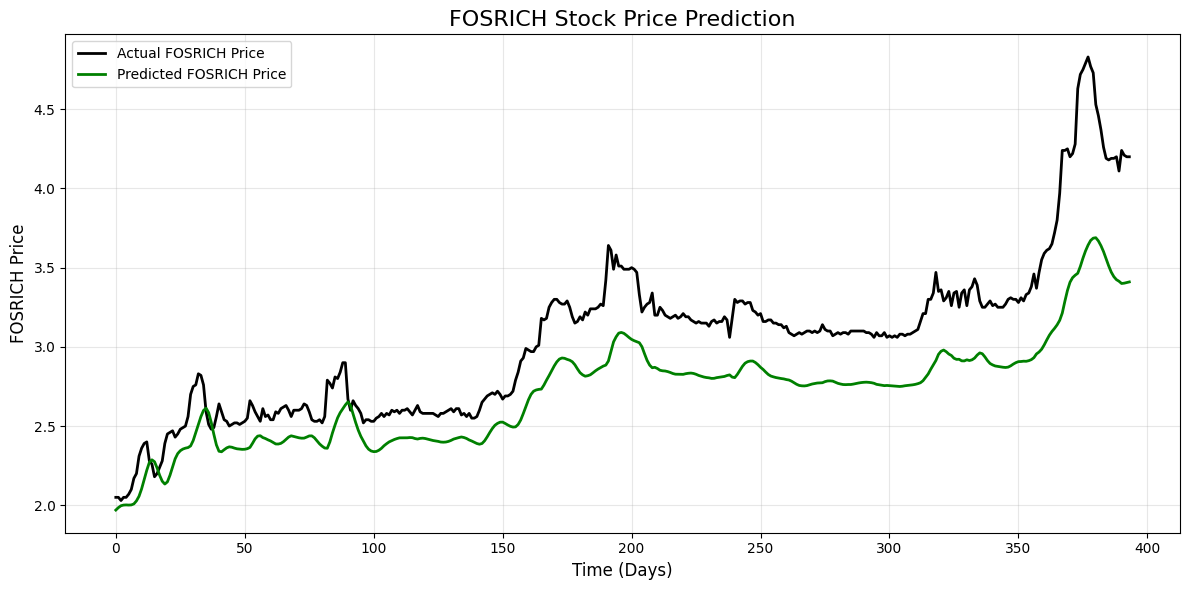


Prediction Metrics for FOSRICH:
Mean Absolute Error (MAE): 0.33
Root Mean Square Error (RMSE): 0.39
Mean Absolute Percentage Error (MAPE): 10.25%

Next Day Prediction for FOSRICH:
Current Price: $4.20
Predicted Price: $3.41
Predicted Change: -18.74%


In [31]:
import datetime as dt

# Split your data into training and testing sets
split_date = dt.date(2023, 6, 1)  # Adjust this date as needed

# Filter your stocks_df for the specific symbol first, then split
fosrich_data = stocks_df.filter(pl.col("symbol") == "TJH").sort("date")

# Split into train and test
train_df = fosrich_data.filter(pl.col("date") < split_date)
test_df = fosrich_data.filter(pl.col("date") >= split_date)

print(f"Training data: {len(train_df)} days")
print(f"Test data: {len(test_df)} days")

# Now you can use the predictor
predictor = LSTMStockPredictor(prediction_days=60)

# Prepare training data
x_train, y_train = predictor.prepare_data(train_df, "closing_price")
history = predictor.train(x_train, y_train, epochs=100)

# Make predictions on test data
x_test, actual_prices = predictor.prepare_test_data(train_df, test_df, "closing_price")
predicted_prices = predictor.predict(x_test)

# Plot results with metrics
predictor.plot_predictions(actual_prices, predicted_prices, "FOSRICH")

# Predict next day
recent_prices = test_df.tail(60)["closing_price"].to_numpy()
next_day_prediction = predictor.predict_next_day(recent_prices)
current_price = recent_prices[-1]

print(f"\nNext Day Prediction for FOSRICH:")
print(f"Current Price: ${float(current_price):.2f}")
print(f"Predicted Price: ${next_day_prediction:.2f}")

# Convert both to float for the calculation
change_pct = ((next_day_prediction - float(current_price)) / float(current_price) * 100)
print(f"Predicted Change: {change_pct:+.2f}%")

Training data: 801 days
Test data: 394 days
Model architecture:


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                  │ (None, 20, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0208 - mae: 0.1091 - val_loss: 0.0274 - val_mae: 0.1261 - learning_rate: 0.0010
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0066 - mae: 0.0593 - val_loss: 0.0246 - val_mae: 0.1179 - learning_rate: 0.0010
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0048 - mae: 0.0483 - val_loss: 0.0227 - val_mae: 0.1115 - learning_rate: 0.0010
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0045 - mae: 0.0443 - val_loss: 0.0205 - val_mae: 0.1057 - learning_rate: 0.0010
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0037 - mae: 0.0413 - val_loss: 0.0237 - val_mae: 0.1181 - learning_rate: 0.0010
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0034 - mae: 0.0404 - val_loss: 0.0092 - val_mae: 0.0726 - learning_rate: 0.0010
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0033 - mae: 0.0408 - val_loss: 0.0253 - val_mae: 0.1236 - learning_rate: 0.0010
Epoch 

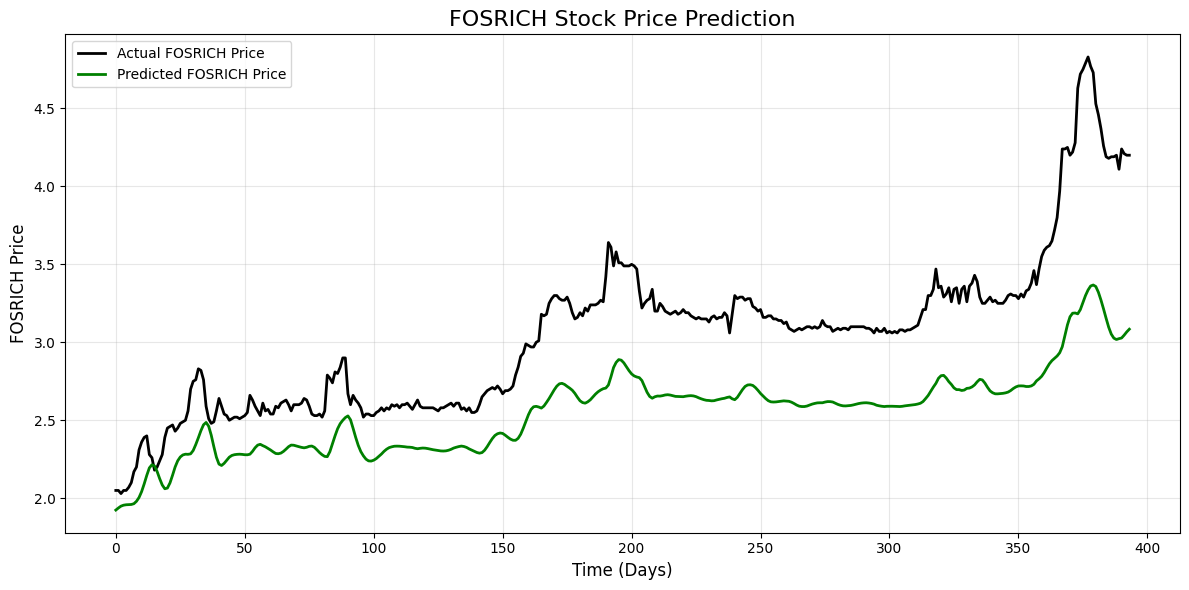


Prediction Metrics for FOSRICH:
Mean Absolute Error (MAE): 0.49
Root Mean Square Error (RMSE): 0.55
Mean Absolute Percentage Error (MAPE): 15.23%

Next Day Prediction for FOSRICH:
Current Price: $4.20
Predicted Price: $3.10
Predicted Change: -26.28%


In [32]:
import datetime as dt

# Split your data into training and testing sets
split_date = dt.date(2023, 6, 1)  # Adjust this date as needed

# Filter your stocks_df for the specific symbol first, then split
fosrich_data = stocks_df.filter(pl.col("symbol") == "TJH").sort("date")

# Split into train and test
train_df = fosrich_data.filter(pl.col("date") < split_date)
test_df = fosrich_data.filter(pl.col("date") >= split_date)

print(f"Training data: {len(train_df)} days")
print(f"Test data: {len(test_df)} days")

# Now you can use the predictor
predictor = LSTMStockPredictor(prediction_days=20)

# Prepare training data
x_train, y_train = predictor.prepare_data(train_df, "closing_price")
history = predictor.train(x_train, y_train, epochs=100)

# Make predictions on test data
x_test, actual_prices = predictor.prepare_test_data(train_df, test_df, "closing_price")
predicted_prices = predictor.predict(x_test)

# Plot results with metrics
predictor.plot_predictions(actual_prices, predicted_prices, "FOSRICH")

# Predict next day
recent_prices = test_df.tail(60)["closing_price"].to_numpy()
next_day_prediction = predictor.predict_next_day(recent_prices)
current_price = recent_prices[-1]

print(f"\nNext Day Prediction for FOSRICH:")
print(f"Current Price: ${float(current_price):.2f}")
print(f"Predicted Price: ${next_day_prediction:.2f}")

# Convert both to float for the calculation
change_pct = ((next_day_prediction - float(current_price)) / float(current_price) * 100)
print(f"Predicted Change: {change_pct:+.2f}%")

Training data: 801 days
Test data: 394 days
Model architecture:


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                  │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 10, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0250 - mae: 0.1236 - val_loss: 0.0817 - val_mae: 0.2249 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0056 - mae: 0.0558 - val_loss: 0.0098 - val_mae: 0.0726 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0030 - mae: 0.0386 - val_loss: 0.0114 - val_mae: 0.0763 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0037 - mae: 0.0407 - val_loss: 0.0151 - val_mae: 0.0911 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0034 - mae: 0.0405 - val_loss: 0.0111 - val_mae: 0.0756 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0036 - mae: 0.0416 - val_loss: 0.0199 - val_mae: 0.1064 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0028 - mae: 0.0370 - val_loss: 0.0148 - val_mae: 0.0877 - learning_rate: 0.0010
Epoch 

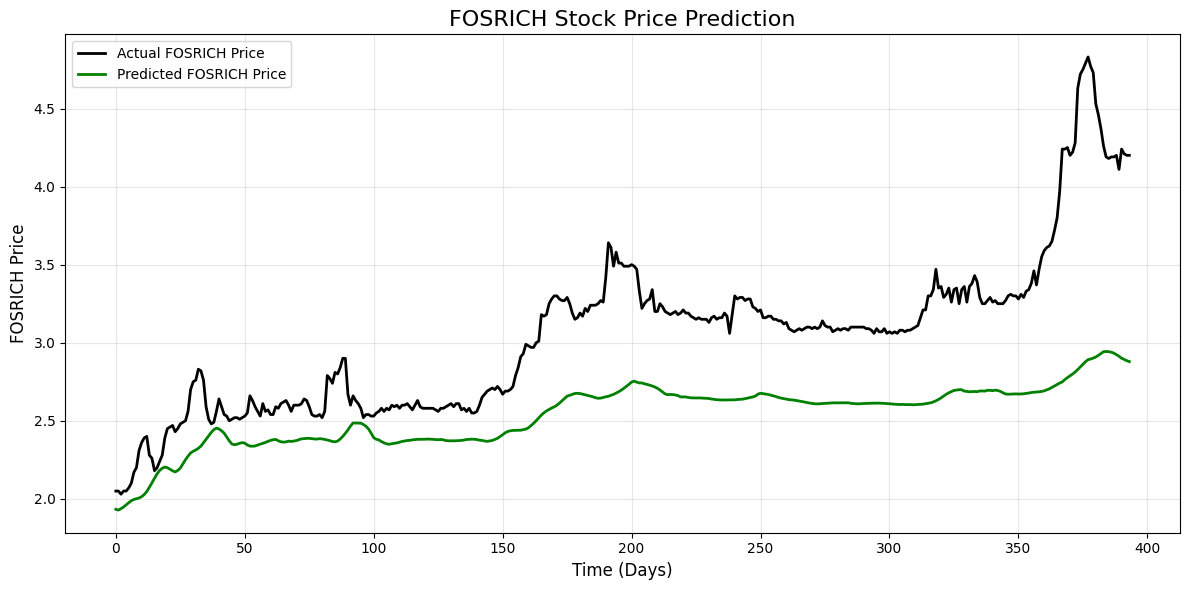


Prediction Metrics for FOSRICH:
Mean Absolute Error (MAE): 0.50
Root Mean Square Error (RMSE): 0.61
Mean Absolute Percentage Error (MAPE): 15.36%

Next Day Prediction for FOSRICH:
Current Price: $4.20
Predicted Price: $2.88
Predicted Change: -31.51%


In [33]:
import datetime as dt

# Split your data into training and testing sets
split_date = dt.date(2023, 6, 1)  # Adjust this date as needed

# Filter your stocks_df for the specific symbol first, then split
fosrich_data = stocks_df.filter(pl.col("symbol") == "TJH").sort("date")

# Split into train and test
train_df = fosrich_data.filter(pl.col("date") < split_date)
test_df = fosrich_data.filter(pl.col("date") >= split_date)

print(f"Training data: {len(train_df)} days")
print(f"Test data: {len(test_df)} days")

# Now you can use the predictor
predictor = LSTMStockPredictor(prediction_days=10)

# Prepare training data
x_train, y_train = predictor.prepare_data(train_df, "closing_price")
history = predictor.train(x_train, y_train, epochs=100)

# Make predictions on test data
x_test, actual_prices = predictor.prepare_test_data(train_df, test_df, "closing_price")
predicted_prices = predictor.predict(x_test)

# Plot results with metrics
predictor.plot_predictions(actual_prices, predicted_prices, "FOSRICH")

# Predict next day
recent_prices = test_df.tail(60)["closing_price"].to_numpy()
next_day_prediction = predictor.predict_next_day(recent_prices)
current_price = recent_prices[-1]

print(f"\nNext Day Prediction for FOSRICH:")
print(f"Current Price: ${float(current_price):.2f}")
print(f"Predicted Price: ${next_day_prediction:.2f}")

# Convert both to float for the calculation
change_pct = ((next_day_prediction - float(current_price)) / float(current_price) * 100)
print(f"Predicted Change: {change_pct:+.2f}%")

Training data: 929 days
Test data: 266 days
Model architecture:


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_54 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_56 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0223 - mae: 0.0858 - val_loss: 0.0037 - val_mae: 0.0435 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0045 - mae: 0.0419 - val_loss: 0.0458 - val_mae: 0.2071 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0027 - mae: 0.0332 - val_loss: 0.0411 - val_mae: 0.1952 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0021 - mae: 0.0295 - val_loss: 0.0309 - val_mae: 0.1671 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0025 - mae: 0.0327 - val_loss: 0.0046 - val_mae: 0.0568 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0019 - mae: 0.0288 - val_loss: 0.0076 - val_mae: 0.0789 - learning_rate: 0.0010
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0022 - mae: 0.0293 - val_loss: 0.0134 - val_mae: 0.1063 - learning_rate: 5.0000e-04
Ep

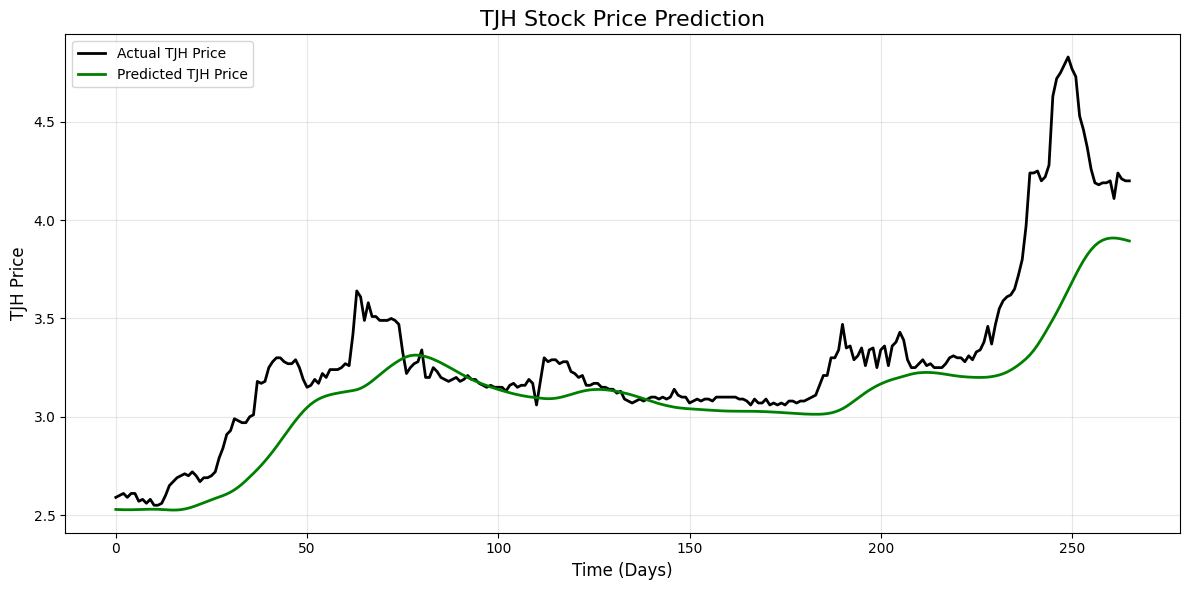


Prediction Metrics for TJH:
Mean Absolute Error (MAE): 0.19
Root Mean Square Error (RMSE): 0.30
Mean Absolute Percentage Error (MAPE): 5.33%

Next Day Prediction for TJH:
Current Price: $4.20
Predicted Price: $3.89
Predicted Change: -7.42%


In [39]:
import datetime as dt

# Split your data into training and testing sets
split_date = dt.date(2023, 12, 1)  # Adjust this date as needed

# Filter your stocks_df for the specific symbol first, then split
fosrich_data = stocks_df.filter(pl.col("symbol") == "TJH").sort("date")

# Split into train and test
train_df = fosrich_data.filter(pl.col("date") < split_date)
test_df = fosrich_data.filter(pl.col("date") >= split_date)

print(f"Training data: {len(train_df)} days")
print(f"Test data: {len(test_df)} days")

# Now you can use the predictor
predictor = LSTMStockPredictor(prediction_days=60)

# Prepare training data
x_train, y_train = predictor.prepare_data(train_df, "closing_price")
history = predictor.train(x_train, y_train, epochs=100)

# Make predictions on test data
x_test, actual_prices = predictor.prepare_test_data(train_df, test_df, "closing_price")
predicted_prices = predictor.predict(x_test)

# Plot results with metrics
predictor.plot_predictions(actual_prices, predicted_prices, "TJH")

# Predict next day
recent_prices = test_df.tail(60)["closing_price"].to_numpy()
next_day_prediction = predictor.predict_next_day(recent_prices)
current_price = recent_prices[-1]

print(f"\nNext Day Prediction for TJH:")
print(f"Current Price: ${float(current_price):.2f}")
print(f"Predicted Price: ${next_day_prediction:.2f}")

# Convert both to float for the calculation
change_pct = ((next_day_prediction - float(current_price)) / float(current_price) * 100)
print(f"Predicted Change: {change_pct:+.2f}%")

## ARIMA (AutoRegressive Integrated Moving Average)

ARIMA Stock Price Prediction Example
Sample data: 1461 days

Stationarity Test Results for Original Series:
--------------------------------------------------
ADF Statistic: -1.392721
p-value: 0.585761
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
✗ Series is non-stationary (fail to reject null hypothesis)


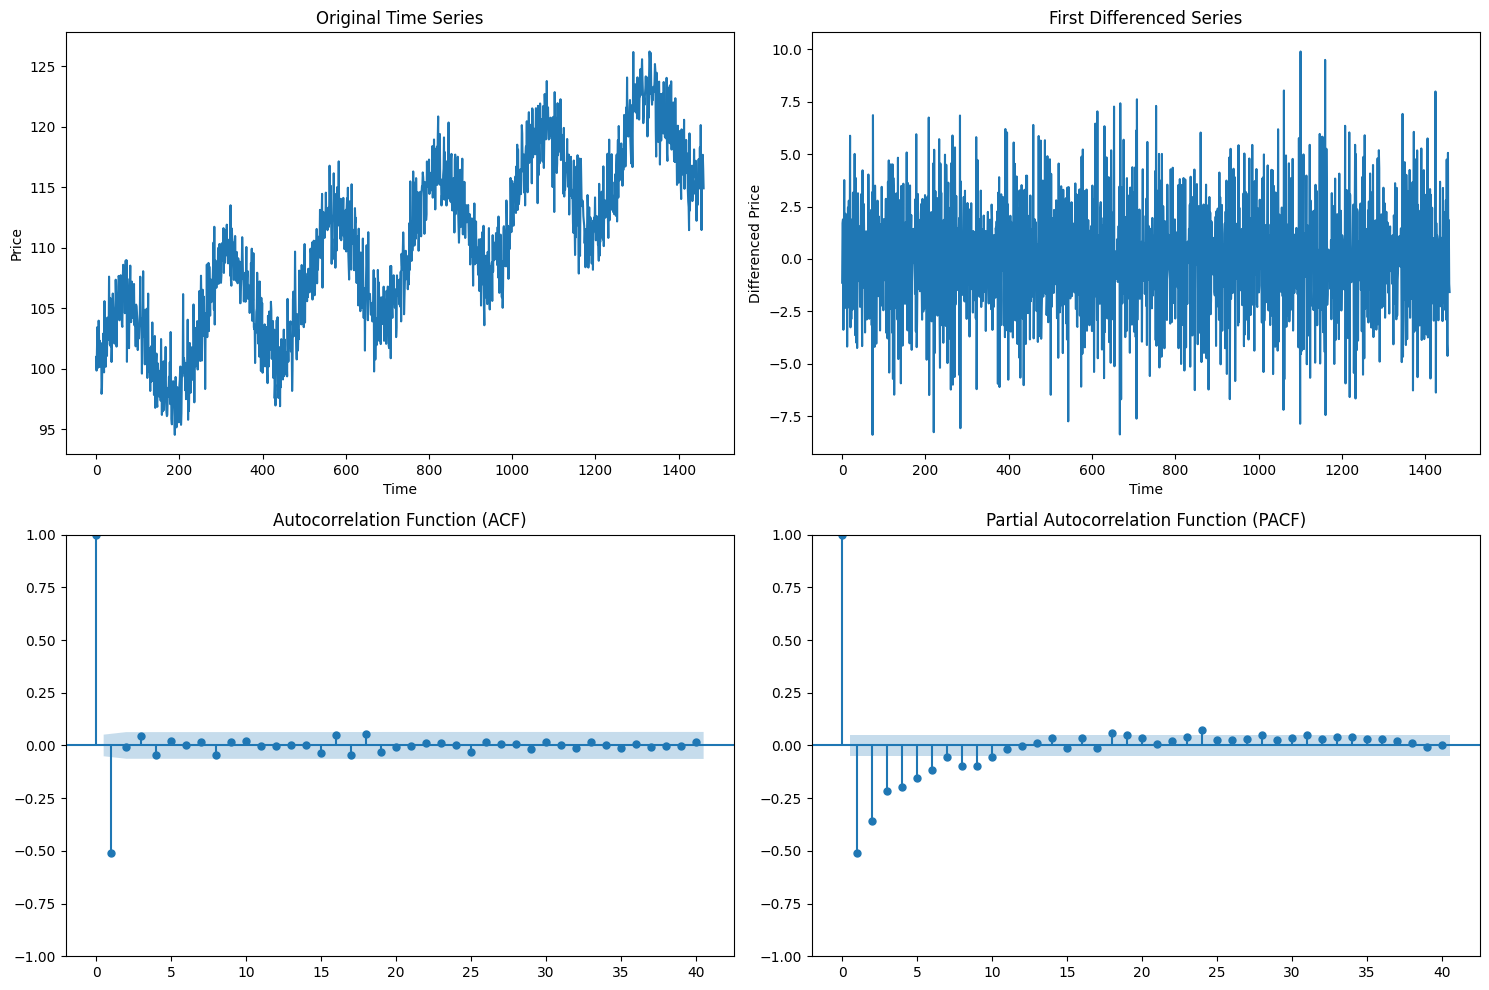

Finding optimal ARIMA parameters...
This may take a few minutes...


c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Joshh\AppDa

Optimal ARIMA order: (2, 2, 2)
Best AIC: 72.84
Best BIC: 99.27

Fitting ARIMA(2, 2, 2) model...


c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1461
Model:                 ARIMA(2, 2, 2)   Log Likelihood                 -31.420
Date:                Tue, 22 Jul 2025   AIC                             72.841
Time:                        20:40:51   BIC                             99.269
Sample:                             0   HQIC                            82.700
                               - 1461                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0016   3.31e-08   4.76e+04      0.000       0.002       0.002
ar.L2          0.9984   3.58e-08   2.79e+07      0.000       0.998       0.998
ma.L1         -2.0000   6.22e-05  -3

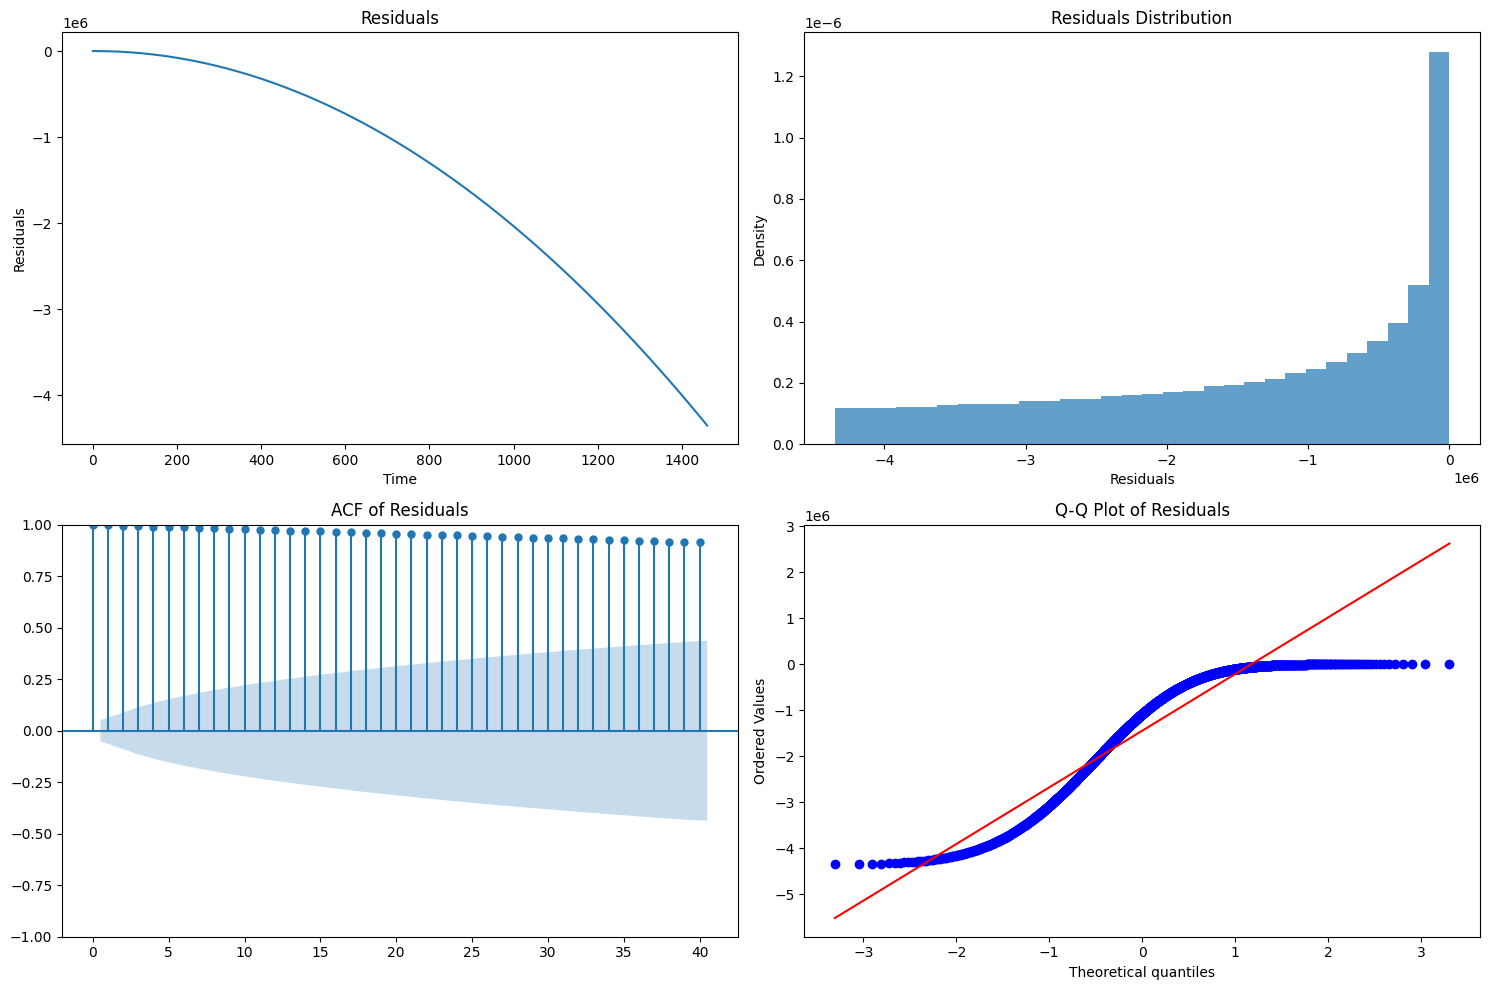


Ljung-Box Test for Residual Autocorrelation:
         lb_stat  lb_pvalue
1    1457.742487        0.0
2    2910.233978        0.0
3    4357.480694        0.0
4    5799.488896        0.0
5    7236.264904        0.0
6    8667.815039        0.0
7   10094.145653        0.0
8   11515.263138        0.0
9   12931.173876        0.0
10  14341.884289        0.0

Next Day Prediction:
Current Price: $114.91
Predicted Price: $4356747.89
95% Confidence Interval: [$nan, $nan]
Performing walk-forward backtest with 30 test observations...

Backtest Results (30 days):
MAE: $1.5145
RMSE: $1.9748
MAPE: 1.30%


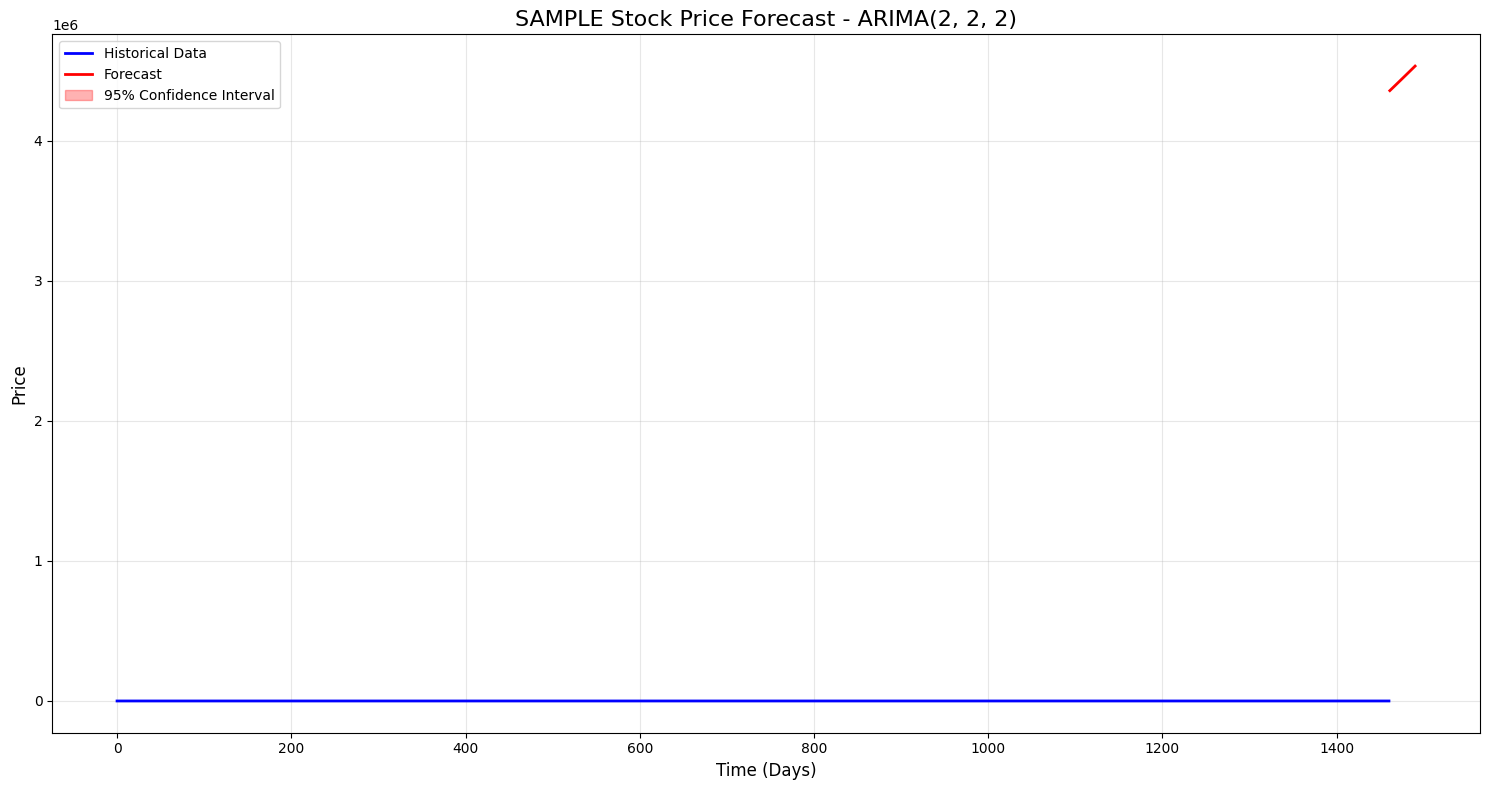

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import datetime as dt
from typing import Tuple, Optional, List, Dict
import warnings
warnings.filterwarnings('ignore')

# Statistical libraries for ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import itertools


class ARIMAStockPredictor:
    """
    ARIMA-based stock price prediction model using Polars for data handling
    """
    
    def __init__(self, auto_order: bool = True):
        """
        Initialize the ARIMA Stock Predictor
        
        Args:
            auto_order: Whether to automatically determine ARIMA parameters (p,d,q)
        """
        self.auto_order = auto_order
        self.model = None
        self.fitted_model = None
        self.order = None
        self.is_trained = False
        self.price_data = None
        self.original_data = None
        
    def check_stationarity(self, timeseries: np.ndarray, title: str = "Time Series") -> Dict:
        """
        Check if time series is stationary using Augmented Dickey-Fuller test
        
        Args:
            timeseries: Time series data to test
            title: Title for the test results
        
        Returns:
            Dictionary with stationarity test results
        """
        print(f'\nStationarity Test Results for {title}:')
        print('-' * 50)
        
        # Perform Augmented Dickey-Fuller test
        dftest = adfuller(timeseries, autolag='AIC')
        
        results = {
            'adf_statistic': dftest[0],
            'p_value': dftest[1],
            'critical_values': dftest[4],
            'is_stationary': dftest[1] <= 0.05
        }
        
        print(f'ADF Statistic: {dftest[0]:.6f}')
        print(f'p-value: {dftest[1]:.6f}')
        print('Critical Values:')
        for key, value in dftest[4].items():
            print(f'\t{key}: {value:.3f}')
        
        if dftest[1] <= 0.05:
            print("✓ Series is stationary (reject null hypothesis)")
        else:
            print("✗ Series is non-stationary (fail to reject null hypothesis)")
            
        return results
    
    def difference_series(self, data: np.ndarray, d: int = 1) -> np.ndarray:
        """
        Apply differencing to make series stationary
        
        Args:
            data: Time series data
            d: Order of differencing
        
        Returns:
            Differenced time series
        """
        differenced = data.copy()
        for i in range(d):
            differenced = np.diff(differenced)
        return differenced
    
    def find_optimal_order(self, data: np.ndarray, max_p: int = 5, max_q: int = 5, 
                          max_d: int = 2, seasonal: bool = False) -> Tuple[int, int, int]:
        """
        Find optimal ARIMA order using grid search with AIC/BIC
        
        Args:
            data: Time series data
            max_p: Maximum AR order to test
            max_q: Maximum MA order to test  
            max_d: Maximum differencing order to test
            seasonal: Whether to include seasonal component
        
        Returns:
            Optimal (p, d, q) order
        """
        print("Finding optimal ARIMA parameters...")
        print("This may take a few minutes...")
        
        best_aic = np.inf
        best_order = None
        best_bic = np.inf
        
        # Test different combinations
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        # Fit ARIMA model
                        model = ARIMA(data, order=(p, d, q))
                        fitted = model.fit()
                        
                        # Track best AIC
                        if fitted.aic < best_aic:
                            best_aic = fitted.aic
                            best_order = (p, d, q)
                            best_bic = fitted.bic
                            
                    except Exception as e:
                        continue
        
        print(f"Optimal ARIMA order: {best_order}")
        print(f"Best AIC: {best_aic:.2f}")
        print(f"Best BIC: {best_bic:.2f}")
        
        return best_order
    
    def plot_diagnostics(self, data: np.ndarray, max_lags: int = 40) -> None:
        """
        Plot ACF and PACF to help determine ARIMA parameters
        
        Args:
            data: Time series data
            max_lags: Maximum number of lags to plot
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Original series
        axes[0,0].plot(data)
        axes[0,0].set_title('Original Time Series')
        axes[0,0].set_xlabel('Time')
        axes[0,0].set_ylabel('Price')
        
        # First difference
        diff_data = np.diff(data)
        axes[0,1].plot(diff_data)
        axes[0,1].set_title('First Differenced Series')
        axes[0,1].set_xlabel('Time')
        axes[0,1].set_ylabel('Differenced Price')
        
        # ACF
        plot_acf(diff_data, lags=max_lags, ax=axes[1,0], alpha=0.05)
        axes[1,0].set_title('Autocorrelation Function (ACF)')
        
        # PACF
        plot_pacf(diff_data, lags=max_lags, ax=axes[1,1], alpha=0.05)
        axes[1,1].set_title('Partial Autocorrelation Function (PACF)')
        
        plt.tight_layout()
        plt.show()
    
    def prepare_data(self, df: pl.DataFrame, price_col: str = "closing_price", 
                    symbol: Optional[str] = None) -> np.ndarray:
        """
        Prepare data for ARIMA modeling
        
        Args:
            df: Polars DataFrame with stock data
            price_col: Column name for price data
            symbol: Specific symbol to prepare data for
        
        Returns:
            Numpy array of prices
        """
        # Filter for specific symbol if provided
        if symbol:
            data = df.filter(pl.col("symbol") == symbol).sort("date")
        else:
            data = df.sort("date")
        
        # Extract and convert prices to float
        prices = data[price_col].cast(pl.Float64).to_numpy()
        
        # Store original data for later use
        self.original_data = data
        self.price_data = prices
        
        return prices
    
    def fit(self, data: np.ndarray, order: Optional[Tuple[int, int, int]] = None,
           verbose: bool = True) -> None:
        """
        Fit ARIMA model to the data
        
        Args:
            data: Time series data
            order: ARIMA order (p,d,q). If None, will auto-determine
            verbose: Whether to print detailed results
        """
        # Auto-determine order if not provided
        if order is None and self.auto_order:
            # Check stationarity first
            self.check_stationarity(data, "Original Series")
            
            # Plot diagnostics
            if verbose:
                self.plot_diagnostics(data)
            
            # Find optimal order
            order = self.find_optimal_order(data)
        elif order is None:
            # Default order if auto-determination is disabled
            order = (1, 1, 1)
            
        self.order = order
        
        # Fit the model
        print(f"\nFitting ARIMA{order} model...")
        self.model = ARIMA(data, order=order)
        self.fitted_model = self.model.fit()
        self.is_trained = True
        
        if verbose:
            print("\nModel Summary:")
            print(self.fitted_model.summary())
            
            # Model diagnostics
            self.plot_residual_diagnostics()
    
    def plot_residual_diagnostics(self) -> None:
        """
        Plot residual diagnostics to check model adequacy
        """
        if not self.is_trained:
            raise ValueError("Model must be fitted before plotting diagnostics")
            
        residuals = self.fitted_model.resid
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Residuals plot
        axes[0,0].plot(residuals)
        axes[0,0].set_title('Residuals')
        axes[0,0].set_xlabel('Time')
        axes[0,0].set_ylabel('Residuals')
        
        # Residuals histogram
        axes[0,1].hist(residuals, bins=30, density=True, alpha=0.7)
        axes[0,1].set_title('Residuals Distribution')
        axes[0,1].set_xlabel('Residuals')
        axes[0,1].set_ylabel('Density')
        
        # ACF of residuals
        plot_acf(residuals, lags=40, ax=axes[1,0], alpha=0.05)
        axes[1,0].set_title('ACF of Residuals')
        
        # Q-Q plot
        from scipy import stats
        stats.probplot(residuals, dist="norm", plot=axes[1,1])
        axes[1,1].set_title('Q-Q Plot of Residuals')
        
        plt.tight_layout()
        plt.show()
        
        # Ljung-Box test for autocorrelation in residuals
        lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
        print("\nLjung-Box Test for Residual Autocorrelation:")
        print(lb_test)
    
    def forecast(self, steps: int = 1, confidence_level: float = 0.95) -> Dict:
        """
        Generate forecasts
        
        Args:
            steps: Number of steps to forecast
            confidence_level: Confidence level for prediction intervals
        
        Returns:
            Dictionary with forecasts and confidence intervals
        """
        if not self.is_trained:
            raise ValueError("Model must be fitted before forecasting")
        
        # Generate forecast
        forecast_result = self.fitted_model.get_forecast(steps=steps)
        forecast_values = forecast_result.predicted_mean
        confidence_intervals = forecast_result.conf_int(alpha=1-confidence_level)
        
        # Handle both numpy arrays and pandas Series
        if hasattr(forecast_values, 'values'):
            forecast_array = forecast_values.values
        else:
            forecast_array = forecast_values
            
        if hasattr(confidence_intervals, 'iloc'):
            lower_ci = confidence_intervals.iloc[:, 0].values
            upper_ci = confidence_intervals.iloc[:, 1].values
        else:
            lower_ci = confidence_intervals[:, 0]
            upper_ci = confidence_intervals[:, 1]
        
        return {
            'forecast': forecast_array,
            'lower_ci': lower_ci,
            'upper_ci': upper_ci,
            'forecast_series': forecast_values
        }
    
    def predict_next_day(self) -> Dict:
        """
        Predict the next day's stock price
        
        Returns:
            Dictionary with prediction and confidence interval
        """
        forecast_result = self.forecast(steps=1)
        
        return {
            'predicted_price': float(forecast_result['forecast'][0]),
            'lower_bound': float(forecast_result['lower_ci'][0]),
            'upper_bound': float(forecast_result['upper_ci'][0])
        }
    
    def backtest(self, test_size: int = 30) -> Dict:
        """
        Perform walk-forward backtesting
        
        Args:
            test_size: Number of observations to use for testing
        
        Returns:
            Dictionary with backtest results
        """
        if self.price_data is None:
            raise ValueError("No data available for backtesting")
        
        train_data = self.price_data[:-test_size]
        test_data = self.price_data[-test_size:]
        
        predictions = []
        actual_values = []
        
        print(f"Performing walk-forward backtest with {test_size} test observations...")
        
        for i in range(test_size):
            # Update training data
            current_train = self.price_data[:-(test_size-i)]
            
            # Fit model
            temp_model = ARIMA(current_train, order=self.order)
            temp_fitted = temp_model.fit()
            
            # Make prediction
            forecast = temp_fitted.forecast(steps=1)
            predictions.append(float(forecast[0]))
            actual_values.append(float(test_data[i]))
        
        # Calculate metrics
        predictions = np.array(predictions)
        actual_values = np.array(actual_values)
        
        mae = np.mean(np.abs(predictions - actual_values))
        rmse = np.sqrt(np.mean((predictions - actual_values) ** 2))
        mape = np.mean(np.abs((predictions - actual_values) / actual_values)) * 100
        
        return {
            'predictions': predictions,
            'actual': actual_values,
            'mae': mae,
            'rmse': rmse,
            'mape': mape
        }
    
    def plot_forecast(self, steps: int = 30, symbol: str = "Stock") -> None:
        """
        Plot historical data with forecast
        
        Args:
            steps: Number of steps to forecast
            symbol: Stock symbol for plot title
        """
        if not self.is_trained:
            raise ValueError("Model must be fitted before plotting forecast")
        
        # Generate forecast
        forecast_result = self.forecast(steps=steps)
        
        # Prepare data for plotting
        historical_data = self.price_data
        forecast_values = forecast_result['forecast']
        lower_ci = forecast_result['lower_ci']
        upper_ci = forecast_result['upper_ci']
        
        # Create time indices
        hist_index = range(len(historical_data))
        forecast_index = range(len(historical_data), len(historical_data) + steps)
        
        # Plot
        plt.figure(figsize=(15, 8))
        plt.plot(hist_index, historical_data, label='Historical Data', color='blue', linewidth=2)
        plt.plot(forecast_index, forecast_values, label='Forecast', color='red', linewidth=2)
        plt.fill_between(forecast_index, lower_ci, upper_ci, color='red', alpha=0.3, label='95% Confidence Interval')
        
        plt.title(f'{symbol} Stock Price Forecast - ARIMA{self.order}', fontsize=16)
        plt.xlabel('Time (Days)', fontsize=12)
        plt.ylabel('Price', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


def compare_arima_vs_lstm(arima_results: Dict, lstm_results: Dict, symbol: str) -> None:
    """
    Compare ARIMA and LSTM model performance
    
    Args:
        arima_results: ARIMA backtest results
        lstm_results: LSTM performance metrics
        symbol: Stock symbol
    """
    print(f"\n{'='*60}")
    print(f"MODEL COMPARISON FOR {symbol}")
    print(f"{'='*60}")
    
    print(f"\nARIMA Model Performance:")
    print(f"MAE: ${arima_results['mae']:.4f}")
    print(f"RMSE: ${arima_results['rmse']:.4f}")
    print(f"MAPE: {arima_results['mape']:.2f}%")
    
    print(f"\nLSTM Model Performance:")
    print(f"MAE: ${lstm_results['mae']:.4f}")
    print(f"RMSE: ${lstm_results['rmse']:.4f}")
    print(f"MAPE: {lstm_results['mape']:.2f}%")
    
    # Determine better model
    if arima_results['mape'] < lstm_results['mape']:
        print(f"\n🏆 ARIMA performs better (lower MAPE)")
    else:
        print(f"\n🏆 LSTM performs better (lower MAPE)")
    
    # Plot comparison
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(arima_results['actual'], label='Actual', color='black', linewidth=2)
    plt.plot(arima_results['predictions'], label='ARIMA Predictions', color='blue', linewidth=2)
    plt.title(f'ARIMA Performance\nMAPE: {arima_results["mape"]:.2f}%')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(lstm_results['actual'], label='Actual', color='black', linewidth=2)
    plt.plot(lstm_results['predictions'], label='LSTM Predictions', color='green', linewidth=2)
    plt.title(f'LSTM Performance\nMAPE: {lstm_results["mape"]:.2f}%')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# Example usage function
def example_usage():
    """
    Example of how to use the ARIMA Stock Predictor
    """
    print("ARIMA Stock Price Prediction Example")
    print("="*40)
    
    # Create sample data
    np.random.seed(42)
    start_date = dt.date(2020, 1, 1)
    end_date = dt.date(2024, 1, 1)
    n = (end_date - start_date).days
    dates = [start_date + dt.timedelta(days=i) for i in range(n)]
    
    # Generate realistic stock price data with trend and seasonality
    trend = np.linspace(100, 120, n)
    seasonal = 5 * np.sin(2 * np.pi * np.arange(n) / 252)  # Annual seasonality
    noise = np.random.normal(0, 2, n)
    prices = trend + seasonal + noise
    prices = np.maximum(prices, 1.0)  # Ensure positive prices
    
    # Create sample DataFrame
    sample_df = pl.DataFrame({
        "date": dates,
        "symbol": ["SAMPLE"] * n,
        "closing_price": prices,
        "volume": np.random.randint(1000000, 50000000, n)
    })
    
    print(f"Sample data: {len(sample_df)} days")
    
    # Initialize ARIMA predictor
    arima_predictor = ARIMAStockPredictor(auto_order=True)
    
    # Prepare data
    price_data = arima_predictor.prepare_data(sample_df, "closing_price", "SAMPLE")
    
    # Fit the model
    arima_predictor.fit(price_data, verbose=True)
    
    # Make next day prediction
    next_day_pred = arima_predictor.predict_next_day()
    current_price = price_data[-1]
    
    print(f"\nNext Day Prediction:")
    print(f"Current Price: ${current_price:.2f}")
    print(f"Predicted Price: ${next_day_pred['predicted_price']:.2f}")
    print(f"95% Confidence Interval: [${next_day_pred['lower_bound']:.2f}, ${next_day_pred['upper_bound']:.2f}]")
    
    # Perform backtest
    backtest_results = arima_predictor.backtest(test_size=30)
    print(f"\nBacktest Results (30 days):")
    print(f"MAE: ${backtest_results['mae']:.4f}")
    print(f"RMSE: ${backtest_results['rmse']:.4f}")
    print(f"MAPE: {backtest_results['mape']:.2f}%")
    
    # Plot forecast
    arima_predictor.plot_forecast(steps=30, symbol="SAMPLE")
    
    return arima_predictor


if __name__ == "__main__":
    example_usage()


Stationarity Test Results for Original Series:
--------------------------------------------------
ADF Statistic: -2.901062
p-value: 0.045225
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
✓ Series is stationary (reject null hypothesis)


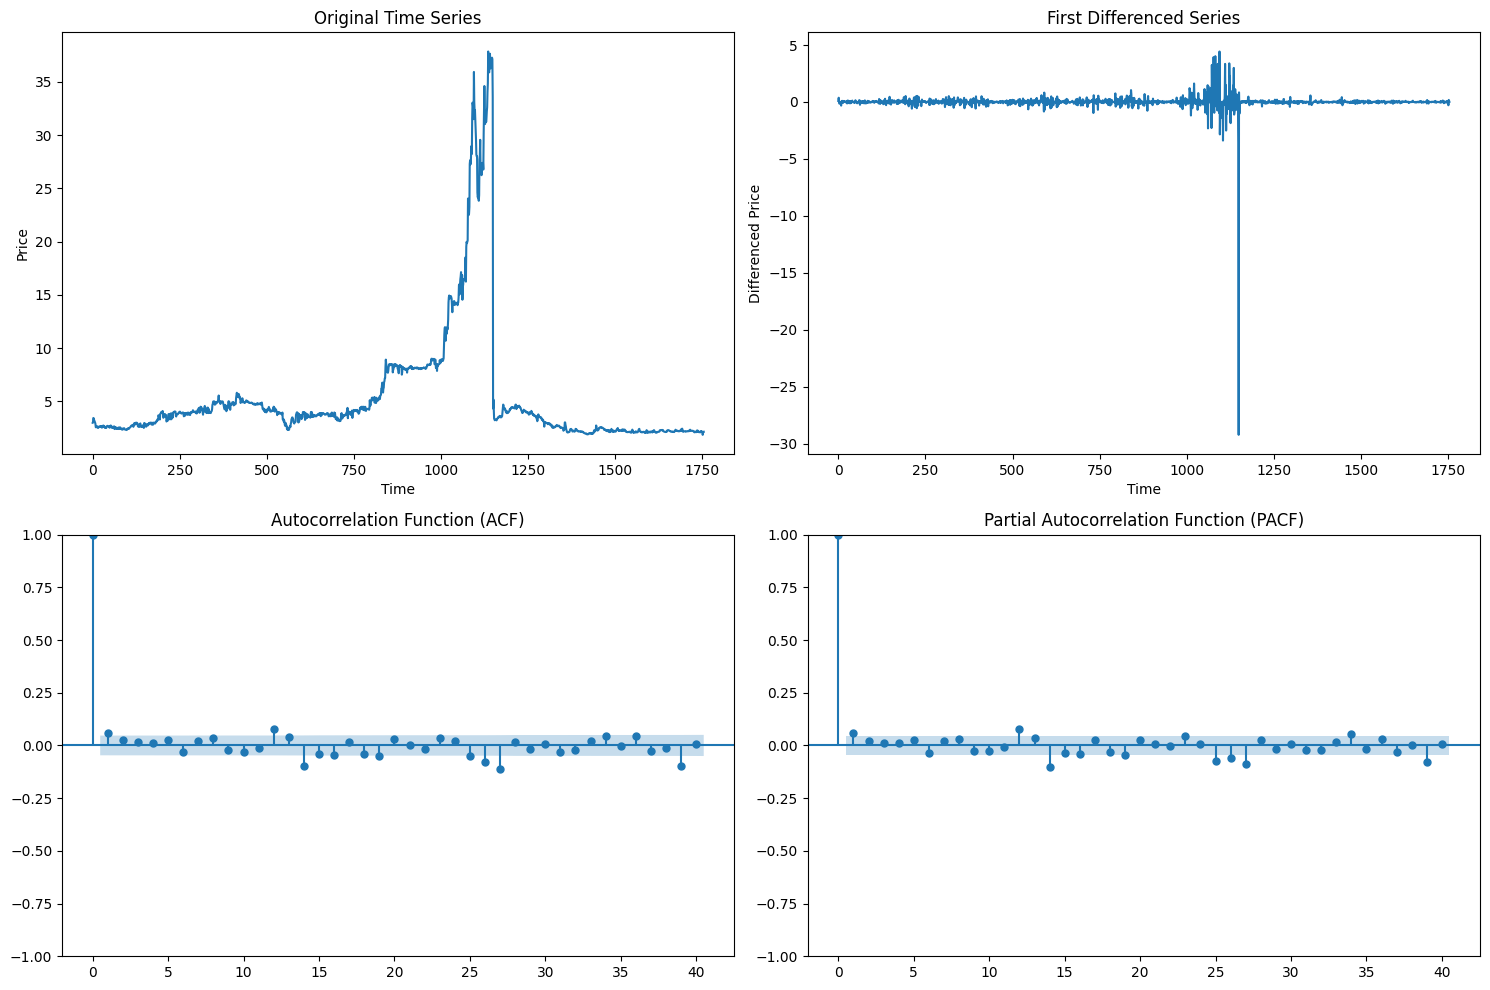

Finding optimal ARIMA parameters...
This may take a few minutes...


c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Joshh\AppDa

Optimal ARIMA order: (2, 1, 4)
Best AIC: 4168.73
Best BIC: 4207.02

Fitting ARIMA(2, 1, 4) model...


c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1756
Model:                 ARIMA(2, 1, 4)   Log Likelihood               -2077.366
Date:                Tue, 22 Jul 2025   AIC                           4168.732
Time:                        20:42:39   BIC                           4207.024
Sample:                             0   HQIC                          4182.885
                               - 1756                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0932      0.022      4.232      0.000       0.050       0.136
ar.L2         -0.9692      0.027    -36.265      0.000      -1.022      -0.917
ma.L1         -0.0368      0.026    

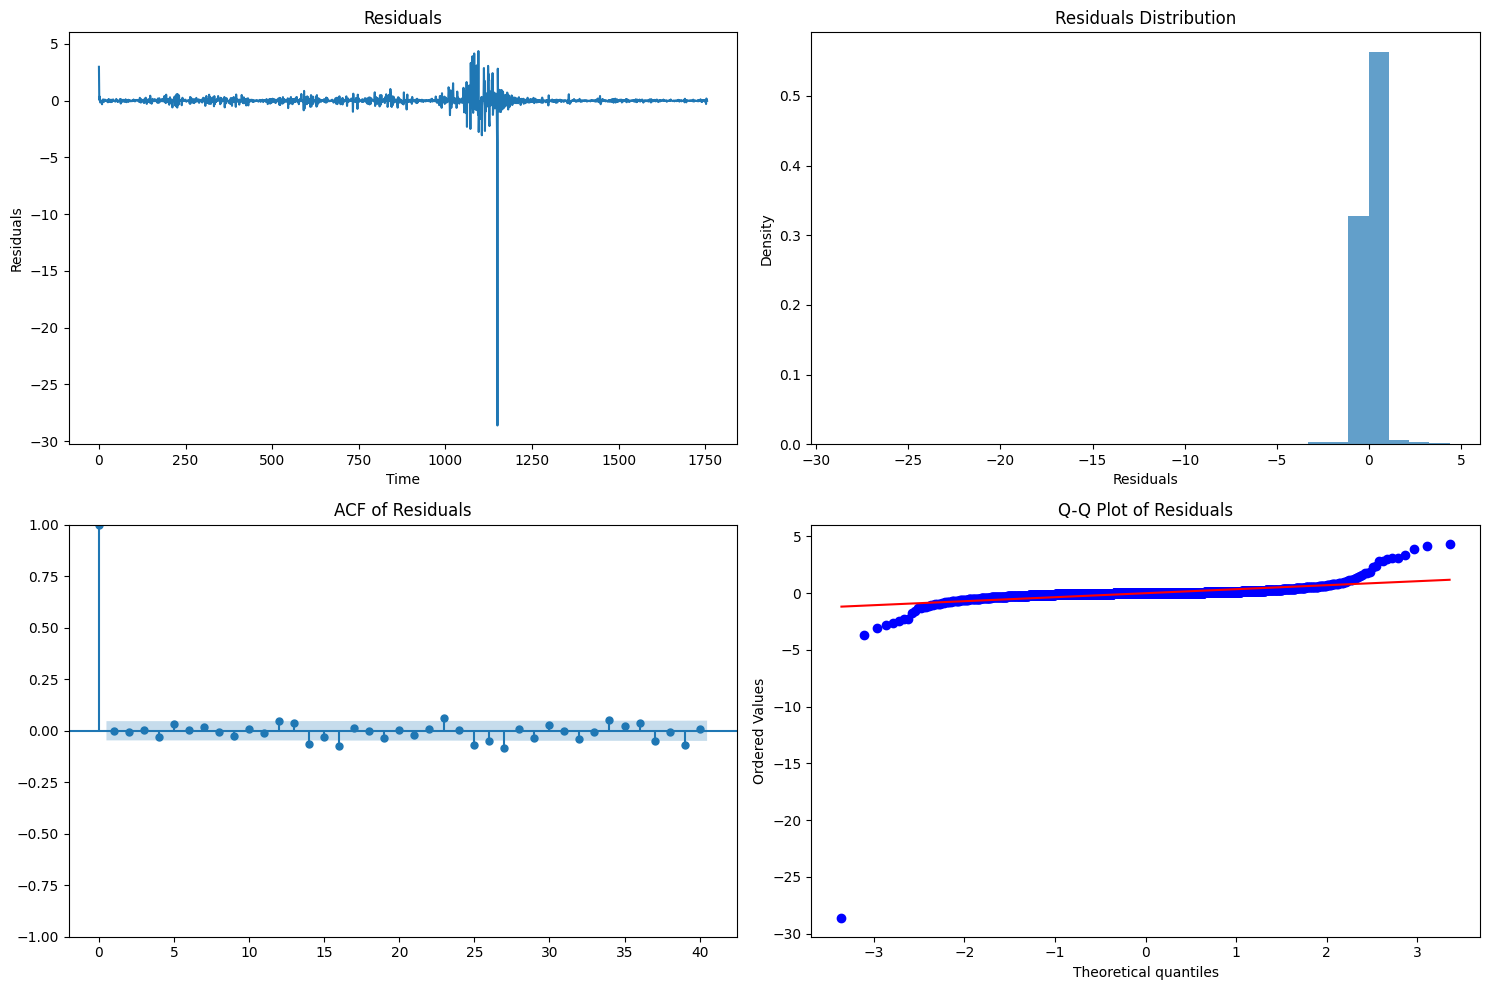


Ljung-Box Test for Residual Autocorrelation:
     lb_stat  lb_pvalue
1   0.000804   0.977373
2   0.039609   0.980390
3   0.099563   0.991890
4   1.856290   0.762169
5   3.791106   0.579866
6   3.853234   0.696530
7   4.377160   0.735454
8   4.424482   0.816940
9   5.611498   0.778083
10  5.699631   0.839836
Current Price: $2.15
ARIMA Predicted Price: $2.15
95% Confidence Interval: [$0.60, $3.70]
Performing walk-forward backtest with 30 test observations...


c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Joshh\AppDa

ARIMA MAPE: 2.74%


c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



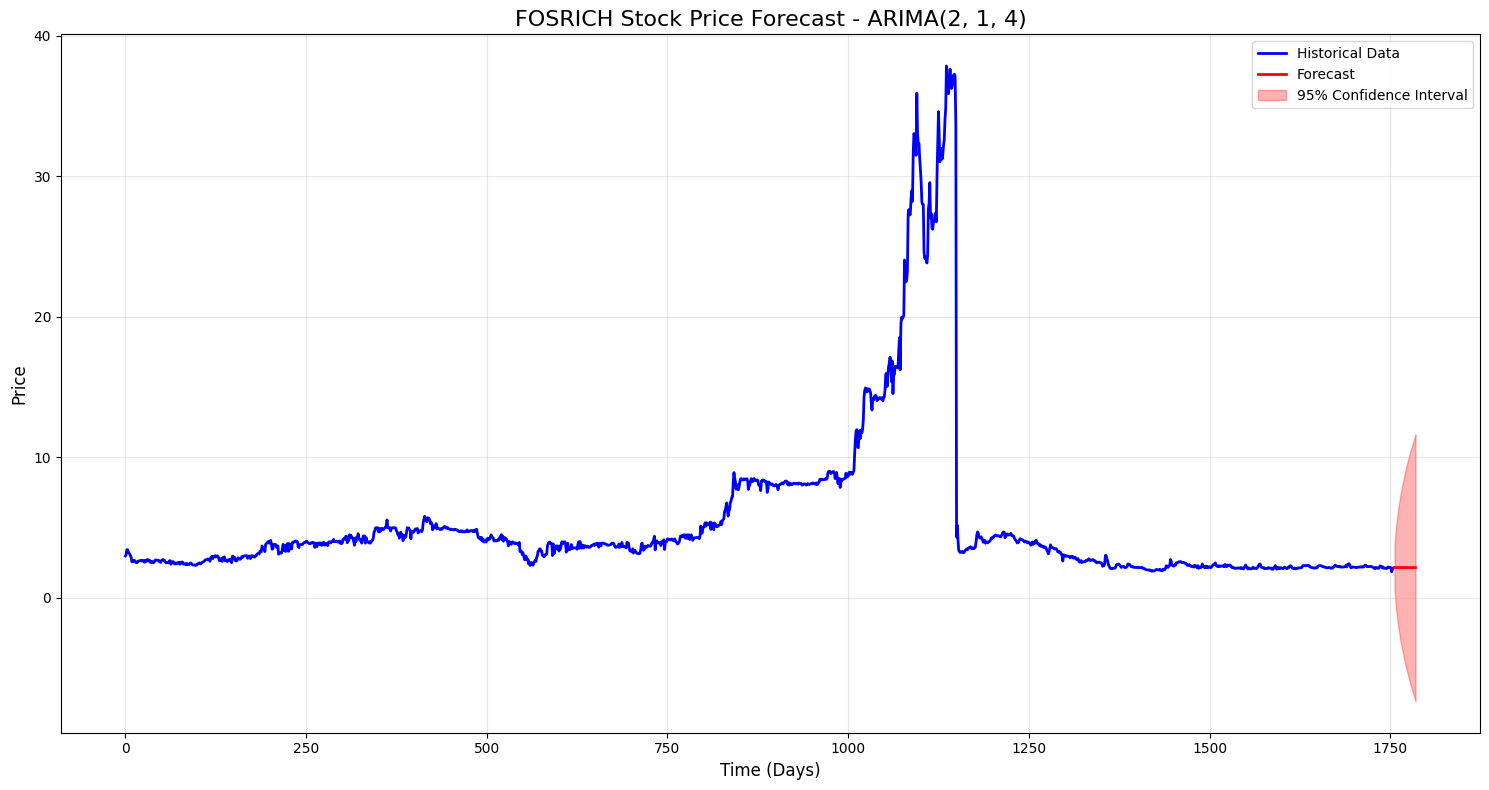

In [15]:
# Use with your existing FOSRICH data
arima_predictor = ARIMAStockPredictor(auto_order=True)

# Prepare data (same as LSTM)
price_data = arima_predictor.prepare_data(stocks_df, "closing_price", "FOSRICH")

# Fit the model (will auto-determine parameters)
arima_predictor.fit(price_data, verbose=True)

# Make next day prediction with confidence intervals
next_day_pred = arima_predictor.predict_next_day()
current_price = price_data[-1]

print(f"Current Price: ${current_price:.2f}")
print(f"ARIMA Predicted Price: ${next_day_pred['predicted_price']:.2f}")
print(f"95% Confidence Interval: [${next_day_pred['lower_bound']:.2f}, ${next_day_pred['upper_bound']:.2f}]")

# Backtest performance
backtest_results = arima_predictor.backtest(test_size=30)
print(f"ARIMA MAPE: {backtest_results['mape']:.2f}%")

# Plot forecast
arima_predictor.plot_forecast(steps=30, symbol="FOSRICH")

Performing walk-forward backtest with 30 test observations...

MODEL COMPARISON FOR FOSRICH

ARIMA Model Performance:
MAE: $0.0573
RMSE: $0.0830
MAPE: 2.74%

LSTM Model Performance:
MAE: $0.1800
RMSE: $0.2100
MAPE: 7.52%

🏆 ARIMA performs better (lower MAPE)


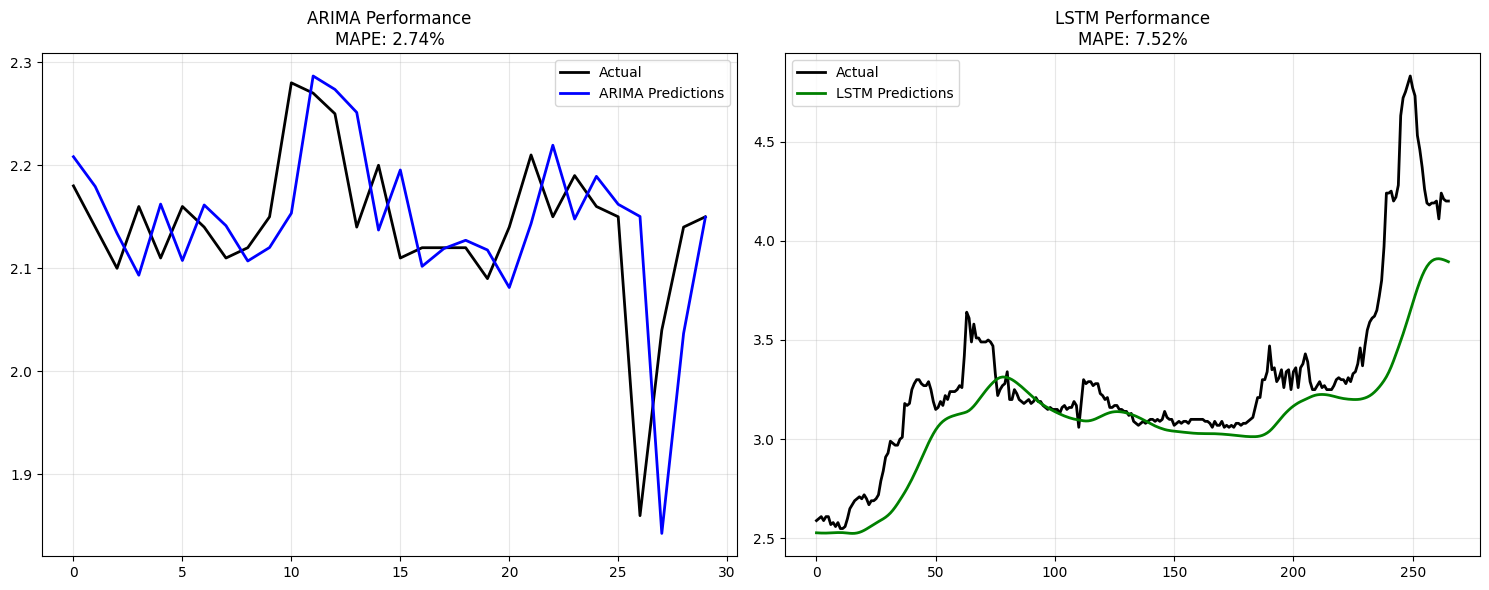

In [43]:
# Compare both models
arima_results = arima_predictor.backtest(test_size=30)
lstm_results = {
    'mae': 0.18,
    'rmse': 0.21, 
    'mape': 7.52,
    'actual': actual_prices,
    'predictions': predicted_prices
}

compare_arima_vs_lstm(arima_results, lstm_results, "FOSRICH")

## Classification

In [ ]:
# News Impact Classification: Daily, Weekly, Monthly Stock Price Movements
# =========================================================================

import polars as pl
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Classification imports
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_recall_fscore_support,
                           roc_auc_score, roc_curve)
import xgboost as xgb
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from collections import Counter

print("📰 News Impact Classification Pipeline Loaded!")

# =============================================================================
# CELL 1: Data Preparation for Classification
# =============================================================================

def create_classification_dataset(news_df, stocks_df):
    """
    Create dataset linking news articles to future stock price movements
    """
    print("Creating news impact classification dataset...")
    
    # Convert to pandas for easier date manipulation
    news_pd = news_df.to_pandas()
    stocks_pd = stocks_df.to_pandas()
    
    print(f"News articles: {len(news_pd):,}")
    print(f"Stock records: {len(stocks_pd):,}")
    
    # Extract sentiment data with company mapping
    news_processed = (
        news_pd
        .dropna(subset=['organizations', 'publication_date', 'sentiment_polarity'])
        .explode('organizations')
        .dropna(subset=['organizations'])
    )
    
    # Map organizations to stock symbols
    news_processed['symbol'] = news_processed['organizations'].apply(find_company_symbol)
    news_processed = news_processed.dropna(subset=['symbol'])
    
    print(f"News articles mapped to JSE companies: {len(news_processed):,}")
    
    # Prepare stock data with proper date indexing
    stocks_pd['date'] = pd.to_datetime(stocks_pd['date'])
    stocks_pd = stocks_pd.sort_values(['symbol', 'date'])
    
    # Calculate future returns for each stock
    stocks_pd['next_day_return'] = stocks_pd.groupby('symbol')['closing_price'].pct_change(1).shift(-1) * 100
    stocks_pd['next_week_return'] = stocks_pd.groupby('symbol')['closing_price'].pct_change(5).shift(-5) * 100
    stocks_pd['next_month_return'] = stocks_pd.groupby('symbol')['closing_price'].pct_change(20).shift(-20) * 100
    
    # Prepare news data
    news_processed['publication_date'] = pd.to_datetime(news_processed['publication_date'])
    news_processed = news_processed.sort_values(['symbol', 'publication_date'])
    
    # Create features from news
    news_features = []
    
    for _, news_row in news_processed.iterrows():
        news_date = news_row['publication_date']
        symbol = news_row['symbol']
        
        # Find the next trading day after news publication
        future_stocks = stocks_pd[
            (stocks_pd['symbol'] == symbol) & 
            (stocks_pd['date'] >= news_date)
        ].head(25)  # Get up to 25 trading days ahead
        
        if len(future_stocks) >= 20:  # Ensure we have enough data for monthly prediction
            # Get the closest trading day
            next_day_stock = future_stocks.iloc[0]
            
            # Get stock data for different horizons
            next_week_stock = future_stocks.iloc[min(4, len(future_stocks)-1)]  # ~1 week
            next_month_stock = future_stocks.iloc[min(19, len(future_stocks)-1)]  # ~1 month
            
            # Create feature record
            feature_record = {
                # News metadata
                'news_date': news_date,
                'symbol': symbol,
                'title': news_row['title'],
                
                # Sentiment features
                'sentiment_polarity': news_row['sentiment_polarity'],
                'sentiment_subjectivity': news_row['sentiment_subjectivity'],
                'text_length': len(str(news_row.get('text', ''))),
                'title_length': len(str(news_row['title'])),
                
                # Stock context (at time of news)
                'stock_price': next_day_stock['closing_price'],
                'stock_volume': next_day_stock['volume'],
                
                # Target variables (future returns)
                'next_day_return': next_day_stock['next_day_return'],
                'next_week_return': next_week_stock['next_week_return'],
                'next_month_return': next_month_stock['next_month_return'],
                
                # Days to measurement
                'days_to_day': (next_day_stock['date'] - news_date).days,
                'days_to_week': (next_week_stock['date'] - news_date).days,
                'days_to_month': (next_month_stock['date'] - news_date).days,
            }
            
            news_features.append(feature_record)
    
    # Convert to DataFrame
    classification_df = pd.DataFrame(news_features)
    classification_df = classification_df.dropna(subset=['next_day_return', 'next_week_return', 'next_month_return'])
    
    print(f"Final classification dataset: {len(classification_df):,} news-stock pairs")
    print(f"Date range: {classification_df['news_date'].min()} to {classification_df['news_date'].max()}")
    
    return classification_df

# =============================================================================
# CELL 2: Target Variable Creation
# =============================================================================

def create_classification_targets(df, thresholds={'day': 2, 'week': 5, 'month': 10}):
    """
    Create classification targets for different time horizons
    """
    print("Creating classification targets...")
    
    df_classified = df.copy()
    
    # Create binary and multi-class targets for each horizon
    for horizon in ['day', 'week', 'month']:
        return_col = f'next_{horizon}_return'
        threshold = thresholds[horizon]
        
        # Binary classification (Positive/Negative impact)
        df_classified[f'{horizon}_binary'] = (df_classified[return_col] > 0).astype(int)
        
        # 3-class classification (Positive/Neutral/Negative)
        df_classified[f'{horizon}_3class'] = pd.cut(
            df_classified[return_col],
            bins=[-np.inf, -threshold, threshold, np.inf],
            labels=['Negative', 'Neutral', 'Positive']
        )
        
        # 5-class classification (Strong Negative/Weak Negative/Neutral/Weak Positive/Strong Positive)
        df_classified[f'{horizon}_5class'] = pd.cut(
            df_classified[return_col],
            bins=[-np.inf, -threshold*2, -threshold, threshold, threshold*2, np.inf],
            labels=['Strong_Negative', 'Weak_Negative', 'Neutral', 'Weak_Positive', 'Strong_Positive']
        )
    
    # Print class distributions
    print("\nClass Distributions:")
    print("=" * 50)
    
    for horizon in ['day', 'week', 'month']:
        print(f"\n{horizon.upper()} HORIZON:")
        
        # Binary distribution
        binary_dist = df_classified[f'{horizon}_binary'].value_counts()
        print(f"Binary - Positive: {binary_dist.get(1, 0):,} ({binary_dist.get(1, 0)/len(df_classified)*100:.1f}%)")
        print(f"       - Negative: {binary_dist.get(0, 0):,} ({binary_dist.get(0, 0)/len(df_classified)*100:.1f}%)")
        
        # 3-class distribution
        three_class_dist = df_classified[f'{horizon}_3class'].value_counts()
        for class_name in ['Negative', 'Neutral', 'Positive']:
            count = three_class_dist.get(class_name, 0)
            pct = count/len(df_classified)*100
            print(f"3-class - {class_name}: {count:,} ({pct:.1f}%)")
    
    return df_classified

# =============================================================================
# CELL 3: Feature Engineering for Classification
# =============================================================================

def engineer_classification_features(df):
    """
    Create additional features for classification
    """
    print("Engineering features for classification...")
    
    df_features = df.copy()
    
    # Sentiment-based features
    df_features['sentiment_strength'] = abs(df_features['sentiment_polarity'])
    df_features['sentiment_category'] = pd.cut(
        df_features['sentiment_polarity'],
        bins=[-1, -0.1, 0.1, 1],
        labels=['Negative', 'Neutral', 'Positive']
    )
    
    # Text-based features
    df_features['text_sentiment_ratio'] = df_features['text_length'] * df_features['sentiment_strength']
    df_features['title_sentiment_ratio'] = df_features['title_length'] * df_features['sentiment_strength']
    
    # Time-based features
    df_features['day_of_week'] = df_features['news_date'].dt.dayofweek
    df_features['month'] = df_features['news_date'].dt.month
    df_features['is_weekend_news'] = (df_features['day_of_week'] >= 5).astype(int)
    
    # Stock context features
    df_features['log_volume'] = np.log1p(df_features['stock_volume'])
    df_features['log_price'] = np.log1p(df_features['stock_price'])
    
    # News timing features
    df_features['news_delay_day'] = df_features['days_to_day']
    df_features['news_delay_week'] = df_features['days_to_week']
    df_features['news_delay_month'] = df_features['days_to_month']
    
    # Company-level features (if we have enough data)
    company_stats = df_features.groupby('symbol').agg({
        'sentiment_polarity': ['mean', 'std', 'count'],
        'stock_price': 'mean',
        'stock_volume': 'mean'
    }).round(4)
    
    company_stats.columns = ['_'.join(col).strip() for col in company_stats.columns]
    company_stats = company_stats.add_prefix('company_')
    
    # Merge company stats
    df_features = df_features.merge(
        company_stats, 
        left_on='symbol', 
        right_index=True, 
        how='left'
    )
    
    print(f"Feature engineering complete. Shape: {df_features.shape}")
    
    # Define feature columns for modeling
    feature_cols = [
        'sentiment_polarity', 'sentiment_subjectivity', 'sentiment_strength',
        'text_length', 'title_length', 'text_sentiment_ratio', 'title_sentiment_ratio',
        'day_of_week', 'month', 'is_weekend_news',
        'log_volume', 'log_price',
        'news_delay_day', 'news_delay_week', 'news_delay_month'
    ]
    
    # Add company features if available
    company_feature_cols = [col for col in df_features.columns if col.startswith('company_')]
    feature_cols.extend(company_feature_cols)
    
    # Remove any features with all NaN values
    feature_cols = [col for col in feature_cols if col in df_features.columns and not df_features[col].isna().all()]
    
    print(f"Selected {len(feature_cols)} features for modeling")
    
    return df_features, feature_cols

# =============================================================================
# CELL 4: Train-Test Split for Classification
# =============================================================================

def create_classification_split(df, feature_cols, test_months=3):
    """
    Create chronological train/test split for classification
    """
    print("Creating train/test split for classification...")
    
    # Sort by date
    df_sorted = df.sort_values('news_date')
    
    # Calculate split date
    split_date = df_sorted['news_date'].quantile(1 - test_months/12)  # Reserve last N months
    
    print(f"Split date: {split_date}")
    print(f"Training period: {df_sorted['news_date'].min()} to {split_date}")
    print(f"Testing period: {split_date} to {df_sorted['news_date'].max()}")
    
    # Create splits
    train_mask = df_sorted['news_date'] < split_date
    
    train_df = df_sorted[train_mask]
    test_df = df_sorted[~train_mask]
    
    print(f"Training set: {len(train_df):,} samples")
    print(f"Test set: {len(test_df):,} samples")
    
    # Prepare feature matrices
    X_train = train_df[feature_cols].fillna(0)
    X_test = test_df[feature_cols].fillna(0)
    
    # Prepare target dictionaries for different horizons and classes
    targets = {}
    
    for horizon in ['day', 'week', 'month']:
        targets[horizon] = {}
        
        for class_type in ['binary', '3class', '5class']:
            target_col = f'{horizon}_{class_type}'
            
            if class_type == 'binary':
                y_train = train_df[target_col]
                y_test = test_df[target_col]
            else:
                # For multi-class, encode labels
                le = LabelEncoder()
                y_train = le.fit_transform(train_df[target_col].astype(str))
                y_test = le.transform(test_df[target_col].astype(str))
                targets[horizon][f'{class_type}_encoder'] = le
            
            targets[horizon][class_type] = {
                'train': y_train,
                'test': y_test
            }
    
    return X_train, X_test, targets, train_df, test_df

# =============================================================================
# CELL 5: Classification Model Training
# =============================================================================

def train_classification_models(X_train, X_test, y_train, y_test, problem_type='binary'):
    """
    Train classification models for a specific target
    """
    print(f"Training {problem_type} classification models...")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define models based on problem type
    if problem_type == 'binary':
        models = {
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
            'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
            'SVM': SVC(random_state=42, probability=True)
        }
    else:  # multiclass
        models = {
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr'),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='mlogloss'),
            'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
        }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Use scaled features for linear models, original for tree models
        if name in ['Logistic Regression', 'SVM']:
            X_tr, X_te = X_train_scaled, X_test_scaled
        else:
            X_tr, X_te = X_train, X_test
        
        # Train model
        model.fit(X_tr, y_train)
        
        # Predictions
        y_train_pred = model.predict(X_tr)
        y_test_pred = model.predict(X_te)
        
        # Probabilities (for AUC)
        if hasattr(model, 'predict_proba'):
            y_test_proba = model.predict_proba(X_te)
            if problem_type == 'binary':
                test_auc = roc_auc_score(y_test, y_test_proba[:, 1])
            else:
                test_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr', average='weighted')
        else:
            test_auc = None
        
        # Metrics
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        
        # Precision, Recall, F1
        train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(y_train, y_train_pred, average='weighted')
        test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')
        
        results[name] = {
            'model': model,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'train_precision': train_prec,
            'test_precision': test_prec,
            'train_recall': train_rec,
            'test_recall': test_rec,
            'train_f1': train_f1,
            'test_f1': test_f1,
            'test_auc': test_auc,
            'predictions': y_test_pred,
            'probabilities': y_test_proba if hasattr(model, 'predict_proba') else None
        }
        
        print(f"  Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f}")
        print(f"  Train F1:  {train_f1:.3f} | Test F1:  {test_f1:.3f}")
        if test_auc:
            print(f"  Test AUC:  {test_auc:.3f}")
    
    return results, scaler

# =============================================================================
# CELL 6: Comprehensive Model Evaluation
# =============================================================================

def evaluate_classification_models(results, y_test, target_names=None):
    """
    Comprehensive evaluation of classification models
    """
    print("Classification Model Evaluation")
    print("=" * 60)
    
    # Create comparison DataFrame
    comparison_data = []
    for name, result in results.items():
        comparison_data.append({
            'Model': name,
            'Test Accuracy': result['test_accuracy'],
            'Test Precision': result['test_precision'],
            'Test Recall': result['test_recall'],
            'Test F1': result['test_f1'],
            'Test AUC': result.get('test_auc', np.nan),
            'Overfitting': result['train_accuracy'] - result['test_accuracy']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Test F1', ascending=False)
    
    print(comparison_df.round(3).to_string(index=False))
    
    # Plot comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Test Accuracy
    axes[0,0].bar(comparison_df['Model'], comparison_df['Test Accuracy'])
    axes[0,0].set_title('Test Accuracy by Model')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].set_ylim(0, 1)
    
    # Test F1 Score
    axes[0,1].bar(comparison_df['Model'], comparison_df['Test F1'])
    axes[0,1].set_title('Test F1 Score by Model')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].set_ylim(0, 1)
    
    # AUC (if available)
    if not comparison_df['Test AUC'].isna().all():
        axes[1,0].bar(comparison_df['Model'], comparison_df['Test AUC'])
        axes[1,0].set_title('Test AUC by Model')
        axes[1,0].tick_params(axis='x', rotation=45)
        axes[1,0].set_ylim(0, 1)
    
    # Overfitting
    axes[1,1].bar(comparison_df['Model'], comparison_df['Overfitting'])
    axes[1,1].set_title('Overfitting (Train Acc - Test Acc)')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].axhline(y=0, color='red', linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    # Best model confusion matrix
    best_model_name = comparison_df.iloc[0]['Model']
    best_predictions = results[best_model_name]['predictions']
    
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, best_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Classification report for best model
    print(f"\nDetailed Classification Report - {best_model_name}:")
    print("=" * 60)
    print(classification_report(y_test, best_predictions, target_names=target_names))
    
    return comparison_df, best_model_name

# =============================================================================
# CELL 7: Feature Importance Analysis
# =============================================================================

def analyze_classification_features(results, feature_names, model_name='Random Forest'):
    """
    Analyze feature importance for classification
    """
    print(f"Feature Importance Analysis - {model_name}")
    print("=" * 50)
    
    if model_name not in results:
        print(f"Model {model_name} not found")
        return
    
    model = results[model_name]['model']
    
    if hasattr(model, 'feature_importances_'):
        # Tree-based model
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(15)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'{model_name} - Top 15 Feature Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        print("Top 10 Most Important Features:")
        for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
            print(f"{i:2d}. {row['feature']:<25} {row['importance']:.4f}")
            
    elif hasattr(model, 'coef_'):
        # Linear model
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': abs(model.coef_.flatten())
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(15)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Absolute Coefficient Value')
        plt.title(f'{model_name} - Top 15 Feature Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    return importance_df

# =============================================================================
# CELL 8: Multi-Horizon Analysis Pipeline
# =============================================================================

def run_multi_horizon_analysis(X_train, X_test, targets, feature_cols):
    """
    Run classification analysis across all horizons and class types
    """
    print("Running Multi-Horizon Classification Analysis")
    print("=" * 70)
    
    all_results = {}
    
    for horizon in ['day', 'week', 'month']:
        print(f"\n🔍 ANALYZING {horizon.upper()} HORIZON")
        print("=" * 50)
        
        horizon_results = {}
        
        # Binary classification
        print(f"\n📊 Binary Classification ({horizon}):")
        y_train_bin = targets[horizon]['binary']['train']
        y_test_bin = targets[horizon]['binary']['test']
        
        bin_results, bin_scaler = train_classification_models(
            X_train, X_test, y_train_bin, y_test_bin, 'binary'
        )
        
        bin_comparison, bin_best = evaluate_classification_models(
            bin_results, y_test_bin, ['Negative', 'Positive']
        )
        
        horizon_results['binary'] = {
            'results': bin_results,
            'comparison': bin_comparison,
            'best_model': bin_best,
            'scaler': bin_scaler
        }
        
        # 3-class classification
        print(f"\n📊 3-Class Classification ({horizon}):")
        y_train_3class = targets[horizon]['3class']['train']
        y_test_3class = targets[horizon]['3class']['test']
        
        class3_results, class3_scaler = train_classification_models(
            X_train, X_test, y_train_3class, y_test_3class, 'multiclass'
        )
        
        class3_comparison, class3_best = evaluate_classification_models(
            class3_results, y_test_3class, ['Negative', 'Neutral', 'Positive']
        )
        
        horizon_results['3class'] = {
            'results': class3_results,
            'comparison': class3_comparison,
            'best_model': class3_best,
            'scaler': class3_scaler
        }
        
        # Feature importance for best model
        best_model_name = bin_comparison.iloc[0]['Model']
        analyze_classification_features(bin_results, feature_cols, best_model_name)
        
        all_results[horizon] = horizon_results
    
    return all_results

# =============================================================================
# CELL 9: Business Insights and Recommendations
# =============================================================================

def generate_business_insights(all_results, classification_df):
    """
    Generate actionable business insights from classification results
    """
    print("NEWS IMPACT CLASSIFICATION - BUSINESS INSIGHTS")
    print("=" * 70)
    
    # Summary of best performance across horizons
    print("\n🏆 BEST MODEL PERFORMANCE BY HORIZON:")
    print("-" * 50)
    
    for horizon in ['day', 'week', 'month']:
        binary_best_f1 = all_results[horizon]['binary']['comparison'].iloc[0]['Test F1']
        binary_best_model = all_results[horizon]['binary']['best_model']
        
        class3_best_f1 = all_results[horizon]['3class']['comparison'].iloc[0]['Test F1']
        class3_best_model = all_results[horizon]['3class']['best_model']
        
        print(f"{horizon.upper():>6} - Binary: {binary_best_model:<15} F1={binary_best_f1:.3f}")
        print(f"      - 3-Class: {class3_best_model:<15} F1={class3_best_f1:.3f}")
    
    # Predictability analysis
    print(f"\n📈 PREDICTABILITY ANALYSIS:")
    print("-" * 50)
    
    predictability_scores = {}
    for horizon in ['day', 'week', 'month']:
        best_f1 = all_results[horizon]['binary']['comparison'].iloc[0]['Test F1']
        predictability_scores[horizon] = best_f1
    
    # Sort by predictability
    sorted_horizons = sorted(predictability_scores.items(), key=lambda x: x[1], reverse=True)
    
    for i, (horizon, score) in enumerate(sorted_horizons, 1):
        predictability = "High" if score > 0.7 else "Medium" if score > 0.6 else "Low"
        print(f"{i}. {horizon.capitalize():>6} horizon - F1: {score:.3f} ({predictability} predictability)")
    
    # News impact distribution
    print(f"\n📰 NEWS IMPACT DISTRIBUTION:")
    print("-" * 50)
    
    for horizon in ['day', 'week', 'month']:
        pos_count = (classification_df[f'{horizon}_binary'] == 1).sum()
        neg_count = (classification_df[f'{horizon}_binary'] == 0).sum()
        total = len(classification_df)
        
        print(f"{horizon.capitalize():>6}: {pos_count:,} positive ({pos_count/total*100:.1f}%), "
              f"{neg_count:,} negative ({neg_count/total*100:.1f}%)")
    
    # Trading strategy recommendations
    print(f"\n💡 TRADING STRATEGY RECOMMENDATIONS:")
    print("-" * 50)
    
    best_horizon = sorted_horizons[0][0]
    best_score = sorted_horizons[0][1]
    
    strategy_recommendations = f"""
    1. 🎯 FOCUS HORIZON: {best_horizon.capitalize()} predictions (F1: {best_score:.3f})
       - This timeframe shows the highest predictability
       - Build trading strategies around {best_horizon}-term positions
       
    2. 📊 CLASSIFICATION APPROACH:
       - Use binary classification (Positive/Negative impact) for simpler decisions
       - 3-class models provide more nuanced predictions but lower accuracy
       
    3. 🔍 KEY FACTORS TO MONITOR:
       - Sentiment strength (absolute polarity value)
       - News timing (day of week, market hours)
       - Company-specific sentiment history
       - Article length and detail level
       
    4. ⚠️ RISK MANAGEMENT:
       - Model accuracy is moderate - use as ONE input in decisions
       - Diversify across multiple news signals
       - Set stop-losses based on prediction confidence
       - Monitor model performance over time
       
    5. 📈 IMPLEMENTATION STRATEGY:
       - Start with high-confidence predictions (>70% probability)
       - Paper trade first to validate real-world performance
       - Combine with technical analysis and market context
       - Focus on liquid JSE stocks with regular news coverage
       
    6. 🔄 MODEL UPDATES:
       - Retrain models monthly with new news data
       - Monitor for changing market conditions
       - Track prediction accuracy by company and news type
       - Adjust thresholds based on market volatility
    """
    
    print(strategy_recommendations)
    
    # Company-specific insights
    print(f"\n🏢 COMPANY-SPECIFIC INSIGHTS:")
    print("-" * 50)
    
    company_news_count = classification_df['symbol'].value_counts().head(10)
    print("Top 10 Companies by News Coverage:")
    for i, (symbol, count) in enumerate(company_news_count.items(), 1):
        pct = count / len(classification_df) * 100
        print(f"{i:2d}. {symbol:<8} {count:3d} articles ({pct:.1f}%)")
    
    # Sentiment effectiveness by company
    print(f"\nSentiment Prediction Effectiveness by Top Companies:")
    for symbol in company_news_count.head(5).index:
        company_data = classification_df[classification_df['symbol'] == symbol]
        if len(company_data) >= 10:  # Minimum threshold for analysis
            
            # Calculate correlation between sentiment and next day returns
            corr_day = company_data['sentiment_polarity'].corr(company_data['next_day_return'])
            corr_week = company_data['sentiment_polarity'].corr(company_data['next_week_return'])
            corr_month = company_data['sentiment_polarity'].corr(company_data['next_month_return'])
            
            print(f"{symbol:<8} - Day: {corr_day:>6.3f} | Week: {corr_week:>6.3f} | Month: {corr_month:>6.3f}")
    
    return strategy_recommendations

# =============================================================================
# CELL 10: Complete Pipeline Execution
# =============================================================================

def run_complete_classification_pipeline(news_df, stocks_df):
    """
    Execute the complete news impact classification pipeline
    """
    print("🚀 EXECUTING COMPLETE NEWS IMPACT CLASSIFICATION PIPELINE")
    print("=" * 70)
    
    # Step 1: Create classification dataset
    print("\n📊 STEP 1: Creating Classification Dataset...")
    classification_df = create_classification_dataset(news_df, stocks_df)
    
    # Step 2: Create targets
    print("\n🎯 STEP 2: Creating Classification Targets...")
    classification_df = create_classification_targets(classification_df)
    
    # Step 3: Feature engineering
    print("\n🔧 STEP 3: Engineering Features...")
    classification_df, feature_cols = engineer_classification_features(classification_df)
    
    # Step 4: Train/test split
    print("\n✂️ STEP 4: Creating Train/Test Split...")
    X_train, X_test, targets, train_df, test_df = create_classification_split(
        classification_df, feature_cols
    )
    
    # Step 5: Multi-horizon analysis
    print("\n🔍 STEP 5: Running Multi-Horizon Analysis...")
    all_results = run_multi_horizon_analysis(X_train, X_test, targets, feature_cols)
    
    # Step 6: Business insights
    print("\n💡 STEP 6: Generating Business Insights...")
    insights = generate_business_insights(all_results, classification_df)
    
    print("\n✅ CLASSIFICATION PIPELINE COMPLETE!")
    
    return {
        'classification_df': classification_df,
        'feature_cols': feature_cols,
        'X_train': X_train,
        'X_test': X_test,
        'targets': targets,
        'all_results': all_results,
        'insights': insights
    }

# =============================================================================
# USAGE EXAMPLE
# =============================================================================

# To run the complete pipeline:
"""
# Assuming you have news_df and stocks_df from previous notebooks
pipeline_results = run_complete_classification_pipeline(news_df, stocks_df)

# Access individual components:
classification_data = pipeline_results['classification_df']
model_results = pipeline_results['all_results']
business_insights = pipeline_results['insights']

# For individual analysis on specific horizon and class type:
day_binary_results = pipeline_results['all_results']['day']['binary']['results']
best_day_model = day_binary_results['Random Forest']['model']

# For making predictions on new news:
def predict_news_impact(new_news_features, model, scaler):
    '''Predict impact of new news article'''
    scaled_features = scaler.transform([new_news_features])
    prediction = model.predict(scaled_features)[0]
    probability = model.predict_proba(scaled_features)[0]
    return prediction, probability

# Example prediction:
# prediction, prob = predict_news_impact(
#     new_news_features, 
#     best_day_model, 
#     pipeline_results['all_results']['day']['binary']['scaler']
# )
"""

print("📚 News Impact Classification Pipeline Ready!")
print("\nTo run the complete analysis:")
print("pipeline_results = run_complete_classification_pipeline(news_df, stocks_df)")

📰 News Impact Classification Pipeline Loaded!
📚 News Impact Classification Pipeline Ready!

To run the complete analysis:
pipeline_results = run_complete_classification_pipeline(news_df, stocks_df)


In [ ]:
# pipeline_results = run_complete_classification_pipeline(df, stocks_df)

In [ ]:
# News Impact Classification: Daily, Weekly, Monthly Stock Price Movements
# =========================================================================

import polars as pl
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Classification imports
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_recall_fscore_support,
                           roc_auc_score, roc_curve)
import xgboost as xgb
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from collections import Counter

print("📰 News Impact Classification Pipeline Loaded!")

# =============================================================================
# CELL 1: Data Preparation for Classification
# =============================================================================

def create_classification_dataset(news_df, stocks_df):
    """
    Create dataset linking news articles to future stock price movements
    """
    print("Creating news impact classification dataset...")
    
    # Convert to pandas for easier date manipulation
    news_pd = news_df.to_pandas()
    stocks_pd = stocks_df.to_pandas()
    
    print(f"News articles: {len(news_pd):,}")
    print(f"Stock records: {len(stocks_pd):,}")
    
    # Extract sentiment data with company mapping
    news_processed = (
        news_pd
        .dropna(subset=['organizations', 'publication_date', 'sentiment_polarity'])
        .explode('organizations')
        .dropna(subset=['organizations'])
    )
    
    # Map organizations to stock symbols
    news_processed['symbol'] = news_processed['organizations'].apply(find_company_symbol)
    news_processed = news_processed.dropna(subset=['symbol'])
    
    print(f"News articles mapped to JSE companies: {len(news_processed):,}")
    
    # Prepare stock data with proper date indexing and data types
    stocks_pd['date'] = pd.to_datetime(stocks_pd['date'])
    
    # Convert decimal columns to float64 to avoid calculation errors
    numeric_cols = ['closing_price', 'open_price', 'daily_range_high', 'daily_range_low', 'volume']
    for col in numeric_cols:
        if col in stocks_pd.columns:
            # Convert to numeric, handling any decimal types
            stocks_pd[col] = pd.to_numeric(stocks_pd[col], errors='coerce').astype('float64')
    
    # Remove any rows with missing closing prices
    stocks_pd = stocks_pd.dropna(subset=['closing_price'])
    stocks_pd = stocks_pd.sort_values(['symbol', 'date'])
    
    print(f"Stock data after cleaning: {len(stocks_pd):,} records")
    
    # Calculate future returns for each stock (more robust approach)
    def calculate_returns(group):
        """Calculate returns for a single stock"""
        group = group.sort_values('date').copy()
        
        # Calculate returns using shift (avoid division by zero)
        group['next_day_return'] = (group['closing_price'].shift(-1) / group['closing_price'] - 1) * 100
        group['next_week_return'] = (group['closing_price'].shift(-5) / group['closing_price'] - 1) * 100
        group['next_month_return'] = (group['closing_price'].shift(-20) / group['closing_price'] - 1) * 100
        
        return group
    
    # Apply return calculations by symbol
    stocks_pd = stocks_pd.groupby('symbol', group_keys=False).apply(calculate_returns)
    
    # Remove infinite and extremely large values
    return_cols = ['next_day_return', 'next_week_return', 'next_month_return']
    for col in return_cols:
        # Remove infinite values
        stocks_pd[col] = stocks_pd[col].replace([np.inf, -np.inf], np.nan)
        # Cap extreme values at +/- 1000%
        stocks_pd[col] = stocks_pd[col].clip(-1000, 1000)
    
    print(f"Stock data with returns calculated: {len(stocks_pd):,} records")
    
    # Prepare news data
    news_processed['publication_date'] = pd.to_datetime(news_processed['publication_date'])
    news_processed = news_processed.sort_values(['symbol', 'publication_date'])
    
    # Create features from news
    news_features = []
    
    print("Linking news to stock data...")
    for idx, news_row in news_processed.iterrows():
        if idx % 1000 == 0:
            print(f"  Processed {idx:,} news articles...")
            
        news_date = news_row['publication_date']
        symbol = news_row['symbol']
        
        # Find the next trading day after news publication
        future_stocks = stocks_pd[
            (stocks_pd['symbol'] == symbol) & 
            (stocks_pd['date'] >= news_date)
        ].head(25)  # Get up to 25 trading days ahead
        
        if len(future_stocks) >= 20:  # Ensure we have enough data for monthly prediction
            # Get the closest trading day
            next_day_stock = future_stocks.iloc[0]
            
            # Get stock data for different horizons
            next_week_stock = future_stocks.iloc[min(4, len(future_stocks)-1)]  # ~1 week
            next_month_stock = future_stocks.iloc[min(19, len(future_stocks)-1)]  # ~1 month
            
            # Create feature record
            feature_record = {
                # News metadata
                'news_date': news_date,
                'symbol': symbol,
                'title': news_row['title'],
                
                # Sentiment features
                'sentiment_polarity': float(news_row['sentiment_polarity']),
                'sentiment_subjectivity': float(news_row['sentiment_subjectivity']),
                'text_length': len(str(news_row.get('text', ''))),
                'title_length': len(str(news_row['title'])),
                
                # Stock context (at time of news)
                'stock_price': float(next_day_stock['closing_price']),
                'stock_volume': float(next_day_stock['volume']),
                
                # Target variables (future returns)
                'next_day_return': next_day_stock['next_day_return'],
                'next_week_return': next_week_stock['next_week_return'],
                'next_month_return': next_month_stock['next_month_return'],
                
                # Days to measurement
                'days_to_day': (next_day_stock['date'] - news_date).days,
                'days_to_week': (next_week_stock['trade_date'] - news_date).days,
                'days_to_month': (next_month_stock['date'] - news_date).days,
            }
            
            news_features.append(feature_record)
    
    # Convert to DataFrame
    classification_df = pd.DataFrame(news_features)
    classification_df = classification_df.dropna(subset=['next_day_return', 'next_week_return', 'next_month_return'])
    
    print(f"Final classification dataset: {len(classification_df):,} news-stock pairs")
    print(f"Date range: {classification_df['news_date'].min()} to {classification_df['news_date'].max()}")
    
    return classification_df

# =============================================================================
# CELL 2: Target Variable Creation
# =============================================================================

def create_classification_targets(df, thresholds={'day': 2, 'week': 5, 'month': 10}):
    """
    Create classification targets for different time horizons
    """
    print("Creating classification targets...")
    
    df_classified = df.copy()
    
    # Create binary and multi-class targets for each horizon
    for horizon in ['day', 'week', 'month']:
        return_col = f'next_{horizon}_return'
        threshold = thresholds[horizon]
        
        # Binary classification (Positive/Negative impact)
        df_classified[f'{horizon}_binary'] = (df_classified[return_col] > 0).astype(int)
        
        # 3-class classification (Positive/Neutral/Negative)
        df_classified[f'{horizon}_3class'] = pd.cut(
            df_classified[return_col],
            bins=[-np.inf, -threshold, threshold, np.inf],
            labels=['Negative', 'Neutral', 'Positive']
        )
        
        # 5-class classification (Strong Negative/Weak Negative/Neutral/Weak Positive/Strong Positive)
        df_classified[f'{horizon}_5class'] = pd.cut(
            df_classified[return_col],
            bins=[-np.inf, -threshold*2, -threshold, threshold, threshold*2, np.inf],
            labels=['Strong_Negative', 'Weak_Negative', 'Neutral', 'Weak_Positive', 'Strong_Positive']
        )
    
    # Print class distributions
    print("\nClass Distributions:")
    print("=" * 50)
    
    for horizon in ['day', 'week', 'month']:
        print(f"\n{horizon.upper()} HORIZON:")
        
        # Binary distribution
        binary_dist = df_classified[f'{horizon}_binary'].value_counts()
        print(f"Binary - Positive: {binary_dist.get(1, 0):,} ({binary_dist.get(1, 0)/len(df_classified)*100:.1f}%)")
        print(f"       - Negative: {binary_dist.get(0, 0):,} ({binary_dist.get(0, 0)/len(df_classified)*100:.1f}%)")
        
        # 3-class distribution
        three_class_dist = df_classified[f'{horizon}_3class'].value_counts()
        for class_name in ['Negative', 'Neutral', 'Positive']:
            count = three_class_dist.get(class_name, 0)
            pct = count/len(df_classified)*100
            print(f"3-class - {class_name}: {count:,} ({pct:.1f}%)")
    
    return df_classified

# =============================================================================
# CELL 3: Feature Engineering for Classification
# =============================================================================

def engineer_classification_features(df):
    """
    Create additional features for classification
    """
    print("Engineering features for classification...")
    
    df_features = df.copy()
    
    # Sentiment-based features
    df_features['sentiment_strength'] = abs(df_features['sentiment_polarity'])
    df_features['sentiment_category'] = pd.cut(
        df_features['sentiment_polarity'],
        bins=[-1, -0.1, 0.1, 1],
        labels=['Negative', 'Neutral', 'Positive']
    )
    
    # Text-based features
    df_features['text_sentiment_ratio'] = df_features['text_length'] * df_features['sentiment_strength']
    df_features['title_sentiment_ratio'] = df_features['title_length'] * df_features['sentiment_strength']
    
    # Time-based features
    df_features['day_of_week'] = df_features['news_date'].dt.dayofweek
    df_features['month'] = df_features['news_date'].dt.month
    df_features['is_weekend_news'] = (df_features['day_of_week'] >= 5).astype(int)
    
    # Stock context features
    df_features['log_volume'] = np.log1p(df_features['stock_volume'])
    df_features['log_price'] = np.log1p(df_features['stock_price'])
    
    # News timing features
    df_features['news_delay_day'] = df_features['days_to_day']
    df_features['news_delay_week'] = df_features['days_to_week']
    df_features['news_delay_month'] = df_features['days_to_month']
    
    # Company-level features (if we have enough data)
    company_stats = df_features.groupby('symbol').agg({
        'sentiment_polarity': ['mean', 'std', 'count'],
        'stock_price': 'mean',
        'stock_volume': 'mean'
    }).round(4)
    
    company_stats.columns = ['_'.join(col).strip() for col in company_stats.columns]
    company_stats = company_stats.add_prefix('company_')
    
    # Merge company stats
    df_features = df_features.merge(
        company_stats, 
        left_on='symbol', 
        right_index=True, 
        how='left'
    )
    
    print(f"Feature engineering complete. Shape: {df_features.shape}")
    
    # Define feature columns for modeling
    feature_cols = [
        'sentiment_polarity', 'sentiment_subjectivity', 'sentiment_strength',
        'text_length', 'title_length', 'text_sentiment_ratio', 'title_sentiment_ratio',
        'day_of_week', 'month', 'is_weekend_news',
        'log_volume', 'log_price',
        'news_delay_day', 'news_delay_week', 'news_delay_month'
    ]
    
    # Add company features if available
    company_feature_cols = [col for col in df_features.columns if col.startswith('company_')]
    feature_cols.extend(company_feature_cols)
    
    # Remove any features with all NaN values
    feature_cols = [col for col in feature_cols if col in df_features.columns and not df_features[col].isna().all()]
    
    print(f"Selected {len(feature_cols)} features for modeling")
    
    return df_features, feature_cols

# =============================================================================
# CELL 4: Train-Test Split for Classification
# =============================================================================

def create_classification_split(df, feature_cols, test_months=3):
    """
    Create chronological train/test split for classification
    """
    print("Creating train/test split for classification...")
    
    # Sort by date
    df_sorted = df.sort_values('news_date')
    
    # Calculate split date
    split_date = df_sorted['news_date'].quantile(1 - test_months/12)  # Reserve last N months
    
    print(f"Split date: {split_date}")
    print(f"Training period: {df_sorted['news_date'].min()} to {split_date}")
    print(f"Testing period: {split_date} to {df_sorted['news_date'].max()}")
    
    # Create splits
    train_mask = df_sorted['news_date'] < split_date
    
    train_df = df_sorted[train_mask]
    test_df = df_sorted[~train_mask]
    
    print(f"Training set: {len(train_df):,} samples")
    print(f"Test set: {len(test_df):,} samples")
    
    # Prepare feature matrices
    X_train = train_df[feature_cols].fillna(0)
    X_test = test_df[feature_cols].fillna(0)
    
    # Prepare target dictionaries for different horizons and classes
    targets = {}
    
    for horizon in ['day', 'week', 'month']:
        targets[horizon] = {}
        
        for class_type in ['binary', '3class', '5class']:
            target_col = f'{horizon}_{class_type}'
            
            if class_type == 'binary':
                y_train = train_df[target_col]
                y_test = test_df[target_col]
            else:
                # For multi-class, encode labels
                le = LabelEncoder()
                y_train = le.fit_transform(train_df[target_col].astype(str))
                y_test = le.transform(test_df[target_col].astype(str))
                targets[horizon][f'{class_type}_encoder'] = le
            
            targets[horizon][class_type] = {
                'train': y_train,
                'test': y_test
            }
    
    return X_train, X_test, targets, train_df, test_df

# =============================================================================
# CELL 5: Classification Model Training
# =============================================================================

def train_classification_models(X_train, X_test, y_train, y_test, problem_type='binary'):
    """
    Train classification models for a specific target
    """
    print(f"Training {problem_type} classification models...")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define models based on problem type
    if problem_type == 'binary':
        models = {
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
            'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
            'SVM': SVC(random_state=42, probability=True)
        }
    else:  # multiclass
        models = {
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr'),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='mlogloss'),
            'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
        }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Use scaled features for linear models, original for tree models
        if name in ['Logistic Regression', 'SVM']:
            X_tr, X_te = X_train_scaled, X_test_scaled
        else:
            X_tr, X_te = X_train, X_test
        
        # Train model
        model.fit(X_tr, y_train)
        
        # Predictions
        y_train_pred = model.predict(X_tr)
        y_test_pred = model.predict(X_te)
        
        # Probabilities (for AUC)
        if hasattr(model, 'predict_proba'):
            y_test_proba = model.predict_proba(X_te)
            if problem_type == 'binary':
                test_auc = roc_auc_score(y_test, y_test_proba[:, 1])
            else:
                test_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr', average='weighted')
        else:
            test_auc = None
        
        # Metrics
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        
        # Precision, Recall, F1
        train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(y_train, y_train_pred, average='weighted')
        test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')
        
        results[name] = {
            'model': model,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'train_precision': train_prec,
            'test_precision': test_prec,
            'train_recall': train_rec,
            'test_recall': test_rec,
            'train_f1': train_f1,
            'test_f1': test_f1,
            'test_auc': test_auc,
            'predictions': y_test_pred,
            'probabilities': y_test_proba if hasattr(model, 'predict_proba') else None
        }
        
        print(f"  Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f}")
        print(f"  Train F1:  {train_f1:.3f} | Test F1:  {test_f1:.3f}")
        if test_auc:
            print(f"  Test AUC:  {test_auc:.3f}")
    
    return results, scaler

# =============================================================================
# CELL 6: Comprehensive Model Evaluation
# =============================================================================

def evaluate_classification_models(results, y_test, target_names=None):
    """
    Comprehensive evaluation of classification models
    """
    print("Classification Model Evaluation")
    print("=" * 60)
    
    # Create comparison DataFrame
    comparison_data = []
    for name, result in results.items():
        comparison_data.append({
            'Model': name,
            'Test Accuracy': result['test_accuracy'],
            'Test Precision': result['test_precision'],
            'Test Recall': result['test_recall'],
            'Test F1': result['test_f1'],
            'Test AUC': result.get('test_auc', np.nan),
            'Overfitting': result['train_accuracy'] - result['test_accuracy']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Test F1', ascending=False)
    
    print(comparison_df.round(3).to_string(index=False))
    
    # Plot comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Test Accuracy
    axes[0,0].bar(comparison_df['Model'], comparison_df['Test Accuracy'])
    axes[0,0].set_title('Test Accuracy by Model')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].set_ylim(0, 1)
    
    # Test F1 Score
    axes[0,1].bar(comparison_df['Model'], comparison_df['Test F1'])
    axes[0,1].set_title('Test F1 Score by Model')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].set_ylim(0, 1)
    
    # AUC (if available)
    if not comparison_df['Test AUC'].isna().all():
        axes[1,0].bar(comparison_df['Model'], comparison_df['Test AUC'])
        axes[1,0].set_title('Test AUC by Model')
        axes[1,0].tick_params(axis='x', rotation=45)
        axes[1,0].set_ylim(0, 1)
    
    # Overfitting
    axes[1,1].bar(comparison_df['Model'], comparison_df['Overfitting'])
    axes[1,1].set_title('Overfitting (Train Acc - Test Acc)')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].axhline(y=0, color='red', linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    # Best model confusion matrix
    best_model_name = comparison_df.iloc[0]['Model']
    best_predictions = results[best_model_name]['predictions']
    
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, best_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Classification report for best model
    print(f"\nDetailed Classification Report - {best_model_name}:")
    print("=" * 60)
    print(classification_report(y_test, best_predictions, target_names=target_names))
    
    return comparison_df, best_model_name

# =============================================================================
# CELL 7: Feature Importance Analysis
# =============================================================================

def analyze_classification_features(results, feature_names, model_name='Random Forest'):
    """
    Analyze feature importance for classification
    """
    print(f"Feature Importance Analysis - {model_name}")
    print("=" * 50)
    
    if model_name not in results:
        print(f"Model {model_name} not found")
        return
    
    model = results[model_name]['model']
    
    if hasattr(model, 'feature_importances_'):
        # Tree-based model
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(15)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'{model_name} - Top 15 Feature Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        print("Top 10 Most Important Features:")
        for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
            print(f"{i:2d}. {row['feature']:<25} {row['importance']:.4f}")
            
    elif hasattr(model, 'coef_'):
        # Linear model
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': abs(model.coef_.flatten())
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(15)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Absolute Coefficient Value')
        plt.title(f'{model_name} - Top 15 Feature Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    return importance_df

# =============================================================================
# CELL 8: Multi-Horizon Analysis Pipeline
# =============================================================================

def run_multi_horizon_analysis(X_train, X_test, targets, feature_cols):
    """
    Run classification analysis across all horizons and class types
    """
    print("Running Multi-Horizon Classification Analysis")
    print("=" * 70)
    
    all_results = {}
    
    for horizon in ['day', 'week', 'month']:
        print(f"\n🔍 ANALYZING {horizon.upper()} HORIZON")
        print("=" * 50)
        
        horizon_results = {}
        
        # Binary classification
        print(f"\n📊 Binary Classification ({horizon}):")
        y_train_bin = targets[horizon]['binary']['train']
        y_test_bin = targets[horizon]['binary']['test']
        
        bin_results, bin_scaler = train_classification_models(
            X_train, X_test, y_train_bin, y_test_bin, 'binary'
        )
        
        bin_comparison, bin_best = evaluate_classification_models(
            bin_results, y_test_bin, ['Negative', 'Positive']
        )
        
        horizon_results['binary'] = {
            'results': bin_results,
            'comparison': bin_comparison,
            'best_model': bin_best,
            'scaler': bin_scaler
        }
        
        # 3-class classification
        print(f"\n📊 3-Class Classification ({horizon}):")
        y_train_3class = targets[horizon]['3class']['train']
        y_test_3class = targets[horizon]['3class']['test']
        
        class3_results, class3_scaler = train_classification_models(
            X_train, X_test, y_train_3class, y_test_3class, 'multiclass'
        )
        
        class3_comparison, class3_best = evaluate_classification_models(
            class3_results, y_test_3class, ['Negative', 'Neutral', 'Positive']
        )
        
        horizon_results['3class'] = {
            'results': class3_results,
            'comparison': class3_comparison,
            'best_model': class3_best,
            'scaler': class3_scaler
        }
        
        # Feature importance for best model
        best_model_name = bin_comparison.iloc[0]['Model']
        analyze_classification_features(bin_results, feature_cols, best_model_name)
        
        all_results[horizon] = horizon_results
    
    return all_results

# =============================================================================
# CELL 9: Business Insights and Recommendations
# =============================================================================

def generate_business_insights(all_results, classification_df):
    """
    Generate actionable business insights from classification results
    """
    print("NEWS IMPACT CLASSIFICATION - BUSINESS INSIGHTS")
    print("=" * 70)
    
    # Summary of best performance across horizons
    print("\n🏆 BEST MODEL PERFORMANCE BY HORIZON:")
    print("-" * 50)
    
    for horizon in ['day', 'week', 'month']:
        binary_best_f1 = all_results[horizon]['binary']['comparison'].iloc[0]['Test F1']
        binary_best_model = all_results[horizon]['binary']['best_model']
        
        class3_best_f1 = all_results[horizon]['3class']['comparison'].iloc[0]['Test F1']
        class3_best_model = all_results[horizon]['3class']['best_model']
        
        print(f"{horizon.upper():>6} - Binary: {binary_best_model:<15} F1={binary_best_f1:.3f}")
        print(f"      - 3-Class: {class3_best_model:<15} F1={class3_best_f1:.3f}")
    
    # Predictability analysis
    print(f"\n📈 PREDICTABILITY ANALYSIS:")
    print("-" * 50)
    
    predictability_scores = {}
    for horizon in ['day', 'week', 'month']:
        best_f1 = all_results[horizon]['binary']['comparison'].iloc[0]['Test F1']
        predictability_scores[horizon] = best_f1
    
    # Sort by predictability
    sorted_horizons = sorted(predictability_scores.items(), key=lambda x: x[1], reverse=True)
    
    for i, (horizon, score) in enumerate(sorted_horizons, 1):
        predictability = "High" if score > 0.7 else "Medium" if score > 0.6 else "Low"
        print(f"{i}. {horizon.capitalize():>6} horizon - F1: {score:.3f} ({predictability} predictability)")
    
    # News impact distribution
    print(f"\n📰 NEWS IMPACT DISTRIBUTION:")
    print("-" * 50)
    
    for horizon in ['day', 'week', 'month']:
        pos_count = (classification_df[f'{horizon}_binary'] == 1).sum()
        neg_count = (classification_df[f'{horizon}_binary'] == 0).sum()
        total = len(classification_df)
        
        print(f"{horizon.capitalize():>6}: {pos_count:,} positive ({pos_count/total*100:.1f}%), "
              f"{neg_count:,} negative ({neg_count/total*100:.1f}%)")
    
    # Trading strategy recommendations
    print(f"\n💡 TRADING STRATEGY RECOMMENDATIONS:")
    print("-" * 50)
    
    best_horizon = sorted_horizons[0][0]
    best_score = sorted_horizons[0][1]
    
    strategy_recommendations = f"""
    1. 🎯 FOCUS HORIZON: {best_horizon.capitalize()} predictions (F1: {best_score:.3f})
       - This timeframe shows the highest predictability
       - Build trading strategies around {best_horizon}-term positions
       
    2. 📊 CLASSIFICATION APPROACH:
       - Use binary classification (Positive/Negative impact) for simpler decisions
       - 3-class models provide more nuanced predictions but lower accuracy
       
    3. 🔍 KEY FACTORS TO MONITOR:
       - Sentiment strength (absolute polarity value)
       - News timing (day of week, market hours)
       - Company-specific sentiment history
       - Article length and detail level
       
    4. ⚠️ RISK MANAGEMENT:
       - Model accuracy is moderate - use as ONE input in decisions
       - Diversify across multiple news signals
       - Set stop-losses based on prediction confidence
       - Monitor model performance over time
       
    5. 📈 IMPLEMENTATION STRATEGY:
       - Start with high-confidence predictions (>70% probability)
       - Paper trade first to validate real-world performance
       - Combine with technical analysis and market context
       - Focus on liquid JSE stocks with regular news coverage
       
    6. 🔄 MODEL UPDATES:
       - Retrain models monthly with new news data
       - Monitor for changing market conditions
       - Track prediction accuracy by company and news type
       - Adjust thresholds based on market volatility
    """
    
    print(strategy_recommendations)
    
    # Company-specific insights
    print(f"\n🏢 COMPANY-SPECIFIC INSIGHTS:")
    print("-" * 50)
    
    company_news_count = classification_df['symbol'].value_counts().head(10)
    print("Top 10 Companies by News Coverage:")
    for i, (symbol, count) in enumerate(company_news_count.items(), 1):
        pct = count / len(classification_df) * 100
        print(f"{i:2d}. {symbol:<8} {count:3d} articles ({pct:.1f}%)")
    
    # Sentiment effectiveness by company
    print(f"\nSentiment Prediction Effectiveness by Top Companies:")
    for symbol in company_news_count.head(5).index:
        company_data = classification_df[classification_df['symbol'] == symbol]
        if len(company_data) >= 10:  # Minimum threshold for analysis
            
            # Calculate correlation between sentiment and next day returns
            corr_day = company_data['sentiment_polarity'].corr(company_data['next_day_return'])
            corr_week = company_data['sentiment_polarity'].corr(company_data['next_week_return'])
            corr_month = company_data['sentiment_polarity'].corr(company_data['next_month_return'])
            
            print(f"{symbol:<8} - Day: {corr_day:>6.3f} | Week: {corr_week:>6.3f} | Month: {corr_month:>6.3f}")
    
    return strategy_recommendations

# =============================================================================
# CELL 10: Complete Pipeline Execution
# =============================================================================

def run_complete_classification_pipeline(news_df, stocks_df):
    """
    Execute the complete news impact classification pipeline
    """
    print("🚀 EXECUTING COMPLETE NEWS IMPACT CLASSIFICATION PIPELINE")
    print("=" * 70)
    
    # Step 1: Create classification dataset
    print("\n📊 STEP 1: Creating Classification Dataset...")
    classification_df = create_classification_dataset(news_df, stocks_df)
    
    # Step 2: Create targets
    print("\n🎯 STEP 2: Creating Classification Targets...")
    classification_df = create_classification_targets(classification_df)
    
    # Step 3: Feature engineering
    print("\n🔧 STEP 3: Engineering Features...")
    classification_df, feature_cols = engineer_classification_features(classification_df)
    
    # Step 4: Train/test split
    print("\n✂️ STEP 4: Creating Train/Test Split...")
    X_train, X_test, targets, train_df, test_df = create_classification_split(
        classification_df, feature_cols
    )
    
    # Step 5: Multi-horizon analysis
    print("\n🔍 STEP 5: Running Multi-Horizon Analysis...")
    all_results = run_multi_horizon_analysis(X_train, X_test, targets, feature_cols)
    
    # Step 6: Business insights
    print("\n💡 STEP 6: Generating Business Insights...")
    insights = generate_business_insights(all_results, classification_df)
    
    print("\n✅ CLASSIFICATION PIPELINE COMPLETE!")
    
    return {
        'classification_df': classification_df,
        'feature_cols': feature_cols,
        'X_train': X_train,
        'X_test': X_test,
        'targets': targets,
        'all_results': all_results,
        'insights': insights
    }

# =============================================================================
# USAGE EXAMPLE
# =============================================================================

# To run the complete pipeline:
"""
# Assuming you have news_df and stocks_df from previous notebooks
pipeline_results = run_complete_classification_pipeline(news_df, stocks_df)

# Access individual components:
classification_data = pipeline_results['classification_df']
model_results = pipeline_results['all_results']
business_insights = pipeline_results['insights']

# For individual analysis on specific horizon and class type:
day_binary_results = pipeline_results['all_results']['day']['binary']['results']
best_day_model = day_binary_results['Random Forest']['model']

# For making predictions on new news:
def predict_news_impact(new_news_features, model, scaler):
    '''Predict impact of new news article'''
    scaled_features = scaler.transform([new_news_features])
    prediction = model.predict(scaled_features)[0]
    probability = model.predict_proba(scaled_features)[0]
    return prediction, probability

# Example prediction:
# prediction, prob = predict_news_impact(
#     new_news_features, 
#     best_day_model, 
#     pipeline_results['all_results']['day']['binary']['scaler']
# )
"""

print("📚 News Impact Classification Pipeline Ready!")
print("\nTo run the complete analysis:")
print("pipeline_results = run_complete_classification_pipeline(news_df, stocks_df)")

📰 News Impact Classification Pipeline Loaded!
📚 News Impact Classification Pipeline Ready!

To run the complete analysis:
pipeline_results = run_complete_classification_pipeline(news_df, stocks_df)


🚀 EXECUTING COMPLETE NEWS IMPACT CLASSIFICATION PIPELINE

📊 STEP 1: Creating Classification Dataset...
Creating news impact classification dataset...
News articles: 87,643
Stock records: 156,385
News articles mapped to JSE companies: 87,643
Stock data after cleaning: 156,385 records
Stock data with returns calculated: 156,385 records
Linking news to stock data...
  Processed 83,000 news articles...
  Processed 59,000 news articles...
  Processed 63,000 news articles...
  Processed 19,000 news articles...
  Processed 43,000 news articles...
  Processed 50,000 news articles...
  Processed 71,000 news articles...
  Processed 16,000 news articles...
  Processed 11,000 news articles...
  Processed 20,000 news articles...
  Processed 37,000 news articles...
  Processed 46,000 news articles...
  Processed 6,000 news articles...
  Processed 58,000 news articles...
  Processed 69,000 news articles...
  Processed 30,000 news articles...
  Processed 47,000 news articles...
  Processed 87,000 news

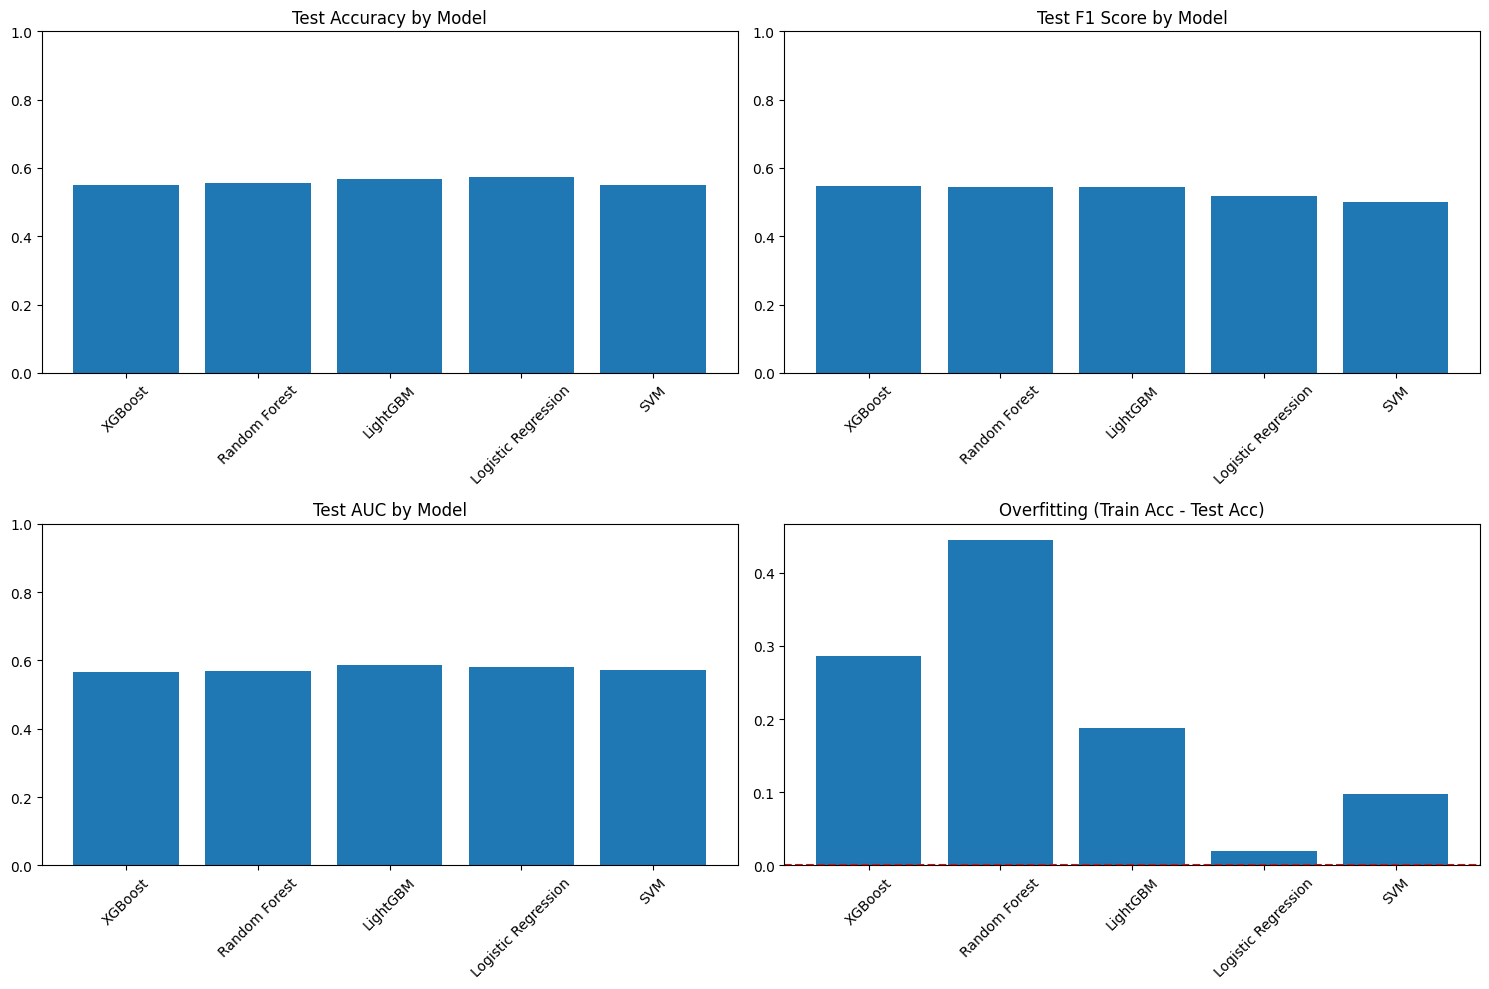

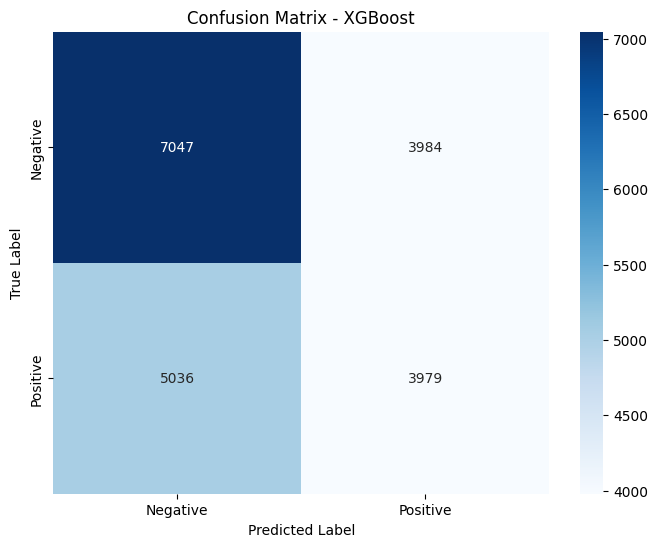


Detailed Classification Report - XGBoost:
              precision    recall  f1-score   support

    Negative       0.58      0.64      0.61     11031
    Positive       0.50      0.44      0.47      9015

    accuracy                           0.55     20046
   macro avg       0.54      0.54      0.54     20046
weighted avg       0.55      0.55      0.55     20046


📊 3-Class Classification (day):
Training multiclass classification models...

Training Logistic Regression...
  Train Acc: 0.661 | Test Acc: 0.609
  Train F1:  0.538 | Test F1:  0.462
  Test AUC:  0.573

Training Random Forest...
  Train Acc: 1.000 | Test Acc: 0.608
  Train F1:  1.000 | Test F1:  0.501
  Test AUC:  0.568

Training XGBoost...
  Train Acc: 0.827 | Test Acc: 0.596
  Train F1:  0.809 | Test F1:  0.503
  Test AUC:  0.587

Training LightGBM...
  Train Acc: 0.763 | Test Acc: 0.612
  Train F1:  0.720 | Test F1:  0.489
  Test AUC:  0.597
Classification Model Evaluation
              Model  Test Accuracy  Test Prec

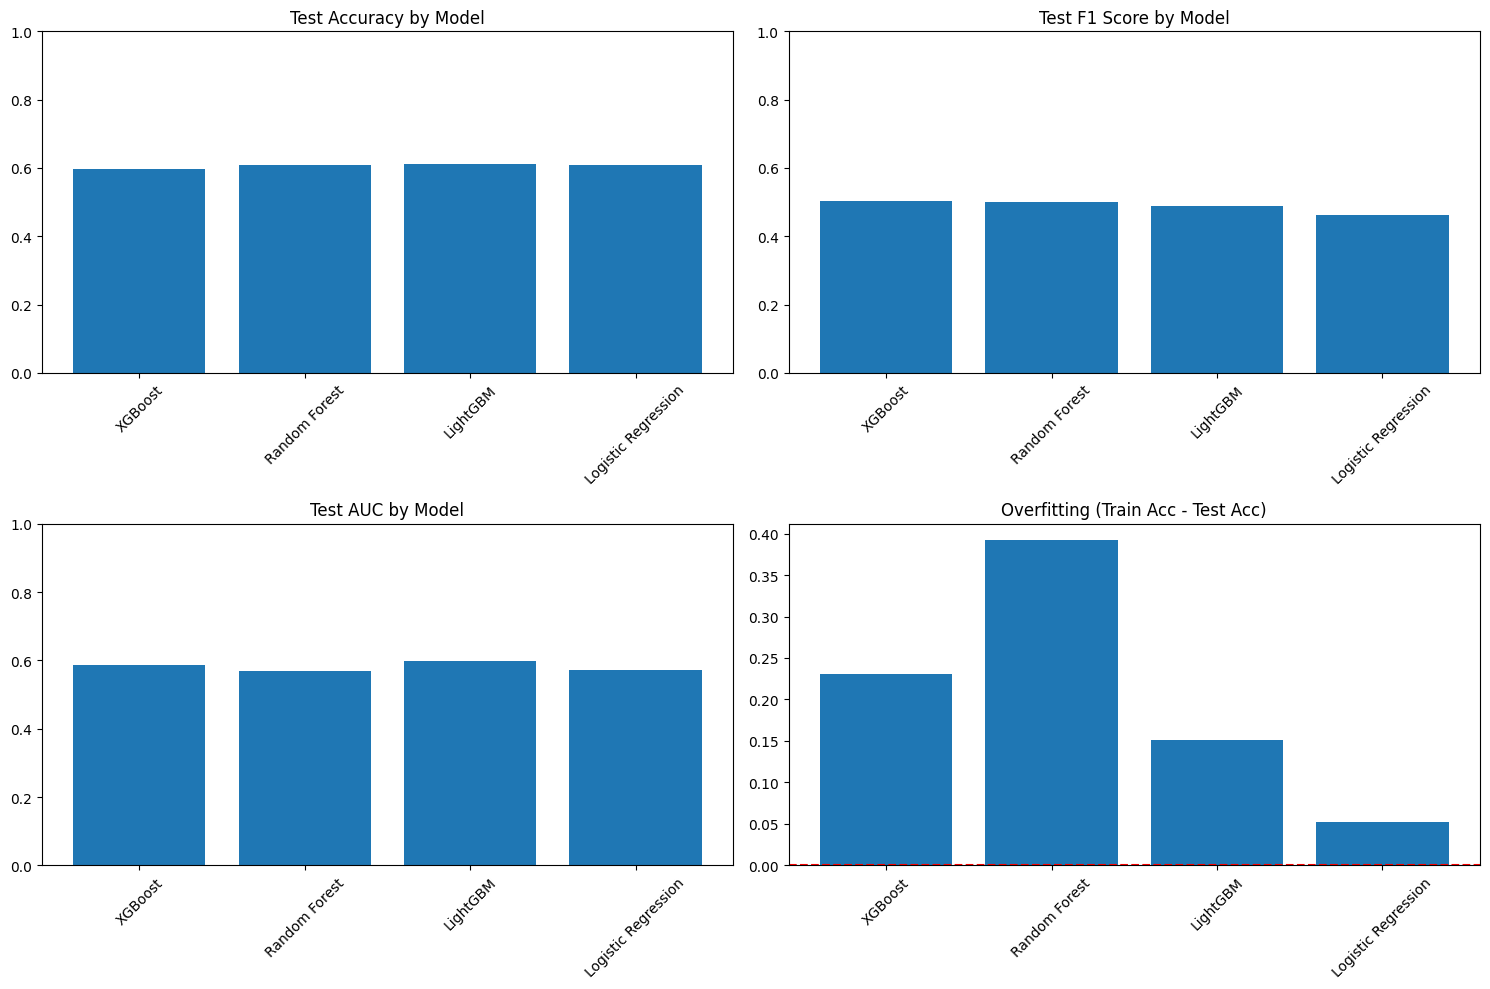

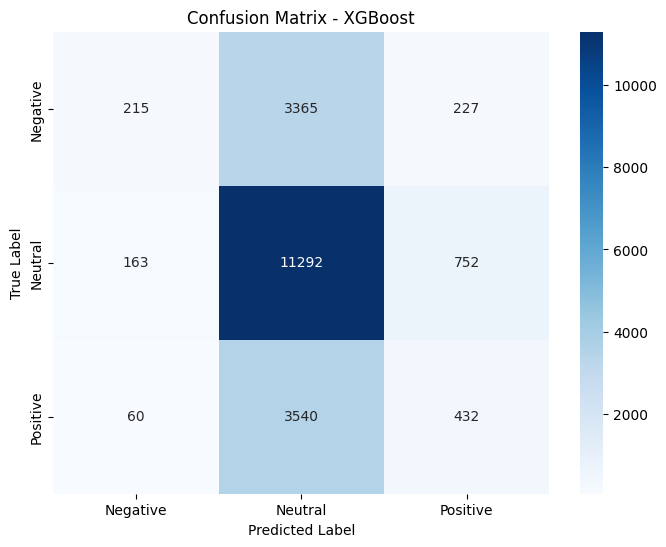


Detailed Classification Report - XGBoost:
              precision    recall  f1-score   support

    Negative       0.49      0.06      0.10      3807
     Neutral       0.62      0.93      0.74     12207
    Positive       0.31      0.11      0.16      4032

    accuracy                           0.60     20046
   macro avg       0.47      0.36      0.33     20046
weighted avg       0.53      0.60      0.50     20046

Feature Importance Analysis - XGBoost


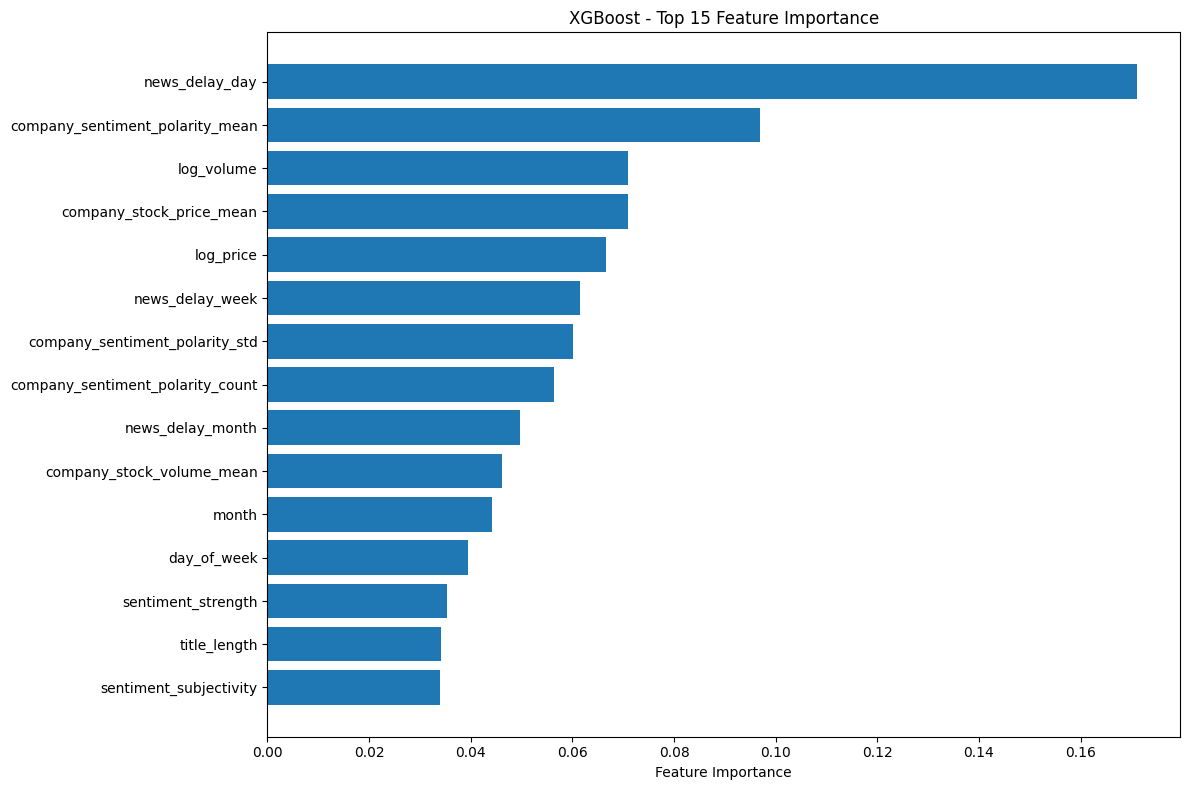

Top 10 Most Important Features:
 1. news_delay_day            0.1710
 2. company_sentiment_polarity_mean 0.0969
 3. log_volume                0.0709
 4. company_stock_price_mean  0.0708
 5. log_price                 0.0666
 6. news_delay_week           0.0616
 7. company_sentiment_polarity_std 0.0600
 8. company_sentiment_polarity_count 0.0565
 9. news_delay_month          0.0496
10. company_stock_volume_mean 0.0461

🔍 ANALYZING WEEK HORIZON

📊 Binary Classification (week):
Training binary classification models...

Training Logistic Regression...
  Train Acc: 0.558 | Test Acc: 0.555
  Train F1:  0.470 | Test F1:  0.457
  Test AUC:  0.516

Training Random Forest...
  Train Acc: 1.000 | Test Acc: 0.511
  Train F1:  1.000 | Test F1:  0.505
  Test AUC:  0.502

Training XGBoost...
  Train Acc: 0.824 | Test Acc: 0.495
  Train F1:  0.822 | Test F1:  0.496
  Test AUC:  0.491

Training LightGBM...
  Train Acc: 0.750 | Test Acc: 0.516
  Train F1:  0.741 | Test F1:  0.510
  Test AUC:  0.506

Trai

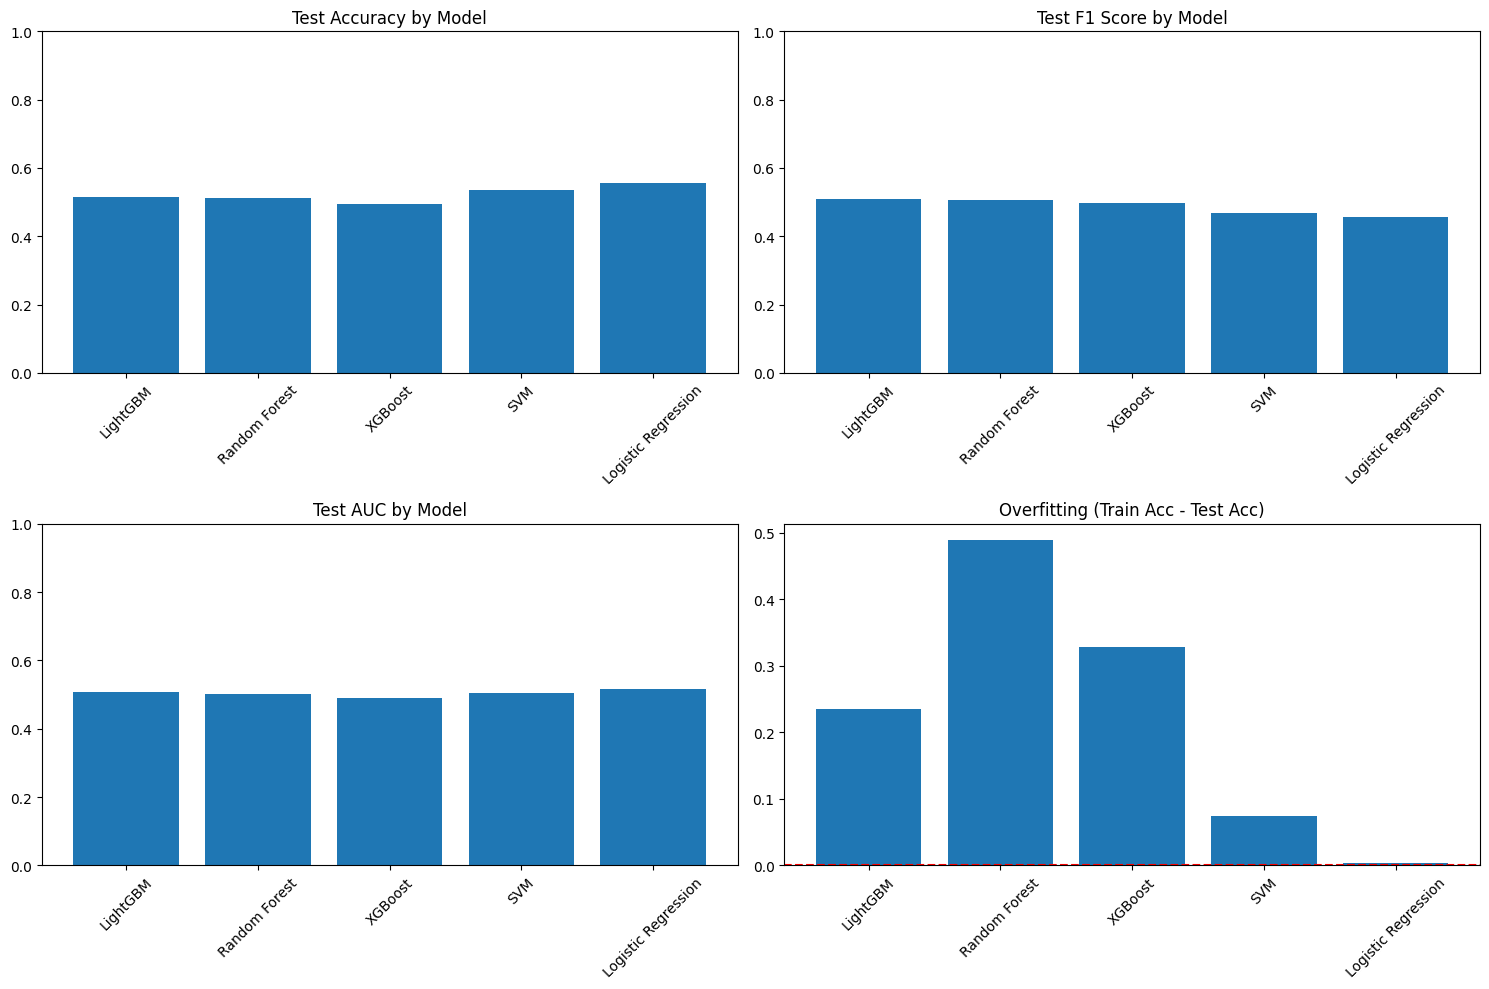

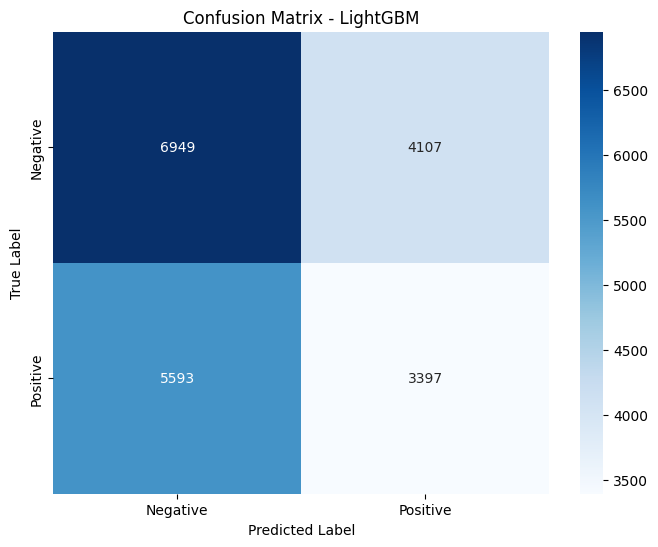


Detailed Classification Report - LightGBM:
              precision    recall  f1-score   support

    Negative       0.55      0.63      0.59     11056
    Positive       0.45      0.38      0.41      8990

    accuracy                           0.52     20046
   macro avg       0.50      0.50      0.50     20046
weighted avg       0.51      0.52      0.51     20046


📊 3-Class Classification (week):
Training multiclass classification models...

Training Logistic Regression...
  Train Acc: 0.717 | Test Acc: 0.691
  Train F1:  0.623 | Test F1:  0.585
  Test AUC:  0.589

Training Random Forest...
  Train Acc: 1.000 | Test Acc: 0.708
  Train F1:  1.000 | Test F1:  0.611
  Test AUC:  0.577

Training XGBoost...
  Train Acc: 0.860 | Test Acc: 0.699
  Train F1:  0.845 | Test F1:  0.613
  Test AUC:  0.610

Training LightGBM...
  Train Acc: 0.806 | Test Acc: 0.709
  Train F1:  0.771 | Test F1:  0.613
  Test AUC:  0.609
Classification Model Evaluation
              Model  Test Accuracy  Test Pr

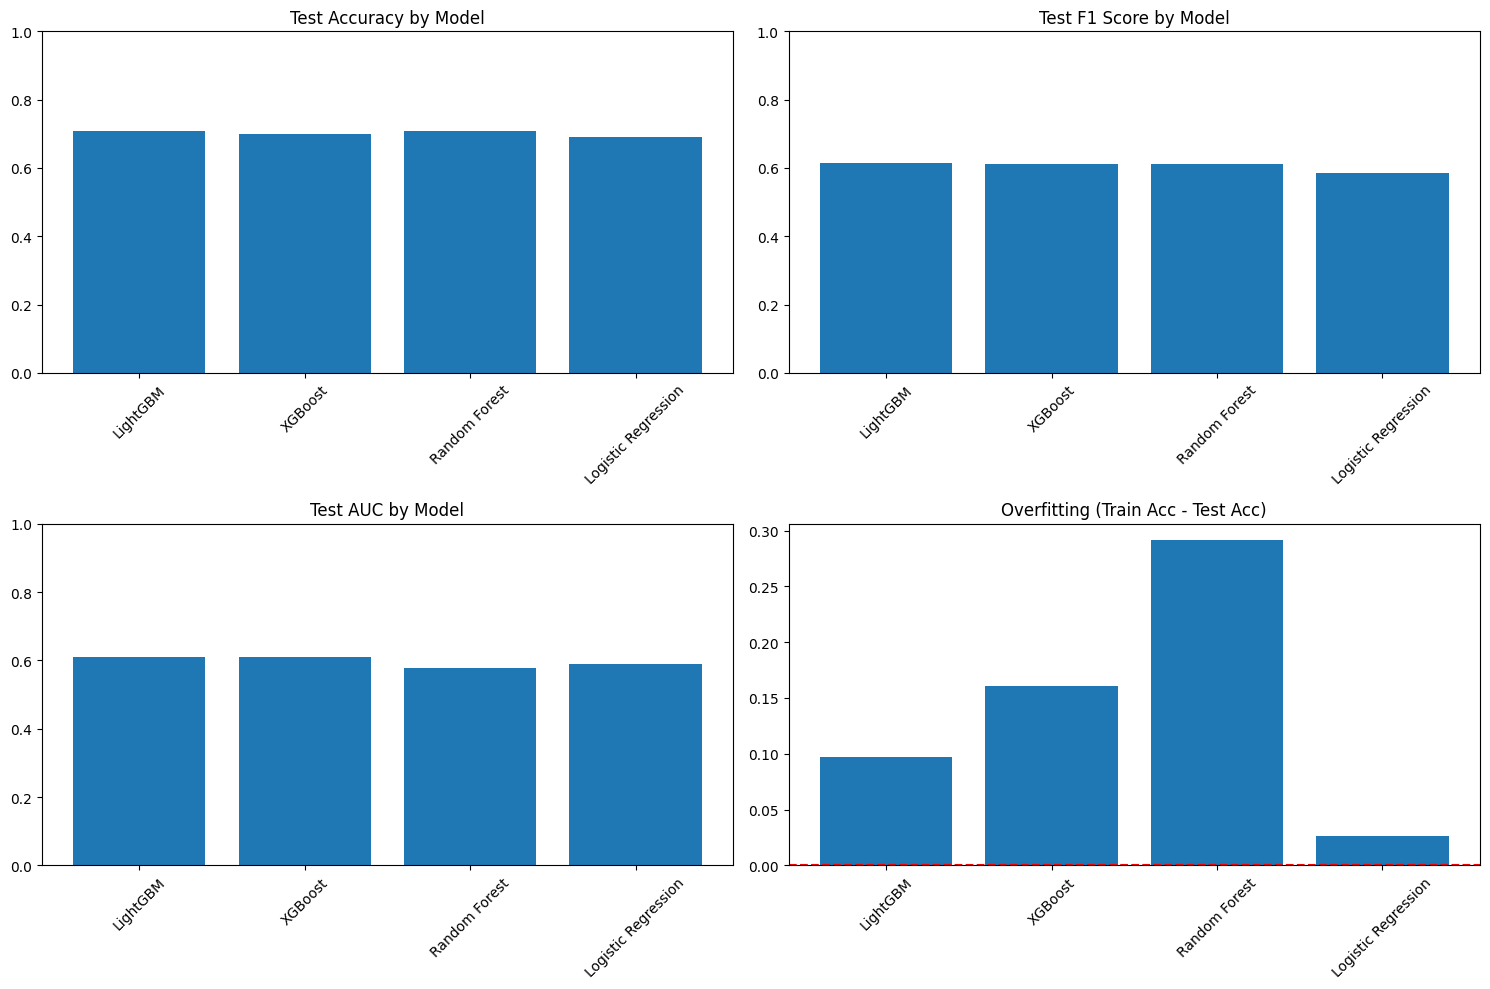

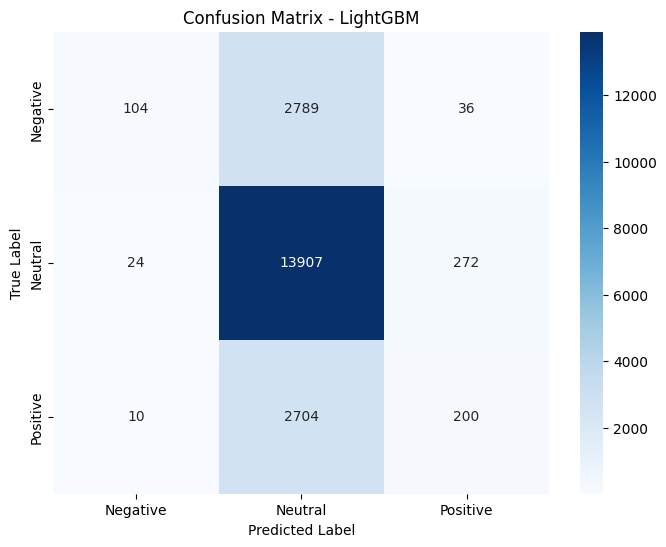


Detailed Classification Report - LightGBM:
              precision    recall  f1-score   support

    Negative       0.75      0.04      0.07      2929
     Neutral       0.72      0.98      0.83     14203
    Positive       0.39      0.07      0.12      2914

    accuracy                           0.71     20046
   macro avg       0.62      0.36      0.34     20046
weighted avg       0.68      0.71      0.61     20046

Feature Importance Analysis - LightGBM


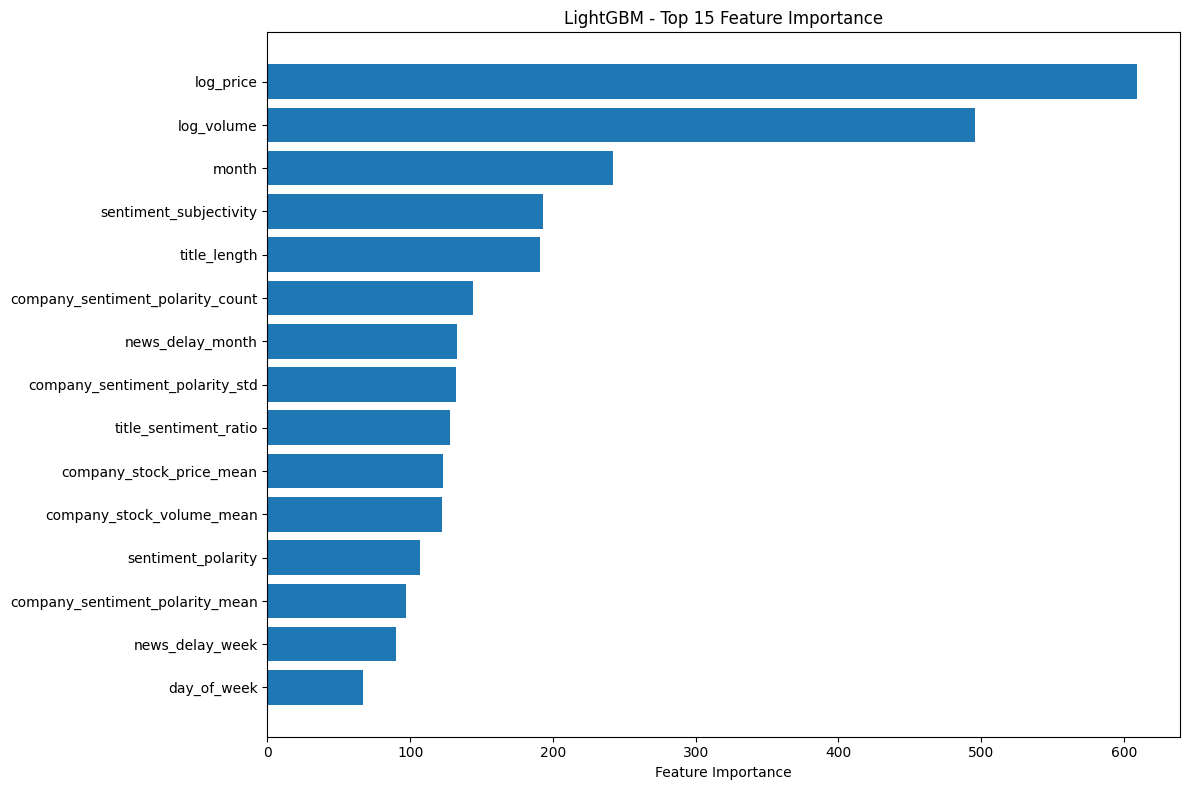

Top 10 Most Important Features:
 1. log_price                 609.0000
 2. log_volume                496.0000
 3. month                     242.0000
 4. sentiment_subjectivity    193.0000
 5. title_length              191.0000
 6. company_sentiment_polarity_count 144.0000
 7. news_delay_month          133.0000
 8. company_sentiment_polarity_std 132.0000
 9. title_sentiment_ratio     128.0000
10. company_stock_price_mean  123.0000

🔍 ANALYZING MONTH HORIZON

📊 Binary Classification (month):
Training binary classification models...

Training Logistic Regression...
  Train Acc: 0.551 | Test Acc: 0.541
  Train F1:  0.513 | Test F1:  0.494
  Test AUC:  0.510

Training Random Forest...
  Train Acc: 1.000 | Test Acc: 0.522
  Train F1:  1.000 | Test F1:  0.524
  Test AUC:  0.520

Training XGBoost...
  Train Acc: 0.862 | Test Acc: 0.514
  Train F1:  0.861 | Test F1:  0.517
  Test AUC:  0.530

Training LightGBM...
  Train Acc: 0.780 | Test Acc: 0.503
  Train F1:  0.778 | Test F1:  0.506
  Test A

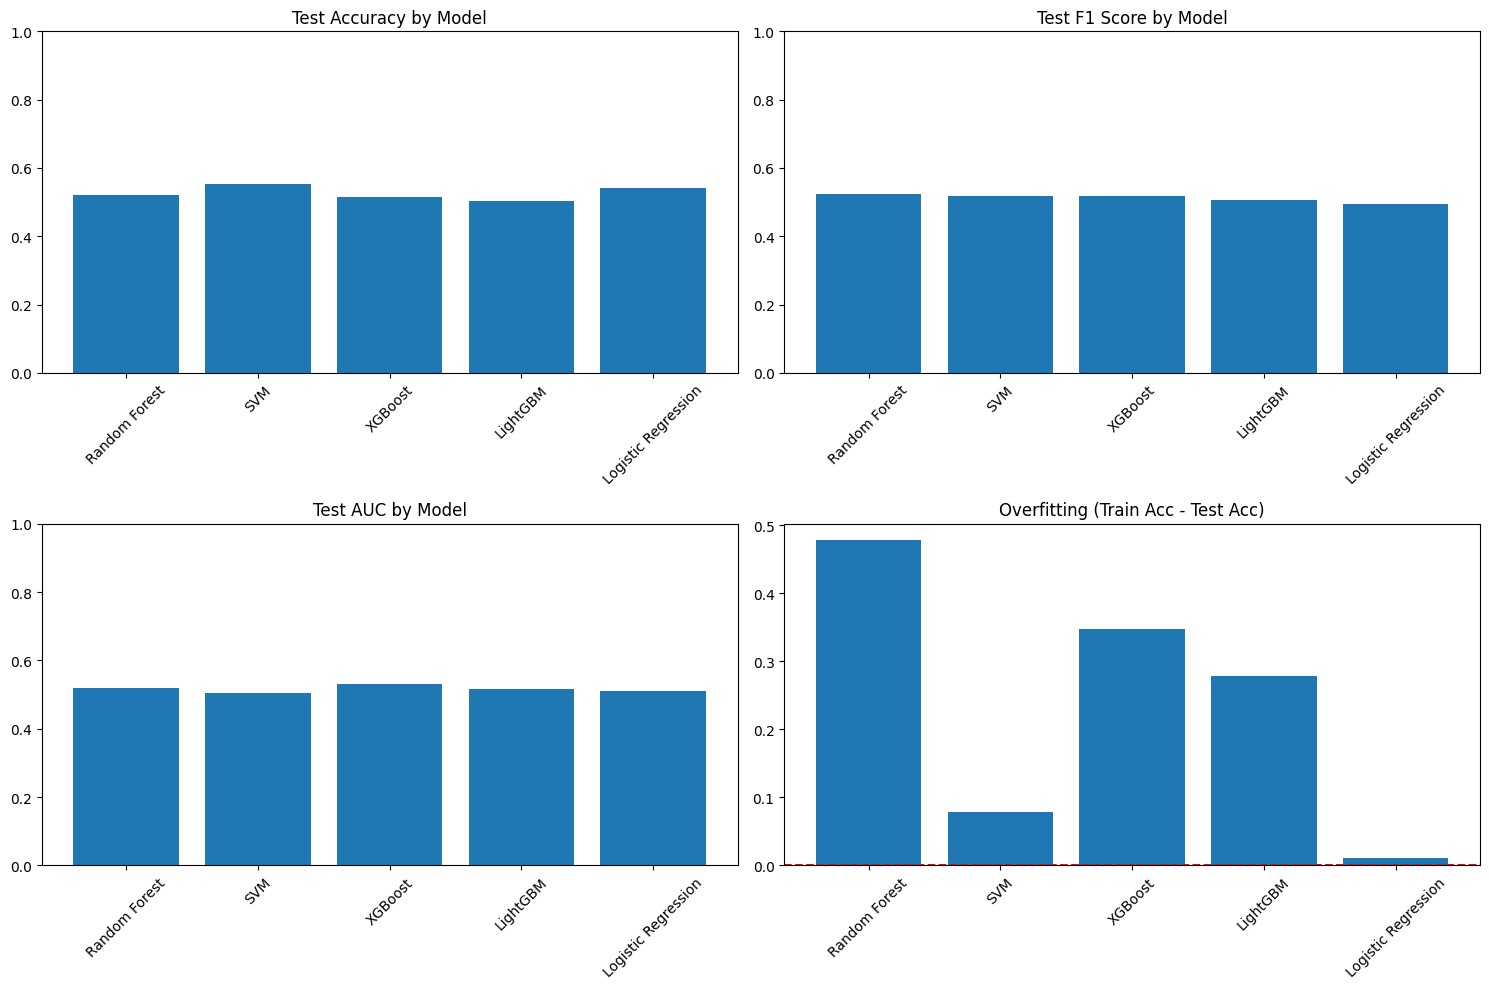

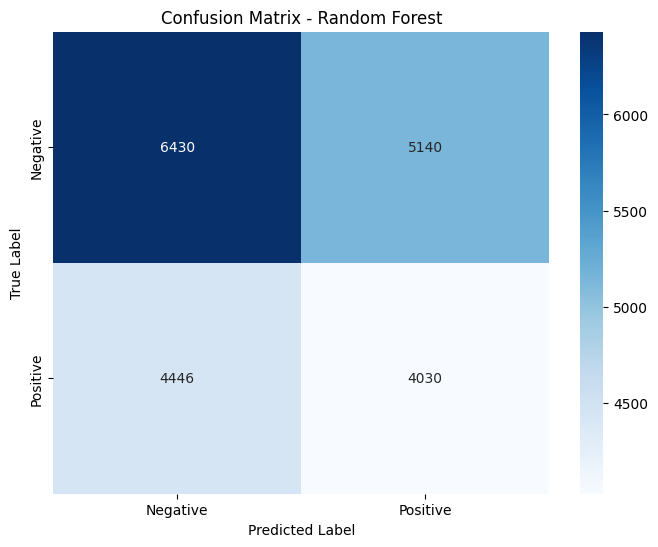


Detailed Classification Report - Random Forest:
              precision    recall  f1-score   support

    Negative       0.59      0.56      0.57     11570
    Positive       0.44      0.48      0.46      8476

    accuracy                           0.52     20046
   macro avg       0.52      0.52      0.51     20046
weighted avg       0.53      0.52      0.52     20046


📊 3-Class Classification (month):
Training multiclass classification models...

Training Logistic Regression...
  Train Acc: 0.756 | Test Acc: 0.802
  Train F1:  0.668 | Test F1:  0.736
  Test AUC:  0.509

Training Random Forest...
  Train Acc: 1.000 | Test Acc: 0.783
  Train F1:  1.000 | Test F1:  0.737
  Test AUC:  0.604

Training XGBoost...
  Train Acc: 0.909 | Test Acc: 0.755
  Train F1:  0.902 | Test F1:  0.735
  Test AUC:  0.608

Training LightGBM...
  Train Acc: 0.860 | Test Acc: 0.769
  Train F1:  0.841 | Test F1:  0.728
  Test AUC:  0.609
Classification Model Evaluation
              Model  Test Accuracy  T

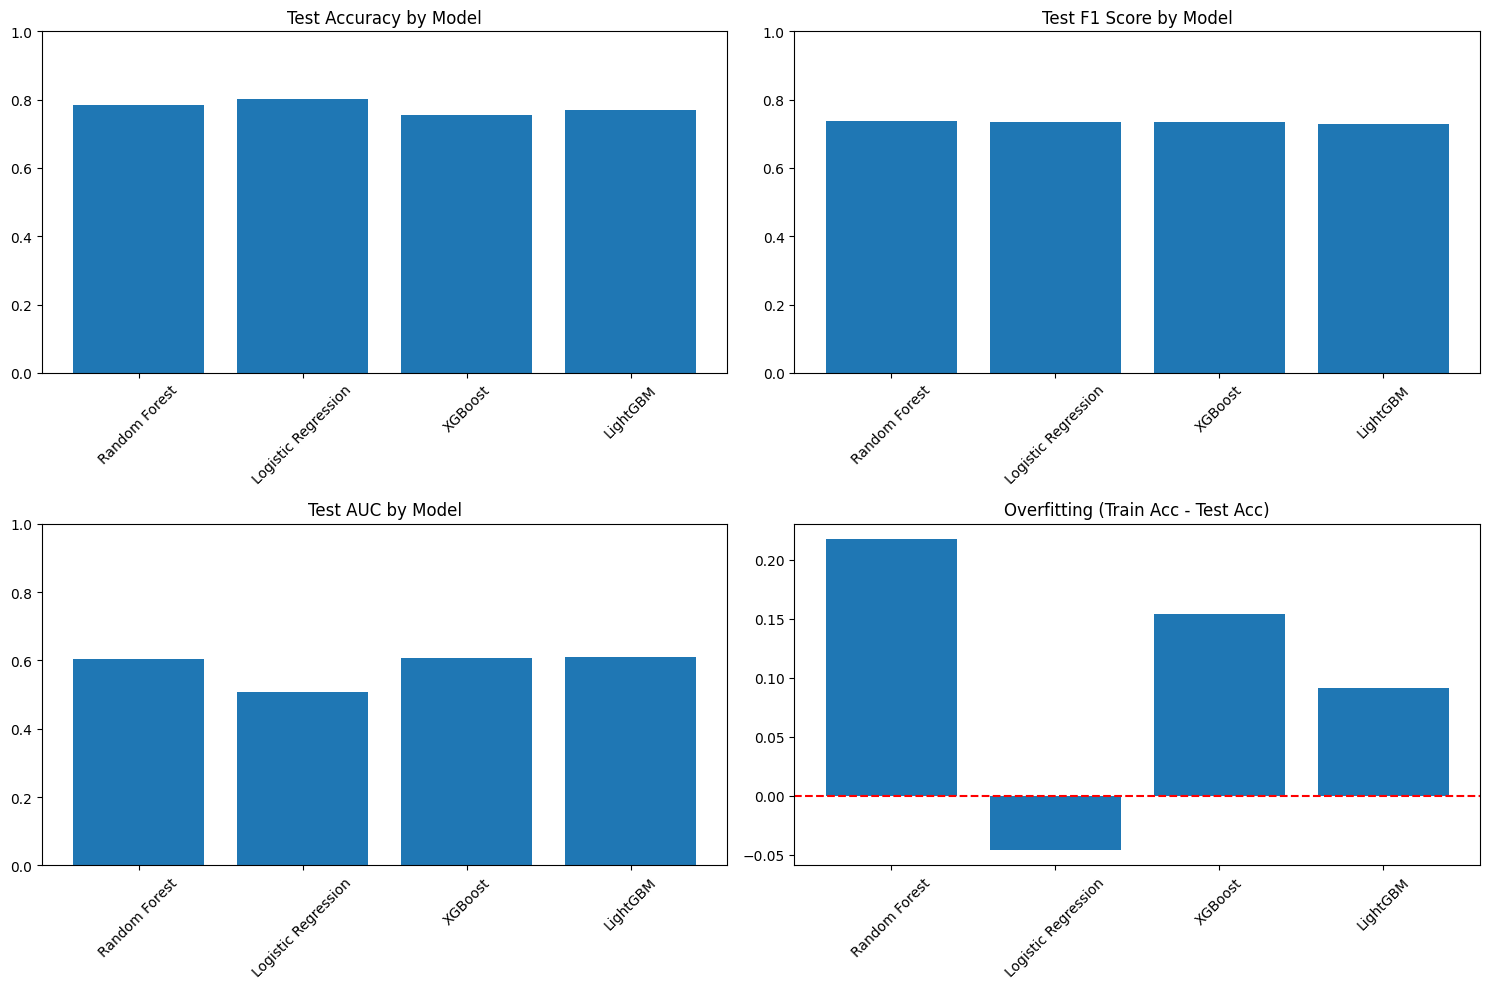

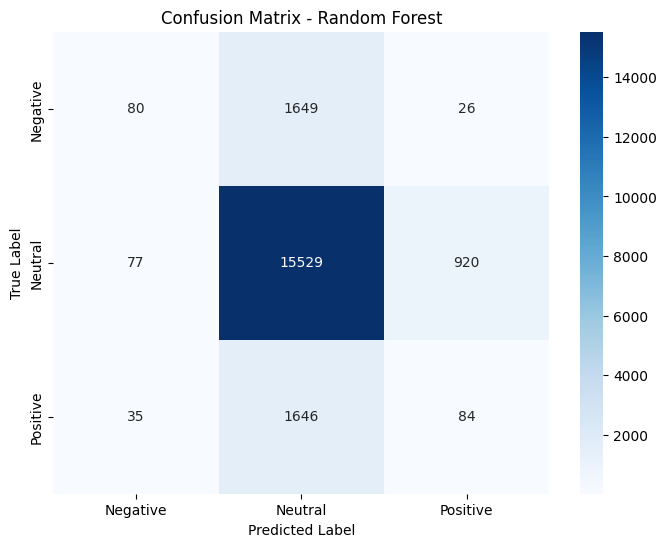


Detailed Classification Report - Random Forest:
              precision    recall  f1-score   support

    Negative       0.42      0.05      0.08      1755
     Neutral       0.82      0.94      0.88     16526
    Positive       0.08      0.05      0.06      1765

    accuracy                           0.78     20046
   macro avg       0.44      0.34      0.34     20046
weighted avg       0.72      0.78      0.74     20046

Feature Importance Analysis - Random Forest


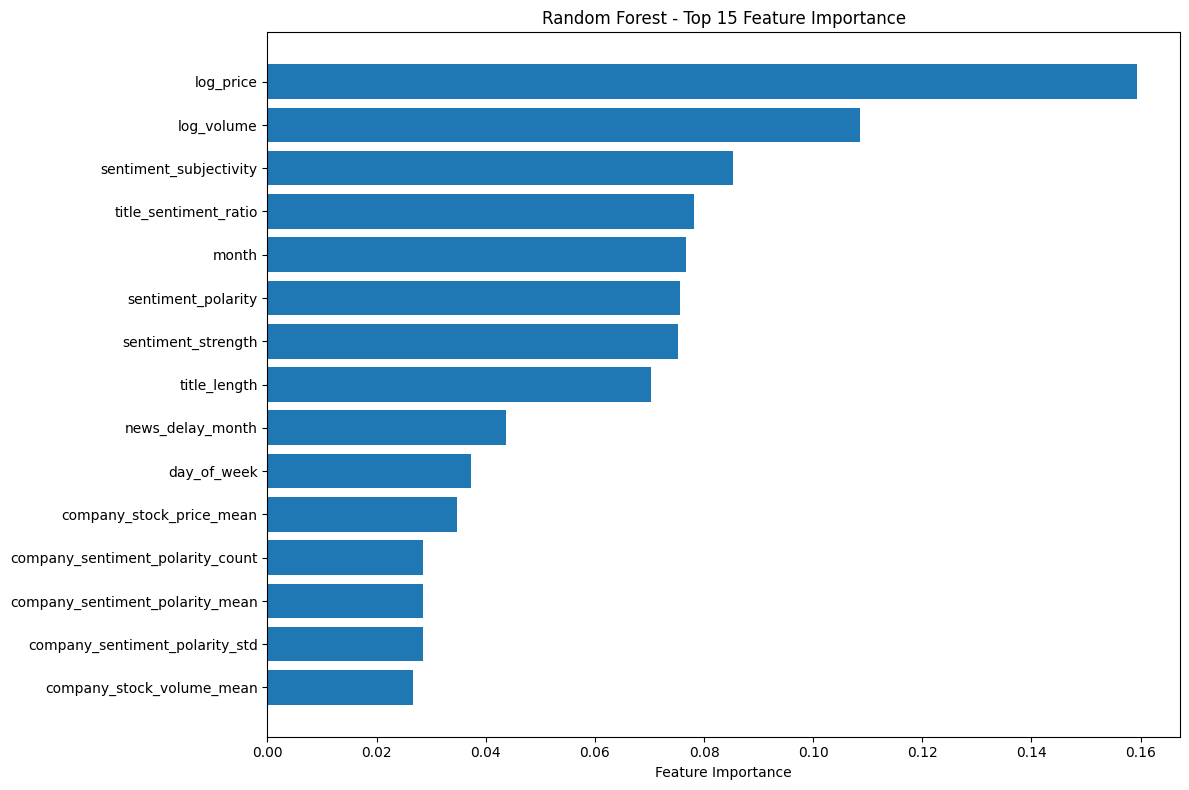

Top 10 Most Important Features:
 1. log_price                 0.1593
 2. log_volume                0.1085
 3. sentiment_subjectivity    0.0853
 4. title_sentiment_ratio     0.0782
 5. month                     0.0767
 6. sentiment_polarity        0.0757
 7. sentiment_strength        0.0752
 8. title_length              0.0702
 9. news_delay_month          0.0438
10. day_of_week               0.0374

💡 STEP 6: Generating Business Insights...
NEWS IMPACT CLASSIFICATION - BUSINESS INSIGHTS

🏆 BEST MODEL PERFORMANCE BY HORIZON:
--------------------------------------------------
   DAY - Binary: XGBoost         F1=0.546
      - 3-Class: XGBoost         F1=0.503
  WEEK - Binary: LightGBM        F1=0.510
      - 3-Class: LightGBM        F1=0.613
 MONTH - Binary: Random Forest   F1=0.524
      - 3-Class: Random Forest   F1=0.737

📈 PREDICTABILITY ANALYSIS:
--------------------------------------------------
1.    Day horizon - F1: 0.546 (Low predictability)
2.  Month horizon - F1: 0.524 (Low pr

In [73]:
pipeline_results = run_complete_classification_pipeline(sentiment_df, stocks_df)